<a href="https://colab.research.google.com/github/ms624atyale/Archive/blob/main/13_SentimentAnalysis_HarryPotter_AllSevenCopiesIncluded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##🐹 🐾 🐟 This script is based on [**Prof. Hosung Nam's github (hsnam95)**](https://github.com/hsnam95) and [**Prof. Junkyu Lee's github (junkyuhufs)**](https://github.com/junkyuhufs)

In [1]:
#@markdown ##🐹 🐾  <font color = 'red'> **[1] 복제하여 Harry Potter자료 가져오기**
!git clone https://github.com/ErikaJacobs/Harry-Potter-Text-Mining.git

Cloning into 'Harry-Potter-Text-Mining'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 106
Receiving objects: 100% (109/109), 13.39 MiB | 24.57 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [2]:
#@markdown ##🐹 🐾  <font color = 'blue'> **[2] 데이터 전처리: Pandas이용 데이터 정리 (책의 한 챕터가 한 셀에 있는 상태)**
import pandas as pd #Importing Pandas package
%cd /content/Harry-Potter-Text-Mining/Book Text

import glob
fns = glob.glob('*.txt')
df = pd.DataFrame()
for fn in fns:
  dftmp = pd.read_csv(fn, sep="@")
  df = pd.concat([df, dftmp])

%cd /content

df

/content/Harry-Potter-Text-Mining/Book Text
/content


,Text,Chapter,Book
0,It was nearing midnight and the Prime Ministe...,1,6
1,Many miles away the chilly mist that had pres...,2,6
2,Harry Potter was snoring loudly. He had been ...,3,6
3,Despite the fact that he had spent every waki...,4,6
4,Harry and Dumbledore approached the back door...,5,6
...,...,...,...
32,"Harry remained kneeling at Snape's side, simpl...",33,7
33,"Finally, the truth. Lying with his face presse...",34,7
34,"He lay facedown, listening to the silence. He ...",35,7
35,He was flying facedown on the ground again. Th...,36,7


In [3]:
#@markdown ##🐹 🐾  **[3] 데이터 전처리 불용어(stopwords) 제거**
import nltk #Import NLTK library
nltk.download('stopwords')
nltk.download('punkt') #installed punkt to fix error
from nltk import word_tokenize
from nltk.corpus import stopwords #Import stopwords to Python

stopwords = set(stopwords.words('english')) #English stopwords assigned to "stopwords" object

import string #Punctuation

# Function for removing punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

stopwords = [''.join(item for item in x if item not in string.punctuation) for x in stopwords] #Remove punctuation from stopwords

df['WordCountText']=df['Text'].str.lower().apply(remove_punctuations).apply(word_tokenize) # Word Count Text
# Word Count
df['WordCloudText']=df['WordCountText'].apply(lambda x: [word for word in x if word not in stopwords]) # Word Cloud Text
df['WordCount'] = df['WordCountText'].str.len() #Word Count Per Chapter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
#@markdown ##🐹 🐾  **[4] 데이터 전처리: 책 > 문장단위로 (챕터가 문장단위로 나뉜 상태)**
# Creating a table breaking down the text by each sentence, rather than each chapter.
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.stem import PorterStemmer

# Make smaller table - reset index to prepare for further work
dfsentiment = df[['Book','Chapter','Text']].reset_index() \
    .drop(["index"], axis=1)
dfsentiment = dfsentiment.join(dfsentiment.Text.apply(sent_tokenize).rename('Sentences')) # Breaking apart text into sentences

#Put every tokenized sentence into its own row
dfsentiment2 = dfsentiment.Sentences.apply(pd.Series) \
    .merge(dfsentiment, left_index = True, right_index = True) \
    .drop(["Text"], axis = 1) \
    .drop(["Sentences"], axis = 1) \
    .melt(id_vars = ['Book', 'Chapter'], value_name = "Sentence") \
    .drop("variable", axis = 1) \
    .dropna()

# Sort new table by Book and Chapter - reset index to reflect new order
dfsentiment2=dfsentiment2.sort_values(by=['Book', 'Chapter']) \
    .reset_index() \
    .drop(['index'], axis = 1)

# Clean punctuation, lower case
dfsentiment2['Sentence']=dfsentiment2.Sentence.apply(remove_punctuations).apply(lambda x: x.lower()) \

# Check first five values
dfsentiment2

,Book,Chapter,Sentence
0,1,1,the boy who lived mr and mrs dursley of numbe...
1,1,1,they were the last people youd expect to be in...
2,1,1,mr dursley was the director of a firm called g...
3,1,1,he was a big beefy man with hardly any neck al...
4,1,1,mrs dursley was thin and blonde and had nearly...
...,...,...,...
70979,7,37,the train began to more and harry walked along...
70980,7,37,harry kept smiling and waving even though it w...
70981,7,37,the train rounded a corner
70982,7,37,harrys hand was still raised in farewellhell b...


In [5]:
#@markdown ##🐹 🐾 **[5] 필요한 라이브러리(VADER library) 불러오기**
#>
#@markdown <font color = 'blue black'> "vader" refers to the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool, which is implemented as part of NLTK's sentiment module.

#@markdown VADER is **_valence aware_** because it takes into account the intensity of sentiment expressed in the text. It uses a pre-built lexicon (dictionary) of words, each annotated with a sentiment score indicating the positivity or negativity of the word. Additionally, it considers various grammatical and syntactical rules to interpret the sentiment expressed by the combination of words in a sentence.

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sid=nltk.sentiment.vader.SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


###Harry Potter 예시문장 (stemmed 문장)


|출처 | 예시문장 | 감정 |
|--|--|--|
|[0,1,1]|'the boy who lived mr and mrs dursley of number four privet drive were **proud** to say that they were perfectly normal **thank** you very much'|😄 Positive|[0,1,1]|
|[1,1,1]|'they were the last people youd expect to be involved in anything **strange** or **mysterious** because they just didnt hold with such **nonsense**'|😡 Negative |
|[2,1,1]|'mr dursley was the director of a firm called grunnings which made drills'|😐 Neutral|


+ *Note*. 출처 == [sentence number, Book, Chapter]

In [6]:
#@markdown ##🐹 🐾 **[6] 문장별로 감정분석 점수 부여; Compound, positive, negative, neutral**
# Get intensity scores of each sentence
dfsentiment2['Score']=dfsentiment2.Sentence.apply(lambda x: sid.polarity_scores(x))

# Place scores in own columns
dfsentiment2['CompScore']=dfsentiment2.Score.apply(lambda x: x.get("compound"))
dfsentiment2['PosScore']=dfsentiment2.Score.apply(lambda x: x.get("pos"))
dfsentiment2['NegScore']=dfsentiment2.Score.apply(lambda x: x.get("neg"))
dfsentiment2['NeuScore']=dfsentiment2.Score.apply(lambda x: x.get("neu"))

# With scores extracted, the original score field can be removed
dfsentiment2 = dfsentiment2.drop(["Score"], axis=1)

# Adding Sentiment Flags
dfsentiment2['PosFlag'] = dfsentiment2.CompScore.apply(lambda x: 1 if x >= 0.05 else 0)
dfsentiment2['NegFlag'] = dfsentiment2.CompScore.apply(lambda x: 1 if x <= -0.05 else 0)
dfsentiment2['NeuFlag'] = dfsentiment2.CompScore.apply(lambda x: 1 if x < 0.05 and x > -0.05 else 0)

In [7]:
#@markdown ##🐹 🐾 **[7] 처음 나온 결과 20개 보기**
dfsentiment2.head(20)

,Book,Chapter,Sentence,CompScore,PosScore,NegScore,NeuScore,PosFlag,NegFlag,NeuFlag
0,1,1,the boy who lived mr and mrs dursley of numbe...,0.8779,0.335,0.000,0.665,1,0,0
1,1,1,they were the last people youd expect to be in...,-0.5423,0.000,0.176,0.824,0,1,0
2,1,1,mr dursley was the director of a firm called g...,0.0000,0.000,0.000,1.000,0,0,1
3,1,1,he was a big beefy man with hardly any neck al...,0.0000,0.000,0.000,1.000,0,0,1
4,1,1,mrs dursley was thin and blonde and had nearly...,0.4927,0.084,0.000,0.916,1,0,0
5,1,1,the dursleys had a small son called dudley and...,-0.2960,0.000,0.121,0.879,0,1,0
6,1,1,the dursleys had everything they wanted but th...,0.3612,0.199,0.148,0.653,1,0,0
7,1,1,they didnt think they could bear it if anyone ...,0.0000,0.000,0.000,1.000,0,0,1
8,1,1,mrs potter was mrs dursleys sister but they ha...,0.0000,0.000,0.000,1.000,0,0,1
9,1,1,the dursleys shuddered to think what the neigh...,0.0000,0.000,0.000,1.000,0,0,1


* Negative Flag:  18385
* Neutral Flag:  33544
* Positive Flag:  19055
Total:  70984


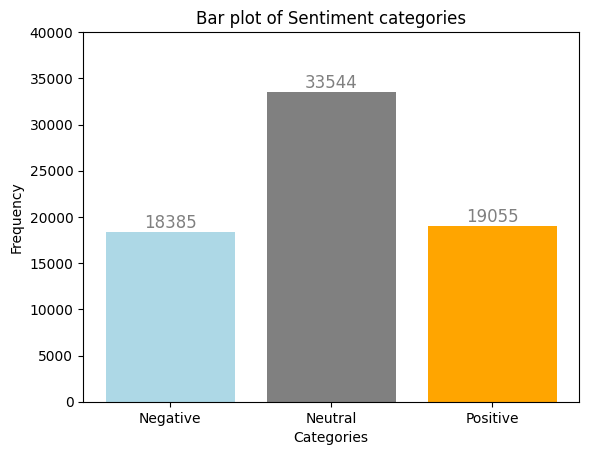

In [ ]:
#@markdown ##🐹 🐾 **[8] <font color = 'red'> 감정분석 결과 막대그래프 (부정, 중립, 긍정)**

print('* Negative Flag: ', dfsentiment2['NegFlag'].sum())
print('* Neutral Flag: ', dfsentiment2['NeuFlag'].sum())
print('* Positive Flag: ', dfsentiment2['PosFlag'].sum())
print("="*50)
print('Total: ',dfsentiment2['PosFlag'].sum()+dfsentiment2['NeuFlag'].sum()+dfsentiment2['NegFlag'].sum())


import numpy as np
import matplotlib.pyplot as plt

Negative = int(dfsentiment2['NegFlag'].sum())
Neutral = int(dfsentiment2['NeuFlag'].sum())
Positive = int(dfsentiment2['PosFlag'].sum())

# Your three integer frequencies
freqs = [Negative, Neutral, Positive]
# freqs = [18385, 33544, 19055]

# Create labels for the bars
labels = ['Negative', 'Neutral', 'Positive']

# Create x coordinates for the bars
x = np.arange(len(labels))

# Generate the bar plot
plt.bar(x, freqs)


# Specify the colors for each category
colors = ['lightblue', 'gray', 'orange']

# Generate the bar plot with custom colors

bars = plt.bar(x, freqs, color=colors)
# Add labels to the x-axis
plt.xticks(x, labels)

# Set axis labels
plt.xlabel('Categories')
plt.ylabel('Frequency')

# Set a title for the plot
plt.title('Bar plot of Sentiment categories')
plt.ylim(0, 40000)
# Add the frequency text within each bar
for bar, freq in zip(bars, freqs):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 2, str(freq),
             ha='center', va='bottom', fontsize=12, color='gray')


# Display the plot
plt.show()

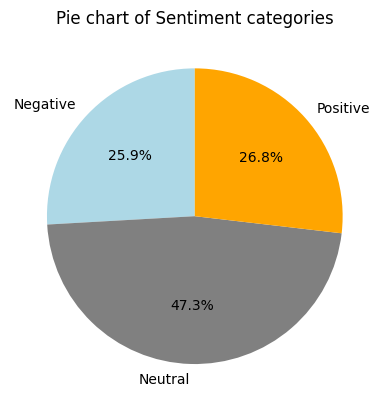

In [8]:
#@markdown ##🐹 🐾 **[9] <font color = 'red'> 감정분석 카테고리 파이차트 (비율확인용)**
import numpy as np
import matplotlib.pyplot as plt

Negative = int(dfsentiment2['NegFlag'].sum())
Neutral = int(dfsentiment2['NeuFlag'].sum())
Positive = int(dfsentiment2['PosFlag'].sum())

# Your three integer frequencies
freqs = [Negative, Neutral, Positive]

# Create labels for the segments
labels = ['Negative', 'Neutral', 'Positive']

# Specify the colors for each segment
colors = ['lightblue', 'gray', 'orange']

# Generate the pie chart with custom colors
plt.pie(freqs, labels=labels, colors=colors, autopct='%.1f%%', startangle=90)

# Set a title for the plot
plt.title('Pie chart of Sentiment categories')

# Display the plot
plt.show()

In [9]:
#@markdown ##🐹 🐾 **[10] <font color = 'red'> 7권 개별적으로 감정변화 흐름 확인**
#Time series of sentiments in 7 books of Harry Potter

dfsentiment2.groupby('Book').mean()['CompScore']

def Titles(x):
    if x == 1:
        return "1 - Sorcerer's Stone"
    if x == 2:
        return "2 - Chamber of Secrets"
    if x == 3:
        return "3 - Prizoner of Azkaban"
    if x == 4:
        return "4 - Goblet of Fire"
    if x == 5:
        return "5 - Order of the Phoenix"
    if x == 6:
        return "6 - Half Blood Prince"
    if x == 7:
        return "7 - Deathly Hallows"

dfsentiment2['BookTitle']=dfsentiment2.Book.apply(lambda x: Titles(x))

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

colorsList = ['#DC8458', '#950702', '#8E067D', '#2E8C44', '#395196', '#60A619','#ECA10A'] #Mauraders Map Colors
ColorMap = matplotlib.colors.ListedColormap(colorsList)

# plot data
fig, ax = plt.subplots(figsize=(10,16))
# use unstack()
dfsentiment2.groupby(['Chapter','BookTitle']).mean()['CompScore'].unstack().plot(ax=ax, subplots=True, ylim=(-0.25, 0.25), colormap=ColorMap)
plt.style.use('ggplot')
ax.set_ylabel('Compound Sentiment Score')

[ax.legend(loc=1) for ax in plt.gcf().axes]

TypeError: Could not convert the boy who lived  mr and mrs dursley of number four privet drive were proud to say that they were perfectly normal thank you very muchthey were the last people youd expect to be involved in anything strange or mysterious because they just didnt hold with such nonsensemr dursley was the director of a firm called grunnings which made drillshe was a big beefy man with hardly any neck although he did have a very large mustachemrs dursley was thin and blonde and had nearly twice the usual amount of neck which came in very useful as she spent so much of her time craning over garden fences spying on the neighborsthe dursleys had a small son called dudley and in their opinion there was no finer boy anywherethe dursleys had everything they wanted but they also had a secret and their greatest fear was that somebody would discover itthey didnt think they could bear it if anyone found out about the pottersmrs potter was mrs dursleys sister but they hadnt met for several years in fact mrs dursley pretended she didnt have a sister because her sister and her goodfornothing husband were as undursleyish as it was possible to bethe dursleys shuddered to think what the neighbors would say if the potters arrived in the streetthe dursleys knew that the potters had a small son too but they had never even seen himthis boy was another good reason for keeping the potters away they didnt want dudley mixing with a child like thatwhen mr and mrs dursley woke up on the dull gray tuesday our story starts there was nothing about the cloudy sky outside to suggest that strange and mysterious things would soon be happening all over the countrymr dursley hummed as he picked out his most boring tie for work and mrs dursley gossiped away happily as she wrestled a screaming dudley into his high chairnone of them noticed a large tawny owl flutter past the windowat half past eight mr dursley picked up his briefcase pecked mrs dursley on the cheek and tried to kiss dudley goodbye but missed because dudley was now having a tantrum and throwing his cereal at the wallslittle tyke chortled mr dursley as he left the househe got into his car and backed out of number fours driveit was on the corner of the street that he noticed the first sign of something peculiar  a cat reading a mapfor a second mr dursley didnt realize what he had seen  then he jerked his head around to look againthere was a tabby cat standing on the corner of privet drive but there wasnt a map in sightwhat could he have been thinking ofit must have been a trick of the lightmr dursley blinked and stared at the catit stared backas mr dursley drove around the corner and up the road he watched the cat in his mirrorit was now reading the sign that said privet drive  no looking at the sign cats couldnt read maps or signsmr dursley gave himself a little shake and put the cat out of his mindas he drove toward town he thought of nothing except a large order of drills he was hoping to get that daybut on the edge of town drills were driven out of his mind by something elseas he sat in the usual morning traffic jam he couldnt help noticing that there seemed to be a lot of strangely dressed people aboutpeople in cloaksmr dursley couldnt bear people who dressed in funny clothes  the getups you saw on young peoplehe supposed this was some stupid new fashionhe drummed his fingers on the steering wheel and his eyes fell on a huddle of these weirdos standing quite close bythey were whispering excitedly togethermr dursley was enraged to see that a couple of them werent young at all why that man had to be older than he was and wearing an emeraldgreen cloakthe nerve of himbut then it struck mr dursley that this was probably some silly stunt  these people were obviously collecting for something yes that would be itthe traffic moved on and a few minutes later mr dursley arrived in the grunnings parking lot his mind back on drillsmr dursley always sat with his back to the window in his office on the ninth floorif he hadnt he might have found it harder to concentrate on drills that morninghe didnt see the owls swoop ing past in broad daylight though people down in the street did they pointed and gazed open mouthed as owl after owl sped overheadmost of them had never seen an owl even at nighttimemr dursley however had a perfectly normal owlfree morninghe yelled at five different peoplehe made several important telephone calls and shouted a bit morehe was in a very good mood until lunchtime when he thought hed stretch his legs and walk across the road to buy himself a bun from the bakeryhed forgotten all about the people in cloaks until he passed a group of them next to the bakershe eyed them angrily as he passedhe didnt know why but they made him uneasythis bunch were whispering excitedly too and he couldnt see a single collecting tinit was on his way back past them clutching a large doughnut in a bag that he caught a few words of what they were sayingthe potters thats right thats what i heard yes their son harry  mr dursley stopped deadfear flooded himhe looked back at the whisperers as if he wanted to say something to them but thought better of ithe dashed back across the road hurried up to his office snapped at his secretary not to disturb him seized his telephone and had almost finished dialing his home number when he changed his mindhe put the receiver back down and stroked his mustache thinking no he was being stupidpotter wasnt such an unusual namehe was sure there were lots of people called potter who had a son called harrycome to think of it he wasnt even sure his nephew was called harryhed never even seen the boyit might have been harveyor haroldthere was no point in worrying mrs dursley she always got so upset at any mention of her sisterhe didnt blame her  if hed had a sister like that but all the same those people in cloakshe found it a lot harder to concentrate on drills that afternoon and when he left the building at five oclock he was still so worried that he walked straight into someone just outside the doorsorry he grunted as the tiny old man stumbled and almost fellit was a few seconds before mr dursley realized that the man was wearing a violet cloakhe didnt seem at all upset at being almost knocked to the groundon the contrary his face split into a wide smile and he said in a squeaky voice that made passersby stare dont be sorry my dear sir for nothing could upset me todayrejoice for youknowwho has gone at lasteven muggles like yourself should be celebrating this happy happy day  and the old man hugged mr dursley around the middle and walked offmr dursley stood rooted to the spothe had been hugged by a complete strangerhe also thought he had been called a muggle whatever that washe was rattledhe hurried to his car and set off for home hoping he was imagining things which he had never hoped before because he didnt approve of imaginationas he pulled into the driveway of number four the first thing he saw  and it didnt improve his mood  was the tabby cat hed spotted that morningit was now sitting on his garden wallhe was sure it was the same one it had the same markings around its eyesshoo said mr dursley loudlythe cat didnt moveit just gave him a stern lookwas this normal cat behaviormr dursley wonderedtrying to pull himself together he let himself into the househe was still determined not to mention anything to his wifemrs dursley had had a nice normal dayshe told him over dinner all about mrs next doors problems with her daughter and how dudley had learned a new word wontmr dursley tried to act normallywhen dudley had been put to bed he went into the living room in time to catch the last report on the evening news  and finally birdwatchers everywhere have reported that the nations owls have been behaving very unusually todayalthough owls normally hunt at night and are hardly ever seen in daylight there have been hundreds of sightings of these birds flying in every direction since sunriseexperts are unable to explain why the owls have suddenly changed their sleeping pattern the newscaster allowed himself a grinmost mysteriousand now over to jim mcguffin with the weathergoing to be any more showers of owls tonight jim  well ted said the weatherman i dont know about that but its not only the owls that have been acting oddly todayviewers as far apart as kent yorkshire and dundee have been phoning in to tell me that instead of the rain i promised yesterday theyve had a downpour of shooting starsperhaps people have been celebrating bonfire night early  its not until next week folksbut i can promise a wet night tonight  mr dursley sat frozen in his armchairshooting stars all over britainowls flying by daylightmysterious people in cloaks all over the placeand a whisper a whisper about the potters  mrs dursley came into the living room carrying two cups of teait was no goodhed have to say something to herhe cleared his throat nervouslyer  petunia dear  you havent heard from your sister lately have you  as he had expected mrs dursley looked shocked and angryafter all they normally pretended she didnt have a sisterno she said sharplywhy  funny stuff on the news mr dursley mumbledowls shooting stars and there were a lot of funnylooking people in town today  so snapped mrs dursleywell i just thought maybe it was something to do with you know her crowd  mrs dursley sipped her tea through pursed lipsmr dursley wondered whether he dared tell her hed heard the name potter he decided he didnt dareinstead he said as casually as he could their son  hed be about dudleys age now wouldnt he  i suppose so said mrs dursley stifflywhats his name againhoward isnt it  harrynasty common name if you ask me  oh yes said mr dursley his heart sinking horriblyyes i quite agree  he didnt say another word on the subject as they went upstairs to bedwhile mrs dursley was in the bathroom mr dursley crept to the bedroom window and peered down into the front gardenthe cat was still thereit was staring down privet drive as though it were waiting for somethingwas he imagining thingscould all this have anything to do with the pottersif it did if it got out that they were related to a pair of  well he didnt think he could bear itthe dursleys got into bedmrs dursley fell asleep quickly but mr dursley lay awake turning it all over in his mindhis last comforting thought before he fell asleep was that even if the potters were involved there was no reason for them to come near him and mrs dursleythe potters knew very well what he and petunia thought about them and their kindhe couldnt see how he and petunia could get mixed up in anything that might be going on  he yawned and turned over  it couldnt affect them  how very wrong he wasmr dursley might have been drifting into an uneasy sleep but the cat on the wall outside was showing no sign of sleepinessit was sitting as still as a statue its eyes fixed unblinkingly on the far corner of privet driveit didnt so much as quiver when a car door slammed on the next street nor when two owls swooped overheadin fact it was nearly midnight before the cat moved at alla man appeared on the corner the cat had been watching appeared so suddenly and silently youd have thought hed just popped out of the groundthe cats tail twitched and its eyes narrowednothing like this man had ever been seen on privet drivehe was tall thin and very old judging by the silver of his hair and beard which were both long enough to tuck into his belthe was wearing long robes a purple cloak that swept the ground and highheeled buckled bootshis blue eyes were light bright and sparkling behind halfmoon spectacles and his nose was very long and crooked as though it had been broken at least twicethis mans name was albus dumbledorealbus dumbledore didnt seem to realize that he had just arrived in a street where everything from his name to his boots was unwelcomehe was busy rummaging in his cloak looking for somethingbut he did seem to realize he was being watched because he looked up suddenly at the cat which was still staring at him from the other end of the streetfor some reason the sight of the cat seemed to amuse himhe chuckled and muttered i should have known  he found what he was looking for in his inside pocketit seemed to be a silver cigarette lighterhe flicked it open held it up in the air and clicked itthe nearest street lamp went out with a little pophe clicked it again  the next lamp flickered into darknesstwelve times he clicked the putouter until the only lights left on the whole street were two tiny pinpricks in the distance which were the eyes of the cat watching himif anyone looked out of their window now even beadyeyed mrs dursley they wouldnt be able to see anything that was happening down on the pavementdumbledore slipped the putouter back inside his cloak and set off down the street toward number four where he sat down on the wall next to the cathe didnt look at it but after a moment he spoke to itfancy seeing you here professor mcgonagall  he turned to smile at the tabby but it had goneinstead he was smiling at a rather severelooking woman who was wearing square glasses exactly the shape of the markings the cat had had around its eyesshe too was wearing a cloak an emerald oneher black hair was drawn into a tight bunshe looked distinctly ruffledhow did you know it was me she askedmy dear professor i ve never seen a cat sit so stiffly  youd be stiff if youd been sitting on a brick wall all day said professor mcgonagallall daywhen you could have been celebratingi must have passed a dozen feasts and parties on my way here  professor mcgonagall sniffed angrilyoh yes everyones celebrating all right she said impatientlyyoud think theyd be a bit more careful but no  even the muggles have noticed somethings going onit was on their news she jerked her head back at the dursleys dark livingroom windowi heard itflocks of owls shooting stars well theyre not completely stupidthey were bound to notice somethingshooting stars down in kent  ill bet that was dedalus digglehe never had much sense  you cant blame them said dumbledore gentlyweve had precious little to celebrate for eleven years  i know that said professor mcgonagall irritablybut thats no reason to lose our headspeople are being downright careless out on the streets in broad daylight not even dressed in muggle clothes swapping rumors  she threw a sharp sideways glance at dumbledore here as though hoping he was going to tell her something but he didnt so she went ona fine thing it would be if on the very day youknowwho seems to have disappeared at last the muggles found out about us alli suppose he really has gone dumbledore  it certainly seems so said dumbledorewe have much to be thankful forwould you care for a lemon drop  a what  a lemon droptheyre a kind of muggle sweet im rather fond of  no thank you said professor mcgonagall coldly as though she didnt think this was the moment for lemon dropsas i say even if youknowwho has gone   my dear professor surely a sensible person like yourself can call him by his nameall this you knowwho nonsense  for eleven years i have been trying to persuade people to call him by his proper name voldemort professor mcgonagall flinched but dumbledore who was unsticking two lemon drops seemed not to noticeit all gets so confusing if we keep saying youknowwhoi have never seen any reason to be frightened of saying voldemorts namei know you haven t said professor mcgonagall sounding half exasperated half admiringbut youre differenteveryone knows youre the only one youknow oh all right voldemort was frightened of  you flatter me said dumbledore calmlyvoldemort had powers i will never have  only because youre too  well  noble to use them  its lucky its darki havent blushed so much since madam pomfrey told me she liked my new earmuffs  professor mcgonagall shot a sharp look at dumbledore and said the owls are nothing next to the rumors that are flying aroundyou know what everyones sayingabout why hes disappearedabout what finally stopped him  it seemed that professor mcgonagall had reached the point she was most anxious to discuss the real reason she had been waiting on a cold hard wall all day for neither as a cat nor as a woman had she fixed dumbledore with such a piercing stare as she did nowit was plain that whatever everyone was saying she was not going to believe it until dumbledore told her it was truedumbledore however was choosing another lemon drop and did not answerwhat theyre saying she pressed on is that last night voldemort turned up in godrics hollowhe went to find the pottersthe rumor is that lily and james potter are  are  that theyre  dead  dumbledore bowed his headprofessor mcgonagall gaspedlily and jamesi cant believe iti didnt want to believe it oh albus  dumbledore reached out and patted her on the shoulderi knowi know he said heavilyprofessor mcgonagalls voice trembled as she went onthats not alltheyre saying he tried to kill the potters son harrybut  he couldnthe couldnt kill that little boyno one knows why or how but theyre saying that when he couldnt kill harry potter voldemorts power somehow broke  and thats why hes gonedumbledore nodded glumlyits  its true faltered professor mcgonagallafter all hes done all the people hes killed he couldnt kill a little boyits just astounding of all the things to stop him but how in the name of heaven did harry survive  we can only guess said dumbledorewe may never know  professor mcgonagall pulled out a lace handkerchief and dabbed at her eyes beneath her spectaclesdumbledore gave a great sniff as he took a golden watch from his pocket and examined itit was a very odd watchit had twelve hands but no numbers instead little planets were moving around the edgeit must have made sense to dumbledore though because he put it back in his pocket and said hagrids latei suppose it was he who told you id be here by the way  yes said professor mcgonagalland i dont suppose youre going to tell me why youre here of all places  ive come to bring harry to his aunt and uncletheyre the only family he has left now  you dont mean  you cant mean the people who live here cried professor mcgonagall jumping to her feet and pointing at number fourdumbledore  you cantive been watching them all dayyou couldnt find two people who are less like usand theyve got this son  i saw him kicking his mother all the way up the street screaming for sweetsharry potter come and live here  its the best place for him said dumbledore firmlyhis aunt and uncle will be able to explain everything to him when hes olderive written them a letter  a letter repeated professor mcgonagall faintly sitting back down on the wallreally dumbledore you think you can explain all this in a letterthese people will never understand himhell be famous  a legend  i wouldnt be surprised if today was known as harry potter day in the future  there will be books written about harry  every child in our world will know his name  exactly said dumbledore looking very seriously over the top of his halfmoon glassesit would be enough to turn any boys headfamous before he can walk and talkfamous for something he wont even remembercara you see how much better off hell be growing up away from all that until hes ready to take it  professor mcgonagall opened her mouth changed her mind swallowed and then said yes  yes youre right of coursebut how is the boy getting here dumbledore she eyed his cloak suddenly as though she thought he might be hiding harry underneath ithagrids bringing him  you think it  wise  to trust hagrid with something as important as this  i would trust hagrid with my life said dumbledoreim not saying his heart isnt in the right place said professor mcgonagall grudgingly but you cant pretend hes not carelesshe does tend to  what was that  a low rumbling sound had broken the silence around themit grew steadily louder as they looked up and down the street for some sign of a headlight it swelled to a roar as they both looked up at the sky  and a huge motorcycle fell out of the air and landed on the road in front of themif the motorcycle was huge it was nothing to the man sitting astride ithe was almost twice as tall as a normal man and at least five times as widehe looked simply too big to be allowed and so wild  long tangles of bushy black hair and beard hid most of his face he had hands the size of trash can lids and his feet in their leather boots were like baby dolphinsin his vast muscular arms he was holding a bundle of blanketshagrid said dumbledore sounding relievedat lastand where did you get that motorcycle  borrowed it professor dumbledore sit said the giant climbing carefully off the motorcycle as he spokeyoung sirius black lent it to meive got him sir  no problems were there  no sir  house was almost destroyed but i got him out all right before the muggles started swarmin aroundhe fell asleep as we was flyin over bristol  dumbledore and professor mcgonagall bent forward over the bundle of blanketsinside just visible was a baby boy fast asleepunder a tuft of jetblack hair over his forehead they could see a curiously shaped cut like a bolt of lightningis that where  whispered professor mcgonagallyes said dumbledorehell have that scar forever  couldnt you do something about it dumbledore  even if i could i wouldntscars can come in handyi have one myself above my left knee that is a perfect map of the london undergroundwell  give him here hagrid  wed better get this over with  dumbledore took harry in his arms and turned toward the dursleys housecould i  could i say goodbye to him sir asked hagridhe bent his great shaggy head over harry and gave him what must have been a very scratchy whiskery kissthen suddenly hagrid let out a howl like a wounded dogshhh hissed professor mcgonagall youll wake the muggles  sssorry sobbed hagrid taking out a large spotted handkerchief and burying his face in itbut i cccant stand it  lily an james dead  an poor little harry off ter live with muggles   yes yes its all very sad but get a grip on yourself hagrid or well be found professor mcgonagall whispered patting hagrid gingerly on the arm as dumbledore stepped over the low garden wall and walked to the front doorhe laid harry gently on the doorstep took a letter out of his cloak tucked it inside harrys blankets and then came back to the other twofor a full minute the three of them stood and looked at the little bundle hagrids shoulders shook professor mcgonagall blinked furiously and the twinkling light that usually shone from dumbledores eyes seemed to have gone outwell said dumbledore finally thats thatweve no business staying herewe may as well go and join the celebrations  yeah said hagrid in a very muffled voice ill be takin sirius his bike backgnight professor mcgonagall  professor dumbledore sir  wiping his streaming eyes on his jacket sleeve hagrid swung himself onto the motorcycle and kicked the engine into life with a roar it rose into the air and off into the nighti shall see you soon i expect professor mcgonagall said dumbledore nodding to herprofessor mcgonagall blew her nose in replydumbledore turned and walked back down the streeton the corner he stopped and took out the silver putouterhe clicked it once and twelve balls of light sped back to their street lamps so that privet drive glowed suddenly orange and he could make out a tabby cat slinking around the corner at the other end of the streethe could just see the bundle of blankets on the step of number fourgood luck harry he murmuredhe turned on his heel and with a swish of his cloak he was gonea breeze ruffled the neat hedges of privet drive which lay silent and tidy under the inky sky the very last place you would expect astonishing things to happenharry potter rolled over inside his blankets without waking upone small hand closed on the letter beside him and he slept on not knowing he was special not knowing he was famous not knowing he would be woken in a few hours time by mrs dursleys scream as she opened the front door to put out the milk bottles nor that he would spend the next few weeks being prodded and pinched by his cousin dudleyhe couldnt know that at this very moment people meeting in secret all over the country were holding up their glasses and saying in hushed voices to harry potter  the boy who livedthe vanishing glass  nearly ten years had passed since the dursleys had woken up to find their nephew on the front step but privet drive had hardly changed at allthe sun rose on the same tidy front gardens and lit up the brass number four on the dursleys front door it crept into their living room which was almost exactly the same as it had been on the night when mr dursley had seen that fateful news report about the owlsonly the photographs on the mantelpiece really showed how much time had passedten years ago there had been lots of pictures of what looked like a large pink beach ball wearing differentcolored bonnets  but dudley dursley was no longer a baby and now the photographs showed a large blond boy riding his first bicycle on a carousel at the fair playing a computer game with his father being hugged and kissed by his motherthe room held no sign at all that another boy lived in the house tooyet harry potter was still there asleep at the moment but not for longhis aunt petunia was awake and it was her shrill voice that made the first noise of the dayupget upnow  harry woke with a starthis aunt rapped on the door againup she screechedharry heard her walking toward the kitchen and then the sound of the frying pan being put on the stovehe rolled onto his back and tried to remember the dream he had been havingit had been a good onethere had been a flying motorcycle in ithe had a funny feeling hed had the same dream beforehis aunt was back outside the doorare you up yet she demandednearly said harrywell get a move on i want you to look after the baconand dont you dare let it burn i want everything perfect on duddys birthday  harry groanedwhat did you say his aunt snapped through the doornothing nothing  dudleys birthday  how could he have forgottenharry got slowly out of bed and started looking for sockshe found a pair under his bed and after pulling a spider off one of them put them onharry was used to spiders because the cupboard under the stairs was full of them and that was where he sleptwhen he was dressed he went down the hall into the kitchenthe table was almost hidden beneath all dudleys birthday presentsit looked as though dudley had gotten the new computer he wanted not to mention the second television and the racing bikeexactly why dudley wanted a racing bike was a mystery to harry as dudley was very fat and hated exercise  unless of course it involved punching somebodydudleys favorite punching bag was harry but he couldnt often catch himharry didnt look it but he was very fastperhaps it had something to do with living in a dark cupboard but harry had always been small and skinny for his agehe looked even smaller and skinnier than he really was because all he had to wear were old clothes of dudleys and dudley was about four times bigger than he washarry had a thin face knobbly knees black hair and bright green eyeshe wore round glasses held together with a lot of scotch tape because of all the times dudley had punched him on the nosethe only thing harry liked about his own appearance was a very thin scar on his forehead that was shaped like a bolt of lightninghe had had it as long as he could remember and the first question he could ever remember asking his aunt petunia was how he had gotten itin the car crash when your parents died she had saidand dont ask questions  dont ask questions  that was the first rule for a quiet life with the dursleysuncle vernon entered the kitchen as harry was turning over the baconcomb your hair he barked by way of a morning greetingabout once a week uncle vernon looked over the top of his newspaper and shouted that harry needed a haircutharry must have had more haircuts than the rest of the boys in his class put  together but it made no difference his hair simply grew that way  all over the placeharry was frying eggs by the time dudley arrived in the kitchen with his motherdudley looked a lot like uncle vernonhe had a large pink face not much neck small watery blue eyes and thick blond hair that lay smoothly on his thick fat headaunt petunia often said that dudley looked like a baby angel  harry often said that dudley looked like a pig in a wigharry put the plates of egg and bacon on the table which was difficult as there wasnt much roomdudley meanwhile was counting his presentshis face fellthirtysix he said looking up at his mother and fatherthats two less than last year  darling you havent counted auntie marges present see its here under this big one from mommy and daddy  all right thirtyseven then said dudley going red in the faceharry who could see a huge dudley tantrum coming on began wolfing down his bacon as fast as possible in case dudley turned the table overaunt petunia obviously scented danger too because she said quickly and well buy you another two presents while were out todayhows that popkintwo more presentsis that all right  dudley thought for a momentit looked like hard workfinally he said slowly so ill have thirty  thirty  thirtynine sweetums said aunt petuniaoh dudley sat down heavily and grabbed the nearest parcelall right then  uncle vernon chuckledlittle tyke wants his moneys worth just like his fatheratta boy dudley he ruffled dudleys hairat that moment the telephone rang and aunt petunia went to answer it while harry and uncle vernon watched dudley unwrap the racing bike a video camera a remote control airplane sixteen new computer games and a vcrhe was ripping the paper off a gold wristwatch when aunt petunia came back from the telephone looking both angry and worriedbad news vernon she saidmrs figgs broken her legshe cant take him she jerked her head in harrys directiondudleys mouth fell open in horror but harrys heart gave a leapevery year on dudleys birthday his parents took him and a friend out for the day to adventure parks hamburger restaurants or the moviesevery year harry was left behind with mrs figg a mad old lady who lived two streets awayharry hated it therethe whole house smelled of cabbage and mrs figg made him look at photographs of all the cats shed ever ownednow what said aunt petunia looking furiously at harry as though hed planned thisharry knew he ought to feel sorry that mrs figg had broken her leg but it wasnt easy when he reminded himself it would be a whole year before he had to look at tibbles snowy mr paws and tufty againwe could phone marge uncle vernon suggesteddont be silly vernon she hates the boy  the dursleys often spoke about harry like this as though he wasnt there  or rather as though he was something very nasty that couldnt understand them like a slugwhat about whatshername your friend  yvonne  on vacation in majorca snapped aunt petuniayou could just leave me here harry put in hopefully hed be able to watch what he wanted on television for a change and maybe even have a go on dudleys computeraunt petunia looked as though shed just swallowed a lemonand come back and find the house in ruins she snarledi wont blow up the house said harry but they werent listeningi suppose we could take him to the zoo said aunt petunia slowly  and leave him in the car  that cars new hes not sitting in it alone  dudley began to cry loudlyin fact he wasnt really crying  it had been years since hed really cried  but he knew that if he screwed up his face and wailed his mother would give him anything he wanteddinky duddydums dont cry mummy wont let him spoil your special day she cried flinging her arms around himi dont want him ttto come dudley yelled between huge pretend sobshe always sp spoils everything he shot harry a nasty grin through the gap in his mothers armsjust then the doorbell rang  oh good lord theyre here said aunt petunia frantically  and a moment later dudleys best friend piers polkiss walked in with his motherpiers was a scrawny boy with a face like a rathe was usually the one who held peoples arms behind their backs while dudley hit themdudley stopped pretending to cry at oncehalf an hour later harry who couldnt believe his luck was sitting in the back of the dursleys car with piers and dudley on the way to the zoo for the first time in his lifehis aunt and uncle hadnt been able to think of anything else to do with him but before theyd left uncle vernon had taken harry asideim warning you he had said putting his large purple face right up close to harrys im warning you now boy  any funny business anything at all  and youll be in that cupboard from now until christmas  im not going to do anything said harry honestlybut uncle vernon didnt believe himno one ever didthe problem was strange things often happened around harry and it was just no good telling the dursleys he didnt make them happenonce aunt petunia tired of harry coming back from the barbers looking as though he hadnt been at all had taken a pair of kitchen scissors and cut his hair so short he was almost bald except for his bangs which she left to hide that horrible scar dudley had laughed himself silly at harry who spent a sleepless night imagining school the next day where he was already laughed at for his baggy clothes and taped glassesnext morning however he had gotten up to find his hair exactly as it had been before aunt petunia had sheared it off he had been given a week in his cupboard for this even though he had tried to explain that he couldnt explain how it had grown back so quicklyanother time aunt petunia had been trying to force him into a revolting old sweater of dudleys brown with orange puff balls  the harder she tried to pull it over his head the smaller it seemed to become until finally it might have fitted a hand puppet but certainly wouldnt fit harryaunt petunia had decided it must have shrunk in the wash and to his great relief harry wasnt punishedon the other hand hed gotten into terrible trouble for being found on the roof of the school kitchensdudleys gang had been chasing him as usual when as much to harrys surprise as anyone elses there he was sitting on the chimneythe dursleys had received a very angry letter from harrys headmistress telling them harry had been climbing school buildingsbut all hed tried to do as he shouted at uncle vernon through the locked door of his cupboard was jump behind the big trash cans outside the kitchen doorsharry supposed that the wind must have caught him in mid jumpbut today nothing was going to go wrongit was even worth being with dudley and piers to be spending the day somewhere that wasnt school his cupboard or mrs figgs cabbagesmelling living roomwhile he drove uncle vernon complained to aunt petuniahe liked to complain about things people at work harry the council harry the bank and harry were just a few of his favorite subjectsthis morning it was motorcycles roaring along like maniacs the young hoodlums he said as a motorcycle overtook themi had a dream about a motorcycle said harry remembering suddenlyit was flying  uncle vernon nearly crashed into the car in fronthe turned right around in his seat and yelled at harry his face like a gigantic beet with a mustache motorcycles dont fly  dudley and piers sniggeredi know they dont said harryit was only a dream  but he wished he hadnt said anythingif there was one thing the dursleys hated even more than his asking questions it was his talking about anything acting in a way it shouldnt no matter if it was in a dream or even a cartoon  they seemed to think he might get dangerous ideasit was a very sunny saturday and the zoo was crowded with familiesthe dursleys bought dudley and piers large chocolate ice creams at the entrance and then because the smiling lady in the van had asked harry what he wanted before they could hurry him away they bought him a cheap lemon ice popit wasnt bad either harry thought licking it as they watched a gorilla scratching its head who looked remarkably like dudley except that it wasnt blondharry had the best morning hed had in a long timehe was careful to walk a little way apart from the dursleys so that dudley and piers who were starting to get bored with the animals by lunchtime wouldnt fall back on their favorite hobby of hitting himthey ate in the zoo restaurant and when dudley had a tantrum because his knickerbocker glory didnt have enough ice cream on top uncle vernon bought him another one and harry was allowed to finish the firstharry felt afterward that he should have known it was all too good to lastafter lunch they went to the reptile houseit was cool and dark in there with lit windows all along the wallsbehind the glass all sorts of lizards and snakes were crawling and slithering over bits of wood and stonedudley and piers wanted to see huge poisonous cobras and thick mancrushing pythonsdudley quickly found the largest snake in the placeit could have wrapped its body twice around uncle vernons car and crushed it into a trash can  but at the moment it didnt look in the moodin fact it was fast asleepdudley stood with his nose pressed against the glass staring at the glistening brown coilsmake it move he whined at his fatheruncle vernon tapped on the glass but the snake didnt budgedo it again dudley ordereduncle vernon rapped the glass smartly with his knuckles but the snake just snoozed onthis is boring dudley moanedhe shuffled awayharry moved in front of the tank and looked intently at the snakehe wouldnt have been surprised if it had died of boredom itself  no company except stupid people drumming their fingers on the glass trying to disturb it all day longit was worse than having a cupboard as a bedroom where the only visitor was aunt petunia hammering on the door to wake you up at least he got to visit the rest of the housethe snake suddenly opened its beady eyesslowly very slowly it raised its head until its eyes were on a level with harrysit winkedharry staredthen he looked quickly around to see if anyone was watchingthey werenthe looked back at the snake and winked toothe snake jerked its head toward uncle vernon and dudley then raised its eyes to the ceilingit gave harry a look that said quite plainly  i get that all the timei know harry murmured through the glass though he wasnt sure the snake could hear himit must be really annoying  the snake nodded vigorouslywhere do you come from anyway harry askedthe snake jabbed its tail at a little sign next to the glassharry peered at itboa constrictor brazilwas it nice there  the boa constrictor jabbed its tail at the sign again and harry read on this specimen was bred in the zoooh i see  so youve never been to brazil  as the snake shook its head a deafening shout behind harry made both of them jumpdudleymr dursleycome and look at this snakeyou wont believe what its doing  dudley came waddling toward them as fast as he couldout of the way you he said punching harry in the ribscaught by surprise harry fell hard on the concrete floorwhat came next happened so fast no one saw how it happened  one second piers and dudley were leaning right up close to the glass the next they had leapt back with howls of horrorharry sat up and gasped the glass front of the boa constrictors tank had vanishedthe great snake was uncoiling itself rapidly slithering out onto the floorpeople throughout the reptile house screamed and started running for the exitsas the snake slid swiftly past him harry could have sworn a low hissing voice said brazil here i come thanksss amigo  the keeper of the reptile house was in shockbut the glass he kept saying where did the glass go  the zoo director himself made aunt petunia a cup of strong sweet tea while he apologized over and over againpiers and dudley could only gibberas far as harry had seen the snake hadnt done anything except snap playfully at their heels as it passed but by the time they were all back in uncle vernons car dudley was telling them how it had nearly bitten off his leg while piers was swearing it had tried to squeeze him to deathbut worst of all for harry at least was piers calming down enough to say harry was talking to it werent you harry  uncle vernon waited until piers was safely out of the house before starting on harryhe was so angry he could hardly speakhe managed to say go  cupboard  stay  no meals before he collapsed into a chair and aunt petunia had to run and get him a large brandyharry lay in his dark cupboard much later wishing he had a watchhe didnt know what time it was and he couldnt be sure the dursleys were asleep yetuntil they were he couldnt risk sneaking to the kitchen for some foodhed lived with the dursleys almost ten years ten miserable years as long as he could remember ever since hed been a baby and his parents had died in that car crashhe couldnt remember being in the car when his parents had diedsometimes when he strained his memory during long hours in his cupboard he came up with a strange vision a blinding flash of green light and a burn ing pain on his foreheadthis he supposed was the crash though he couldnt imagine where all the green light came fromhe couldnt remember his parents at allhis aunt and uncle never spoke about them and of course he was forbidden to ask questionsthere were no photographs of them in the housewhen he had been younger harry had dreamed and dreamed of some unknown relation coming to take him away but it had never happened the dursleys were his only familyyet sometimes he thought or maybe hoped that strangers in the street seemed to know himvery strange strangers they were tooa tiny man in a violet top hat had bowed to him once while out shopping with aunt petunia and dudleyafter asking harry furiously if he knew the man aunt petunia had rushed them out of the shop without buying anythinga wildlooking old woman dressed all in green had waved merrily at him once on a busa bald man in a very long purple coat had actually shaken his hand in the street the other day and then walked away without a wordthe weirdest thing about all these people was the way they seemed to vanish the second harry tried to get a closer lookat school harry had no oneeverybody knew that dudleys gang hated that odd harry potter in his baggy old clothes and broken glasses and nobody liked to disagree with dudleys gang  the letters from no one  the escape of the brazilian boa constrictor earned harry his longestever punishmentby the time he was allowed out of his cupboard again the summer holidays had started and dudley had already broken his new video camera crashed his remote control airplane and first time out on his racing bike knocked down old mrs figg as she crossed privet drive on her crutchesharry was glad school was over but there was no escaping dudleys gang who visited the house every single daypiers dennis malcolm and gordon were all big and stupid but as dudley was the biggest and stupidest of the lot he was the leaderthe rest of them were all quite happy to join in dudleys favorite sport harry huntingthis was why harry spent as much time as possible out of the house wandering around and thinking about the end of the holidays where he could see a tiny ray of hopewhen september came he would be going off to secondary school and for the first time in his life he wouldnt be with dudleydudley had been accepted at uncle vernons old private school smeltingspiers polkiss was going there tooharry on the other hand was going to stonewall high the local public schooldudley thought this was very funnythey stuff peoples heads down the toilet the first day at stonewall he told harrywant to come upstairs and practice  no thanks said harrythe poor toilets never had anything as horrible as your head down it  it might be sick then he ran before dudley could work out what hed saidone day in july aunt petunia took dudley to london to buy his smeltings uniform leaving harry at mrs figgsmrs figg wasn t as bad as usualit turned out shed broken her leg tripping over one of her cats and she didnt seem quite as fond of them as beforeshe let harry watch television and gave him a bit of chocolate cake that tasted as though shed had it for several yearsthat evening dudley paraded around the living room for the family in his brandnew uniformsmeltings boys wore maroon tailcoats orange knickerbockers and flat straw hats called boatersthey also carried knobbly sticks used for hitting each other while the teachers werent lookingthis was supposed to be good training for later lifeas he looked at dudley in his new knickerbockers uncle vernon said gruffly that it was the proudest moment of his lifeaunt petunia burst into tears and said she couldnt believe it was her ickle dudleykins he looked so handsome and grownupharry didnt trust himself to speakhe thought two of his ribs might already have cracked from trying not to laughthere was a horrible smell in the kitchen the next morning when harry went in for breakfastit seemed to be coming from a large metal tub in the sinkhe went to have a lookthe tub was full of what looked like dirty rags swimming in gray waterwhats this he asked aunt petuniaher lips tightened as they always did if he dared to ask a questionyour new school uniform she saidharry looked in the bowl againoh he said i didnt realize it had to be so wet  dota be stupid snapped aunt petuniaim dyeing some of dudleys old things gray for youitll look just like everyone elses when ive finished  harry seriously doubted this but thought it best not to arguehe sat down at the table and tried not to think about how he was going to look on his first day at stonewall high  like he was wearing bits of old elephant skin probablydudley and uncle vernon came in both with wrinkled noses because of the smell from harrys new uniformuncle vernon opened his newspaper as usual and dudley banged his smelting stick which he carried everywhere on the tablethey heard the click of the mail slot and flop of letters on the doormatget the mail dudley said uncle vernon from behind his papermake harry get it  get the mail harry  make dudley get it  poke him with your smelting stick dudley  harry dodged the smelting stick and went to get the mailthree things lay on the doormat a postcard from uncle vernons sister marge who was vacationing on the isle of wight a brown envelope that looked like a bill and  a letter for harryharry picked it up and stared at it his heart twanging like a giant elastic bandno one ever in his whole life had written to himwho wouldhe had no friends no other relatives  he didnt belong to the library so hed never even got rude notes asking for books backyet here it was a letter addressed so plainly there could be no mistake  mr h potter  the cupboard under the stairs  4 privet drive  little whinging   surrey  the envelope was thick and heavy made of yellowish parchment and the address was written in emeraldgreen inkthere was no stampturning the envelope over his hand trembling harry saw a purple wax seal bearing a coat of arms a lion an eagle a badger and a snake surrounding a large letter h  hurry up boy shouted uncle vernon from the kitchenwhat are you doing checking for letter bombs he chuckled at his own jokeharry went back to the kitchen still staring at his letterhe handed uncle vernon the bill and the postcard sat down and slowly began to open the yellow envelopeuncle vernon ripped open the bill snorted in disgust and flipped over the postcardmarges ill he informed aunt petuniaate a funny whelk  dad said dudley suddenlydad harrys got something  harry was on the point of unfolding his letter which was written on the same heavy parchment as the envelope when it was jerked sharply out of his hand by uncle vernonthats mine said harry trying to snatch it backwhod be writing to you sneered uncle vernon shaking the letter open with one hand and glancing at ithis face went from red to green faster than a set of traffic lightsand it didnt stop therewithin seconds it was the grayish white of old porridgepppetunia he gaspeddudley tried to grab the letter to read it but uncle vernon held it high out of his reachaunt petunia took it curiously and read the first linefor a moment it looked as though she might faintshe clutched her throat and made a choking noisevernonoh my goodness  vernon  they stared at each other seeming to have forgotten that harry and dudley were still in the roomdudley wasnt used to being ignoredhe gave his father a sharp tap on the head with his smelting sticki want to read that letter he said loudlywant to read it said harry furiously as its mine  get out both of you croaked uncle vernon stuffing the letter back inside its envelopeharry didnt movei want my letter he shoutedlet me see it demanded dudleyout roared uncle vernon and he took both harry and dudley by the scruffs of their necks and threw them into the hall slamming the kitchen door behind themharry and dudley promptly had a furious but silent fight over who would listen at the keyhole dudley won so harry his glasses dangling from one ear lay flat on his stomach to listen at the crack between door and floorvernon aunt petunia was saying in a quivering voice look at the address  how could they possibly know where he sleepsyou dont think theyre watching the house  watching  spying  might be following us muttered uncle vernon wildlybut what should we do vernonshould we write backtell them we dont want   harry could see uncle vernons shiny black shoes pacing up and down the kitchenno he said finallyno well ignore itif they dont get an answeryes thats best we wont do anything  but   im not having one in the house petuniadidnt we swear when we took him in wed stamp out that dangerous nonsense  that evening when he got back from work uncle vernon did something hed never done before he visited harry in his cupboardwheres my letter said harry the moment uncle vernon had squeezed through the doorwhos writing to me  no oneit was addressed to you by mistake said uncle vernon shortlyi have burned it  it was not a mistake said harry angrily it had my cupboard on it  silence yelled uncle vernon and a couple of spiders fell from the ceilinghe took a few deep breaths and then forced his face into a smile which looked quite painfuler  yes harry  about this cupboardyour aunt and i have been thinking youre really getting a bit big for it we think it might be nice if you moved into dudleys second bedroomwhy said harrydont ask questions snapped his uncletake this stuff upstairs now  the dursleys house had four bedrooms one for uncle vernon and aunt petunia one for visitors usually uncle vernons sister marge one where dudley slept and one where dudley kept all the toys and things that wouldnt fit into his first bedroomit only took harry one trip upstairs to move everything he owned from the cupboard to this roomhe sat down on the bed and stared around himnearly everything in here was brokenthe monthold video camera was lying on top of a small working tank dudley had once driven over the next door neighbors dog in the corner was dudleys firstever television set which hed put his foot through when his favorite program had been canceled there was a large birdcage which had once held a parrot that dudley had swapped at school for a real air rifle which was up on a shelf with the end all bent because dudley had sat on itother shelves were full of booksthey were the only things in the room that looked as though theyd never been touchedfrom downstairs came the sound of dudley bawling at his mother i dont want him in therei need that room make him get out  harry sighed and stretched out on the bedyesterday hed have given anything to be up heretoday hed rather be back in his cupboard with that letter than up here without itnext morning at breakfast everyone was rather quietdudley was in shockhed screamed whacked his father with his smelting stick been sick on purpose kicked his mother and thrown his tortoise through the greenhouse roof and he still didnt have his room backharry was thinking about this time yesterday and bitterly wishing hed opened the letter in the halluncle vernon and aunt petunia kept looking at each other darklywhen the mail arrived uncle vernon who seemed to be trying to be nice to harry made dudley go and get itthey heard him banging things with his smelting stick all the way down the hallthen he shouted theres another onemrh potter the smallest bedroom 4 privet drive   with a strangled cry uncle vernon leapt from his seat and ran down the hall harry right behind himuncle vernon had to wrestle dudley to the ground to get the letter from him which was made difficult by the fact that harry had grabbed uncle vernon around the neck from behindafter a minute of confused fighting in which everyone got hit a lot by the smelting stick uncle vernon straightened up gasping for breath with harrys letter clutched in his handgo to your cupboard  i mean your bedroom he wheezed at harrydudley  go  just go  harry walked round and round his new roomsomeone knew he had moved out of his cupboard and they seemed to know he hadnt received his first lettersurely that meant theyd try againand this time hed make sure they didnt failhe had a planthe repaired alarm clock rang at six oclock the next morningharry turned it off quickly and dressed silentlyhe mustnt wake the dursleyshe stole downstairs without turning on any of the lightshe was going to wait for the postman on the corner of privet drive and get the letters for number four firsthis heart hammered as he crept across the dark hall toward the front door   harry leapt into the air hed trodden on something big and squashy on the doormat  something alivelights clicked on upstairs and to his horror harry realized that the big squashy something had been his uncles faceuncle vernon had been lying at the foot of the front door in a sleeping bag clearly making sure that harry didnt do exactly what hed been trying to dohe shouted at harry for about half an hour and then told him to go and make a cup of teaharry shuffled miserably off into the kitchen and by the time he got back the mail had arrived right into uncle vernons lapharry could see three letters addressed in green inki want  he began but uncle vernon was tearing the letters into pieces before his eyesuncle vernon didnt go to work that dayhe stayed at home and nailed up the mail slotsee he explained to aunt petunia through a mouthful of nails if they cant deliver them theyll just give up  im not sure thatll work vernon  oh these peoples minds work in strange ways petunia theyre not like you and me said uncle vernon trying to knock in a nail with the piece of fruitcake aunt petunia had just brought himon friday no less than twelve letters arrived for harryas they couldnt go through the mail slot they had been pushed under the door slotted through the sides and a few even forced through the small window in the downstairs bathroomuncle vernon stayed at home againafter burning all the letters he got out a hammer and nails and boarded up the cracks around the front and back doors so no one could go outhe hummed tiptoe through the tulips as he worked and jumped at small noiseson saturday things began to get out of handtwentyfour letters to harry found their way into the house rolled up and hidden inside each of the two dozen eggs that their very confused milkman had handed aunt petunia through the living room windowwhile uncle vernon made furious telephone calls to the post office and the dairy trying to find someone to complain to aunt petunia shredded the letters in her food processorwho on earth wants to talk to you this badly dudley asked harry in amazementon sunday morning uncle vernon sat down at the breakfast table looking tired and rather ill but happyno post on sundays he reminded them cheerfully as he spread marmalade on his newspapers no damn letters today   something came whizzing down the kitchen chimney as he spoke and caught him sharply on the back of the headnext moment thirty or forty letters came pelting out of the fireplace like bulletsthe dursleys ducked but harry leapt into the air trying to catch oneoutout  uncle vernon seized harry around the waist and threw him into the hallwhen aunt petunia and dudley had run out with their arms over their faces uncle vernon slammed the door shutthey could hear the letters still streaming into the room bouncing off the walls and floorthat does it said uncle vernon trying to speak calmly but pulling great tufts out of his mustache at the same timei want you all back here in five minutes ready to leavewere going awayjust pack some clothesno arguments  he looked so dangerous with half his mustache missing that no one dared argueten minutes later they had wrenched their way through the boardedup doors and were in the car speeding toward the highwaydudley was sniffling in the back seat his father had hit him round the head for holding them up while he tried to pack his television vcr and computer in his sports bagthey droveand they droveeven aunt petunia didnt dare ask where they were goingevery now and then uncle vernon would take a sharp turn and drive in the opposite direction for a whileshakeem off shake em off he would mutter whenever he did thisthey didnt stop to eat or drink all dayby nightfall dudley was howlinghed never had such a bad day in his lifehe was hungry hed missed five television programs hed wanted to see and hed never gone so long without blowing up an alien on his computeruncle vernon stopped at last outside a gloomylooking hotel on the outskirts of a big citydudley and harry shared a room with twin beds and damp musty sheetsdudley snored but harry stayed awake sitting on the windowsill staring down at the lights of passing cars and wonderingthey ate stale cornflakes and cold tinned tomatoes on toast for breakfast the next daythey had just finished when the owner of the hotel came over to their tablescuse me but is one of you mr h potteronly i got about an undred of these at the front desk  she held up a letter so they could read the green ink address  mr h potter  room 17  railview hotel  cokeworth  harry made a grab for the letter but uncle vernon knocked his hand out of the waythe woman staredill take them said uncle vernon standing up quickly and following her from the dining roomwouldnt it be better just to go home dear aunt petunia suggested timidly hours later but uncle vernon didnt seem to hear herexactly what he was looking for none of them knewhe drove them into the middle of a forest got out looked around shook his head got back in the car and off they went againthe same thing happened in the middle of a plowed field halfway across a suspension bridge and at the top of a multilevel parking garagedaddys gone mad hasnt he dudley asked aunt petunia dully late that afternoonuncle vernon had parked at the coast locked them all inside the car and disappearedit started to raingreat drops beat on the roof of the cardud ley sniveledits monday he told his motherthe great humbertos on tonighti want to stay somewhere with a television  mondaythis reminded harry of somethingif it was monday  and you could usually count on dudley to know the days the week because of television  then tomorrow tuesday was harrys eleventh birthdayof course his birthdays were never exactly fun  last year the dursleys had given him a coat hanger and a pair of uncle vernons old socksstill you werent eleven every dayuncle vernon was back and he was smilinghe was also carrying a long thin package and didnt answer aunt petunia when she asked what hed boughtfound the perfect place he saidcome oneveryone out   it was very cold outside the caruncle vernon was pointing at what looked like a large rock way out at seaperched on top of the rock was the most miserable little shack you could imagineone thing was certain there was no television in therestorm forecast for tonight said uncle vernon gleefully clapping his hands togetherand this gentlemans kindly agreed to lend us his boat  a toothless old man came ambling up to them pointing with a rather wicked grin at an old rowboat bobbing in the irongray water below themive already got us some rations said uncle vernon so all aboard  it was freezing in the boaticy sea spray and rain crept down their necks and a chilly wind whipped their facesafter what seemed like hours they reached the rock where uncle vernon slipping and sliding led the way to the brokendown housethe inside was horrible it smelled strongly of seaweed the wind whistled through the gaps in the wooden walls and the fireplace was damp and emptythere were only two roomsuncle vernons rations turned out to be a bag of chips each and four bananashe tried to start a fire but the empty chip bags just smoked and shriveled upcould do with some of those letters now eh he said cheerfullyhe was in a very good moodobviously he thought nobody stood a chance of reaching them here in a storm to deliver mailharry privately agreed though the thought didnt cheer him up at allas night fell the promised storm blew up around themspray from the high waves splattered the walls of the hut and a fierce wind rattled the filthy windowsaunt petunia found a few moldy blankets in the second room and made up a bed for dudley on the motheaten sofashe and uncle vernon went off to the lumpy bed next door and harry was left to find the softest bit of floor he could and to curl up under the thinnest most ragged blanketthe storm raged more and more ferociously as the night went onharry couldnt sleephe shivered and turned over trying to get comfortable his stomach rumbling with hungerdudleys snores were drowned by the low rolls of thunder that started near midnightthe lighted dial of dudleys watch which was dangling over the edge of the sofa on his fat wrist told harry hed be eleven in ten minutes timehe lay and watched his birthday tick nearer wondering if the dursleys would remember at all wondering where the letter writer was nowfive minutes to goharry heard something creak outsidehe hoped the roof wasnt going to fall in although he might be warmer if it didfour minutes to gomaybe the house in privet drive would be so full of letters when they got back that hed be able to steal one somehowthree minutes to gowas that the sea slapping hard on the rock like thatand two minutes to go what was that funny crunching noisewas the rock crumbling into the seaone minute to go and hed be eleventhirty seconds twenty  ten nine  maybe hed wake dudley up just to annoy him  three two one  boomthe whole shack shivered and harry sat bolt upright staring at the doorsomeone was outside knocking to come in  the keeper of the keys  boomthey knocked againdudley jerked awakewheres the cannon he said stupidlythere was a crash behind them and uncle vernon came skidding into the roomhe was holding a rifle in his hands  now they knew what had been in the long thin package he had brought with themwhos there he shoutedi warn you  im armed  there was a pausethen   smashthe door was hit with such force that it swung clean off its hinges and with a deafening crash landed flat on the floora giant of a man was standing in the doorwayhis face was almost completely hidden by a long shaggy mane of hair and a wild tangled beard but you could make out his eyes glinting like black beetles under all the hairthe giant squeezed his way into the hut stooping so that his head just brushed the ceilinghe bent down picked up the door and fitted it easily back into its framethe noise of the storm outside dropped a littlehe turned to look at them allcouldnt make us a cup o tea could yehits not been an easy journey  he strode over to the sofa where dudley sat frozen with fearbudge up yeh great lump said the strangerdudley squeaked and ran to hide behind his mother who was crouching terrified behind uncle vernonan heres harry said the giantharry looked up into the fierce wild shadowy face and saw that the beetle eyes were crinkled in a smilelas time i saw you you was only a baby said the giantyeh look a lot like yet dad but yehve got yet moms eyes  uncle vernon made a funny rasping noisei demand that you leave at once sit he saidyou are breaking and entering  ah shut up dursley yeh great prune said the giant he reached over the back of the sofa jerked the gun out of uncle vernons hands bent it into a knot as easily as if it had been made of rubber and threw it into a corner of the roomuncle vernon made another funny noise like a mouse being trodden onanyway  harry said the giant turning his back on the dursleys a very happy birthday to yehgot summat fer yeh here  i mighta sat on it at some point but itll taste all right  from an inside pocket of his black overcoat he pulled a slightly squashed boxharry opened it with trembling fingersinside was a large sticky chocolate cake with happy birthday harry written on it in green icingharry looked up at the gianthe meant to say thank you but the words got lost on the way to his mouth and what he said instead was who are you  the giant chuckledtrue i havent introduced meselfrubeus hagrid keeper of keys and grounds at hogwarts  he held out an enormous hand and shook harrys whole armwhat about that tea then eh he said rubbing his hands togetherid not say no ter summat stronger if yehve got it mind  his eyes fell on the empty grate with the shriveled chip bags in it and he snortedhe bent down over the fireplace they couldnt see what he was doing but when he drew back a second later there was a roaring fire thereit filled the whole damp hut with flickering light and harry felt the warmth wash over him as though hed sunk into a hot baththe giant sat back down on the sofa which sagged under his weight and began taking all sorts of things out of the pockets of his coat a copper kettle a squashy package of sausages a poker a teapot several chipped mugs and a bottle of some amber liquid that he took a swig from before starting to make teasoon the hut was full of the sound and smell of sizzling sausagenobody said a thing while the giant was working but as he slid the first six fat juicy slightly burnt sausages from the poker dudley fidgeted a littleuncle vernon said sharply dont touch anything he gives you dudley  the giant chuckled darklyyet great puddin of a son don need fattenin anymore dursley don worry  he passed the sausages to harry who was so hungry he had never tasted anything so wonderful but he still couldnt take his eyes off the giantfinally as nobody seemed about to explain anything he said im sorry but i still dont really know who you are  the giant took a gulp of tea and wiped his mouth with the back of his handcall me hagrid he said everyone doesan like i told yeh im keeper of keys at hogwarts  yehll know all about hogwarts o courseer  no said harryhagrid looked shockedsorry harry said quicklysony barked hagrid turning to stare at the dursleys who shrank back into the shadowsit s them as should be sorryi knew yeh werent gettin yer letters but i never thought yeh wouldnt even know abou hogwarts fer cryin out louddid yeh never wonder where yet parents learned it all  all what asked harryall what hagrid thunderednow wait jus one second  he had leapt to his feetin his anger he seemed to fill the whole hutthe dursleys were cowering against the walldo you mean ter tell me he growled at the dursleys that this boy  this boy knows nothin abou  about anything  harry thought this was going a bit farhe had been to school after all and his marks werent badi know some things he saidi can you know do math and stuff but hagrid simply waved his hand and said about our world i meanyour worldmy worldyer parents world  what world  hagrid looked as if he was about to explodedursley he boomeduncle vernon who had gone very pale whispered something that sounded like mimblewimble hagrid stared wildly at harrybut yeh must know about yet mom and dad he saidi mean theyre famousyoure famous  whatmy  my mom and dad werent famous were they  yeh don know yeh don know hagrid ran his fingers through his hair fixing harry with a bewildered stareyeh don know what yeh are he said finallyuncle vernon suddenly found his voicestop he commandedstop right there siti forbid you to tell the boy anything  a braver man than vernon dursley would have quailed under the furious look hagrid now gave him when hagrid spoke his every syllable trembled with rageyou never told himnever told him what was in the letter dumbledore left fer himi was therei saw dumbledore leave it dursleyan youve kept it from him all these years  kept what from me said harry eagerlystopi forbid you yelled uncle vernon in panicaunt petunia gave a gasp of horrorah go boil yet heads both of yeh said hagridharry  yet a wizard  there was silence inside the hutonly the sea and the whistling wind could be heard a what gasped harrya wizard o course said hagrid sitting back down on the sofa which groaned and sank even lower an a thumpin goodun id say once yehve been trained up a bitwith a mum an dad like yours what else would yeh bean i reckon its abou time yeh read yer letter  harry stretched out his hand at last to take the yellowish envelope addressed in emerald green to mr h potter the floor hutontherock the seahe pulled out the letter and read  hogwarts school of witchcraft and wizardry  headmaster albus dumbledore  order of merlin first class grand sorc chfwarlock supreme mugwump international confedof wizards  dear mr potter  we are pleased to inform you that you have been accepted at hogwarts school of witchcraft and wizardryplease find enclosed a list of all necessary books and equipmentterm begins on september 1we await your owl by no later than july 31yours sincerely  minerva mcgonagall  deputy headmistress  questions exploded inside harrys head like fireworks and he couldnt decide which to ask firstafter a few minutes he stammered what does it mean they await my owl  gallopin gorgons that reminds me said hagrid clapping a hand to his forehead with enough force to knock over a cart horse and from yet another pocket inside his overcoat he pulled an owl  a real live rather ruffledlooking owl  a long quill and a roll of parchmentwith his tongue between his teeth he scribbled a note that harry could read upside down  dear professor dumbledore  given harry his lettertaking him to buy his things tomorrowweathers horriblehope youre wellhagrid  hagrid rolled up the note gave it to the owl which clamped it in its beak went to the door and threw the owl out into the stormthen he came back and sat down as though this was as normal as talking on the telephoneharry realized his mouth was open and closed it quicklywhere was i said hagrid but at that moment uncle vernon still ashenfaced but looking very angry moved into the firelighthes not going he saidhagrid gruntedid like ter see a great muggle like you stop him he saida what said harry interesteda muggle said hagrid its what we call nonmagic folk like thernan its your bad luck you grew up in a family o the biggest muggles i ever laid eyes on  we swore when we took him in wed put a stop to that rubbish said uncle vernon swore wed stamp it out of himwizard indeed  you knew said harryyou knew im a  a wizard  knew shrieked aunt petunia suddenlyknewof course we knewhow could you not be my dratted sister being what she wasoh she got a letter just like that and disappeared off to thatthat schooland came home every vacation with her pockets full of frog spawn turning teacups into ratsi was the only one who saw her for what she was  a freakbut for my mother and father oh no it was lily this and lily that they were proud of having a witch in the family  she stopped to draw a deep breath and then went ranting onit seemed she had been wanting to say all this for yearsthen she met that potter at school and they left and got married and had you and of course i knew youd be just the same just as strange just as  as  abnormal  and then if you please she went and got herself blown up and we got landed with you  harry had gone very whiteas soon as he found his voice he said blown upyou told me they died in a car crash  car crash roared hagrid jumping up so angrily that the dursleys scuttled back to their cornerhow could a car crash kill lily an james potterits an outragea scandalharry potter not knowin his own story when every kid in our world knows his name but whywhat happened harry asked urgentlythe anger faded from hagrids facehe looked suddenly anxiousi never expected this he said in a low worried voicei had no idea when dumbledore told me there might be trouble gettin hold of yeh how much yeh didnt knowah harry i don know if im the right person ter tell yeh  but someone 3 s gotta  yeh cant go off ter hogwarts not knowin  he threw a dirty look at the dursleyswell its best yeh know as much as i can tell yeh  mind i cant tell yeh everythin its a great mystry parts of it  he sat down stared into the fire for a few seconds and then said it begins i suppose with  with a person called  but its incredible yeh dont know his name everyone in our world knows   who  well  i don like sayin the name if i can help itno one does  why not  gulpin gargoyles harry people are still scaredblimey this is difficultsee there was this wizard who went badas bad as you could goworseworse than worsehis name was  hagrid gulped but no words came outcould you write it down harry suggestednah cant spell itall right  voldemort hagrid shuddereddon make me say it againanyway this  this wizard about twenty years ago now started lookin fer followersgot em too  some were afraid some just wanted a bit o his power cause he was gettin himself power all rightdark days harrydidnt know who ter trust didnt dare get friendly with strange wizards or witches terrible things happenedhe was takin overcourse some stood up to him  an he killed emhorriblyone o the only safe places left was hogwartsreckon dumbledores the only one youknowwho was afraid ofdidnt dare try takin the school not jus then anywaynow yer mum an dad were as good a witch an wizard as i ever knewhead boy an girl at hogwarts in their daysuppose the mystry is why youknowwho never tried to get em on his side before probably knew they were too close ter dumbledore ter want anythin ter do with the dark sidemaybe he thought he could persuade em maybe he just wanted em outta the wayall anyone knows is he turned up in the village where you was all living on halloween ten years agoyou was just a year oldhe came ter yer house an  an   hagrid suddenly pulled out a very dirty spotted handkerchief and blew his nose with a sound like a foghornsorry he saidbut its that sad  knew yer mum an dad an nicer people yeh couldnt find  anyway  youknowwho killed eman then  an this is the real mystry of the thing  he tried to kill you toowanted ter make a clean job of it i suppose or maybe he just liked killin by thenbut he couldnt do itnever wondered how you got that mark on yer foreheadthat was no ordinary cutthats what yeh get when a powerful evil curse touches yeh  took care of yer mum an dad an yer house even  but it didnt work on you an thats why yer famous harryno one ever lived after he decided ter kill em no one except you an hed killed some o the best witches an wizards of the age  the mckinnons the bones the prewetts  an you was only a baby an you lived  something very painful was going on in harrys mindas hagrids story came to a close he saw again the blinding flash of green light more clearly than he had ever remembered it before  and he remembered something else for the first time in his life a high cold cruel laughhagrid was watching him sadlytook yeh from the ruined house myself on dumbledores ordersbrought yeh ter this lot  load of old tosh said uncle vernonharry jumped he had almost forgotten that the dursleys were thereuncle vernon certainly seemed to have got back his couragehe was glaring at hagrid and his fists were clenchednow you listen here boy he snarled i accept theres something strange about you probably nothing a good beating wouldnt have cured  and as for all this about your parents well they were weirdos no denying it and the worlds better off without them in my opinion  asked for all they got getting mixed up with these wizarding types  just what i expected always knew theyd come to a sticky end   but at that moment hagrid leapt from the sofa and drew a battered pink umbrella from inside his coatpointing this at uncle vernon like a sword he said im warning you dursley im warning you  one more word   in danger of being speared on the end of an umbrella by a bearded giant uncle vernons courage failed again he flattened himself against the wall and fell silentthats better said hagrid breathing heavily and sitting back down on the sofa which this time sagged right down to the floorharry meanwhile still had questions to ask hundreds of thembut what happened to vol sorry  i mean youknowwho  good question harrydisappearedvanishedsame night he tried ter kill youmakes yeh even more famousthats the biggest mystry see he was gettin more an more powerful  whyd he gosome say he diedcodswallop in my opiniondunno if he had enough human left in him to diesome say hes still out there bidin his time like but i don believe itpeople who was on his side came back ter ourssome of em came outta kinda trancesdon reckon they couldve done if he was comin backmost of us reckon hes still out there somewhere but lost his powerstoo weak to carry oncause somethin about you finished him harrythere was somethin goin on that night he hadnt counted on  i dunno what it was no one does  but somethin about you stumped him all right  hagrid looked at harry with warmth and respect blazing in his eyes but harry instead of feeling pleased and proud felt quite sure there had been a horrible mistakea wizardhimhow could he possibly behed spent his life being clouted by dudley and bullied by aunt petunia and uncle vernon if he was really a wizard why hadnt they been turned into warty toads every time theyd tried to lock him in his cupboardif hed once defeated the greatest sorcerer in the world how come dudley had always been able to kick him around like a footballhagrid he said quietly i think you must have made a mistakei dont think i can be a wizard  to his surprise hagrid chucklednot a wizard ehnever made things happen when you was scared or angry  harry looked into the firenow he came to think about it every odd thing that had ever made his aunt and uncle furious with him had happened when he harry had been upset or angry chased by dudleys gang he had somehow found himself out of their reach dreading going to school with that ridiculous haircut hed managed to make it grow back and the very last time dudley had hit him hadnt he got his revenge without even realizing he was doing ithadnt he set a boa constrictor on himharry looked back at hagrid smiling and saw that hagrid was positively beaming at himsee said hagridharry potter not a wizard  you wait youll be right famous at hogwarts  but uncle vernon wasnt going to give in without a fighthavent i told you hes not going he hissedhes going to stonewall high and hell be grateful for itive read those letters and he needs all sorts of rubbish  spell books and wands and   if he wants ter go a great muggle like you wont stop him growled hagridstop lily an james potter s son goin ter hogwartsyer madhis names been down ever since he was bornhes off ter the finest school of witchcraft and wizardry in the worldseven years there and he wont know himselfhell be with youngsters of his own sort fer a change an hell be under the greatest headmaster hogwarts ever had albus dumbled  i am not paying for some crackpot old fool to teach him magic tricks yelled uncle vernonbut he had finally gone too farhagrid seized his umbrella and whirled it over his head never he thundered  insult albus dumbledore in front of me  he brought the umbrella swishing down through the air to point at dudley  there was a flash of violet light a sound like a firecracker a sharp squeal and the next second dudley was dancing on the spot with his hands clasped over his fat bottom howling in painwhen he turned his back on them harry saw a curly pigs tail poking through a hole in his trousersuncle vernon roaredpulling aunt petunia and dudley into the other room he cast one last terrified look at hagrid and slammed the door behind themhagrid looked down at his umbrella and stroked his beardshouldnta lost me temper he said ruefully but it didnt work anywaymeant ter turn him into a pig but i suppose he was so much like a pig anyway there wasnt much left ter do  he cast a sideways look at harry under his bushy eyebrowsbe grateful if yeh didnt mention that ter anyone at hogwarts he saidim  er  not supposed ter do magic strictly speakini was allowed ter do a bit ter follow yeh an get yer letters to yeh an stuff  one o the reasons i was so keen ter take on the job  why arent you supposed to do magic asked harryoh well  i was at hogwarts meself but i  er  got expelled ter tell yeh the truthin me third yearthey snapped me wand in half an everythingbut dumbledore let me stay on as gamekeepergreat man dumbledore why were you expelled  its gettin late and weve got lots ter do tomorrow said hagrid loudlygotta get up ter town get all yer books an that  he took off his thick black coat and threw it to harryyou can kip under that he saiddon mind if it wriggles a bit i think i still got a couple o dormice in one o the pockets  diagon alley  harry woke early the next morningalthough he could tell it was daylight he kept his eyes shut tightit was a dream he told himself firmlyi dreamed a giant called hagrid came to tell me i was going to a school for wizardswhen i open my eyes ill be at home in my cupboard  there was suddenly a loud tapping noiseand theres aunt petunia knocking on the door harry thought his heart sinkingbut he still didnt open his eyesit had been such a good dreamtaptaptapall right harry mumbled im getting up  he sat up and hagrids heavy coat fell off himthe hut was full of sunlight the storm was over hagrid himself was asleep on the collapsed sofa and there was an owl rapping its claw on the window a newspaper held in its beakharry scrambled to his feet so happy he felt as though a large balloon was swelling inside himhe went straight to the window and jerked it openthe owl swooped in and dropped the newspaper on top of hagrid who didnt wake upthe owl then fluttered onto the floor and began to attack hagrids coatdont do that  harry tried to wave the owl out of the way but it snapped its beak fiercely at him and carried on savaging the coathagrid said harry loudlytheres an owl  pay him hagrid grunted into the sofawhat  he wants payin fer deliverin the paperlook in the pockets hagrids coat seemed to be made of nothing but pockets  bunches of keys slug pellets balls of string peppermint humbugs teabags finally harry pulled out a handful of strangelooking coinsgive him five knuts said hagrid sleepilyknuts  the little bronze ones  harry counted out five little bronze coins and the owl held out his leg so harry could put the money into a small leather pouch tied to itthen he flew off through the open windowhagrid yawned loudly sat up and stretchedbest be off harry lots ter do today gotta get up ter london an buy all yer stuff fer school  harry was turning over the wizard coins and looking at themhe had just thought of something that made him feel as though the happy balloon inside him had got a punctureum  hagrid  mm said hagrid who was pulling on his huge bootsi havent got any money  and you heard uncle vernon last night  he wont pay for me to go and learn magic  dont worry about that said hagrid standing up and scratching his headdyeh think yer parents didnt leave yeh anything  but if their house was destroyed   they didn keep their gold in the house boynah first stop fer us is gringottswizards bankhave a sausage theyre not bad cold  an i wouldn say no teh a bit o yer birthday cake neither  wizards have banks  just the onegringottsrun by goblins  harry dropped the bit of sausage he was holdinggoblins  yeah  so yehd be mad ter try an rob it ill tell yeh thatnever mess with goblins harrygringotts is the safest place in the world fer anything yeh want ter keep safe  cept maybe hogwartsas a matter o fact i gotta visit gringotts anywayfer dumbledorehogwarts business hagrid drew himself up proudlyhe usually gets me ter do important stuff fer himfetchin you gettin things from gringotts  knows he can trust me seegot everythincome on then  harry followed hagrid out onto the rockthe sky was quite clear now and the sea gleamed in the sunlightthe boat uncle vernon had hired was still there with a lot of water in the bottom after the stormhow did you get here harry asked looking around for another boatflew said hagridflew  yeah  but well go back in thisnot spposed ter use magic now ive got yeh  they settled down in the boat harry still staring at hagrid trying to imagine him flyingseems a shame ter row though said hagrid giving harry another of his sideways looksif i was ter  er  speed things up a bit would yeh mind not mentionin it at hogwarts  of course not said harry eager to see more magichagrid pulled out the pink umbrella again tapped it twice on the side of the boat and they sped off toward landwhy would you be mad to try and rob gringotts harry askedspells  enchantments said hagrid unfolding his newspaper as he spokethey say theres dragons guardin the highsecurity vaultsand then yeh gotta find yer way  gringotts is hundreds of miles under london seedeep under the undergroundyehd die of hunger tryin ter get out even if yeh did manage ter get yer hands on summat  harry sat and thought about this while hagrid read his newspaper the daily prophetharry had learned from uncle vernon that people liked to be left alone while they did this but it was very difficult hed never had so many questions in his lifeministry o magic messin things up as usual hagrid muttered turning the pagetheres a ministry of magic harry asked before he could stop himselfcourse said hagridthey wanted dumbledore fer minister 0  course but hed never leave hogwarts so old cornelius fudge got the jobbungler if ever there was oneso he pelts dumbledore with owls every morning askin fer advice  but what does a ministry of magic do  well their main job is to keep it from the muggles that theres still witches an wizards up an down the country  why  whyblimey harry everyoned be wantin magic solutions to their problemsnah were best left alone  at this moment the boat bumped gently into the harbor wallhagrid folded up his newspaper and they clambered up the stone steps onto the streetpassersby stared a lot at hagrid as they walked through the little town to the stationharry couldnt blame themnot only was hagrid twice as tall as anyone else he kept pointing at perfectly ordinary things like parking meters and saying loudly see that harrythings these muggles dream up eh  hagrid said harry panting a bit as he ran to keep up did you say there are dragons at gringotts  well so they say said hagridcrikey id like a dragon  youd like one  wanted one ever since i was a kid  here we go  they had reached the stationthere was a train to london in five minutes timehagrid who didnt understand muggle money as he called it gave the bills to harry so he could buy their ticketspeople stared more than ever on the trainhagrid took up two seats and sat knitting what looked like a canaryyellow circus tentstill got yer letter harry he asked as he counted stitchesharry took the parchment envelope out of his pocketgood said hagridtheres a list there of everything yeh need  harry unfolded a second piece of paper he hadnt noticed the night before and read  hogwarts school of witchcraft and wizardry  uniform  firstyear students will require  1three sets of plain work robes black  2one plain pointed hat black for day wear  3one pair of protective gloves dragon hide or similar  4one winter cloak black silver fastenings  please note that all pupils clothes should carry name tags  course books  all students should have a copy of each of the following  the standard book of spells grade 1 by miranda goshawk  a history of magic by bathilda bagshot  magical theory by adalbert waffling  a beginners guide to transfiguration by emetic switch  one thousand magical herbs and fungi by phyllida spore  magical drafts and potions by arsenius jigger  fantastic beasts and where to find them by newt scamander  the dark forces a guide to selfprotection by quentin trimble  other equipment  wand cauldron pewter standard size 2 set  glass or crystal phials  telescope set  brass scales  students may also bring an owl or a cat or a toad  parents are reminded that first years are not allowed their own broomsticks  can we buy all this in london harry wondered aloudif yeh know where to go said hagridharry had never been to london beforealthough hagrid seemed to know where he was going he was obviously not used to getting there in an ordinary wayhe got stuck in the ticket barrier on the underground and complained loudly that the seats were too small and the trains too slowi dont know how the muggles manage without magic he said as they climbed a brokendown escalator that led up to a bustling road lined with shopshagrid was so huge that he parted the crowd easily all harry had to do was keep close behind himthey passed book shops and music stores hamburger restaurants and cinemas but nowhere that looked as if it could sell you a magic wandthis was just an ordinary street full of ordinary peoplecould there really be piles of wizard gold buried miles beneath themwere there really shops that sold spell books and broomsticksmight this not all be some huge joke that the dursleys had cooked upif harry hadnt known that the dursleys had no sense of humor he might have thought so yet somehow even though everything hagrid had told him so far was unbelievable harry couldnt help trusting himthis is it said hagrid coming to a halt the leaky cauldronits a famous place  it was a tiny grubbylooking pubif hagrid hadnt pointed it out harry wouldnt have noticed it was therethe people hurrying by didnt glance at ittheir eyes slid from the big book shop on one side to the record shop on the other as if they couldnt see the leaky cauldron at allin fact harry had the most peculiar feeling that only he and hagrid could see itbefore he could mention this hagrid had steered him insidefor a famous place it was very dark and shabbya few old women were sitting in a corner drinking tiny glasses of sherryone of them was smoking a long pipea little man in a top hat was talking to the old bartender who was quite bald and looked like a toothless walnutthe low buzz of chatter stopped when they walked ineveryone seemed to know hagrid they waved and smiled at him and the bartender reached for a glass saying the usual hagrid  cant tom im on hogwarts business said hagrid clapping his great hand on harrys shoulder and making harrys knees bucklegood lord said the bartender peering at harry is this  can this be   the leaky cauldron had suddenly gone completely still and silentbless my soul whispered the old bartender harry potter what an honor  he hurried out from behind the bar rushed toward harry and seized his hand tears in his eyeswelcome back mr potter welcome back  harry didnt know what to sayeveryone was looking at himthe old woman with the pipe was puffing on it without realizing it had gone outhagrid was beamingthen there was a great scraping of chairs and the next moment harry found himself shaking hands with everyone in the leaky cauldrondoris crockford mr potter cant believe im meeting you at last  so proud mr potter im just so proud  always wanted to shake your hand  im all of a flutter  delighted mr potter just cant tell you diggles the name dedalus diggle  ive seen you before said harry as dedalus diggles top hat fell off in his excitementyou bowed to me once in a shop  he remembers cried dedalus diggle looking around at everyonedid you hear thathe remembers me harry shook hands again and again  doris crockford kept coming back for morea pale young man made his way forward very nervouslyone of his eyes was twitchingprofessor quirrell said hagridharry professor quirrell will be one of your teachers at hogwarts  pppotter stammered professor quirrell grasping harrys hand ccant ttell you how p pleased i am to meet you  what sort of magic do you teach professor quirrell  ddefense against the dddark arts muttered professor quirrell as though hed rather not think about itnnot that you nneed it eh pppotter he laughed nervouslyyoull be ggetting all your equipment i supposeive ggot to ppick up a new bbook on vampires mmyself he looked terrified at the very thoughtbut the others wouldnt let professor quirrell keep harry to himselfit took almost ten minutes to get away from them allat last hagrid managed to make himself heard over the babblemust get on  lots ter buycome on harry  doris crockford shook harrys hand one last time and hagrid led them through the bar and out into a small walled courtyard where there was nothing but a trash can and a few weedshagrid grinned at harrytold yeh didnt itold yeh you was famouseven professor quirrell was tremblin ter meet yeh  mind you hes usually tremblin  is he always that nervous  oh yeahpoor blokebrilliant mindhe was fine while he was  studyin outta books but then he took a year off ter get some firsthand experiencethey say he met vampires in the black forest and there was a nasty bit o trouble with a hag  never been the same sincescared of the students scared of his own subject now wheres me umbrella  vampireshagsharrys head was swimminghagrid meanwhile was counting bricks in the wall above the trash canthree up two across he mutteredright stand back harry  he tapped the wall three times with the point of his umbrellathe brick he had touched quivered  it wriggled  in the middle a small hole appeared  it grew wider and wider  a second later they were facing an archway large enough even for hagrid an archway onto a cobbled street that twisted and turned out of sightwelcome said hagrid to diagon alley  he grinned at harrys amazementthey stepped through the archwayharry looked quickly over his shoulder and saw the archway shrink instantly back into solid wallthe sun shone brightly on a stack of cauldrons outside the nearest shopcauldrons  all sizes  copper brass pewter silver  selfstirring  collapsible said a sign hanging over themyeah youll be needin one said hagrid but we gotta get yer money first  harry wished he had about eight more eyeshe turned his head in every direction as they walked up the street trying to look at everything at once the shops the things outside them the people doing their shoppinga plump woman outside an apothecary was shaking her head as they passed saying dragon liver seventeen sickles an ounce theyre mad  a low soft hooting came from a dark shop with a sign saying eeylops owl emporium  tawny screech barn brown and snowyseveral boys of about harrys age had their noses pressed against a window with broomsticks in itlook harry heard one of them say the new nimbus two thousand  fastest ever  there were shops selling robes shops selling telescopes and strange silver instruments harry had never seen before windows stacked with barrels of bat spleens and eels eyes tottering piles of spell books quills and rolls of parchment potion bottles globes of the moon  gringotts said hagridthey had reached a snowy white building that towered over the other little shopsstanding beside its burnished bronze doors wearing a uniform of scarlet and gold was   yeah thats a goblin said hagrid quietly as they walked up the white stone steps toward himthe goblin was about a head shorter than harryhe had a swarthy clever face a pointed beard and harry noticed very long fingers and feethe bowed as they walked insidenow they were facing a second pair of doors silver this time with words engraved upon them  enter stranger but take heed  of what awaits the sin of greed  for those who take but do not earn  must pay most dearly in their turnso if you seek beneath our floors  a treasure that was never yours  thief you have been warned beware  of finding more than treasure therelike i said yehd be mad ter try an rob it said hagrida pair of goblins bowed them through the silver doors and they were in a vast marble hallabout a hundred more goblins were sitting on high stools behind a long counter scribbling in large ledgers weighing coins in brass scales examining precious stones through eyeglassesthere were too many doors to count leading off the hall and yet more goblins were showing people in and out of thesehagrid and harry made for the countermorning said hagrid to a free goblinweve come ter take some money outta mr harry potters safe  you have his key sir  got it here somewhere said hagrid and he started emptying his pockets onto the counter scattering a handful of moldy dog biscuits over the goblins book of numbersthe goblin wrinkled his noseharry watched the goblin on their right weighing a pile of rubies as big as glowing coalsgot it said hagrid at last holding up a tiny golden keythe goblin looked at it closelythat seems to be in order  an ive also got a letter here from professor dumbledore said hagrid importantly throwing out his chestits about the youknowwhat in vault seven hundred and thirteen  the goblin read the letter carefullyvery well he said handing it back to hagrid i will have someone take you down to both vaultsgriphook  griphook was yet another goblinonce hagrid had crammed all the dog biscuits back inside his pockets he and harry followed griphook toward one of the doors leading off the hallwhats the youknowwhat in vault seven hundred and thirteen harry askedcant tell yeh that said hagrid mysteriouslyvery secrethogwarts businessdumbledores trusted memoren my jobs worth ter tell yeh that  griphook held the door open for themharry who had expected more marble was surprisedthey were in a narrow stone passageway lit with flaming torchesit sloped steeply downward and there were little railway tracks on the floorgriphook whistled and a small cart came hurtling up the tracks toward themthey climbed in  hagrid with some difficulty  and were offat first they just hurtled through a maze of twisting passagesharry tried to remember left right right left middle fork right left but it was impossiblethe rattling cart seemed to know its own way because griphook wasnt steeringharrys eyes stung as the cold air rushed past them but he kept them wide openonce he thought he saw a burst of fire at the end of a passage and twisted around to see if it was a dragon but too late   they plunged even deeper passing an underground lake where huge stalactites and stalagmites grew from the ceiling and floori never know harry called to hagrid over the noise of the cart whats the difference between a stalagmite and a stalactite  stalagmites got an m in it said hagridan don ask me questions just now i think im gonna be sick  he did look very green and when the cart stopped at last beside a small door in the passage wall hagrid got out and had to lean against the wall to stop his knees from tremblinggriphook unlocked the doora lot of green smoke came billowing out and as it cleared harry gaspedinside were mounds of gold coinscolumns of silverheaps of little bronze knutsall yours smiled hagridall harrys  it was incrediblethe dursleys couldnt have known about this or theyd have had it from him faster than blinkinghow often had they complained how much harry cost them to keepand all the time there had been a small fortune belonging to him buried deep under londonhagrid helped harry pile some of it into a bagthe gold ones are galleons he explainedseventeen silver sickles to a galleon and twentynine knuts to a sickle its easy enoughright that should be enough fer a couple o terms well keep the rest safe for yeh he turned to griphookvault seven hundred and thirteen now please and can we go more slowly  one speed only said griphookthey were going even deeper now and gathering speedthe air became colder and colder as they hurtled round tight cornersthey went rattling over an underground ravine and harry leaned over the side to try to see what was down at the dark bottom but hagrid groaned and pulled him back by the scruff of his neckvault seven hundred and thirteen had no keyholestand back said griphook importantlyhe stroked the door gently with one of his long fingers and it simply melted awayif anyone but a gringotts goblin tried that theyd be sucked through the door and trapped in there said griphookhow often do you check to see if anyones inside harry askedabout once every ten years said griphook with a rather nasty grinsomething really extraordinary had to be inside this top security vault harry was sure and he leaned forward eagerly expecting to see fabulous jewels at the very least  but at first he thought it was emptythen he noticed a grubby little package wrapped up in brown paper lying on the floorhagrid picked it up and tucked it deep inside his coatharry longed to know what it was but knew better than to askcome on back in this infernal cart and dont talk to me on the way back its best if i keep me mouth shut said hagridone wild cart ride later they stood blinking in the sunlight outside gringottsharry didnt know where to run first now that he had a bag full of moneyhe didnt have to know how many galleons there were to a pound to know that he was holding more money than hed had in his whole life  more money than even dudley had ever hadmight as well get yer uniform said hagrid nodding toward madam malkins robes for all occasionslisten harry would yeh mind if i slipped off fer a pickmeup in the leaky cauldroni hate them gringotts carts he did still look a bit sick so harry entered madam malkins shop alone feeling nervousmadam malkin was a squat smiling witch dressed all in mauvehogwarts clear she said when harry started to speakgot the lot here  another young man being fitted up just now in fact  in the back of the shop a boy with a pale pointed face was standing on a footstool while a second witch pinned up his long black robesmadam malkin stood harry on a stool next to him slipped a long robe over his head and began to pin it to the right lengthhello said the boy hogwarts too  yes said harrymy fathers next door buying my books and mothers up the street looking at wands said the boyhe had a bored drawling voicethen im going to drag them off to took at racing broomsi dont see why first years cant have their owni think ill bully father into getting me one and ill smuggle it in somehow  harry was strongly reminded of dudleyhave you got your own broom the boy went onno said harryplay quidditch at all  no harry said again wondering what on earth quidditch could bei do  father says its a crime if im not picked to play for my house and i must say i agreeknow what house youll be in yet  no said harry feeling more stupid by the minutewell no one really knows until they get there do they but i know ill be in slytherin all our family have been  imagine being in hufflepuff i think id leave wouldnt you mmm said harry wishing he could say something a bit more interestingi say look at that man said the boy suddenly nodding toward the front windowhagrid was standing there grinning at harry and pointing at two large ice creams to show he couldnt come inthats hagrid said harry pleased to know something the boy didnthe works at hogwarts  oh said the boy ive heard of himhes a sort of servant isnt he  hes the gamekeeper said harryhe was liking the boy less and less every secondyes exactlyi heard hes a sort of savage  lives in a hut on the school grounds and every now and then he gets drunk tries to do magic and ends up setting fire to his bed  i think hes brilliant said harry coldlydo you said the boy with a slight sneerwhy is he with youwhere are your parents  theyre dead said harry shortlyhe didnt feel much like going into the matter with this boyoh sorry said the othernot sounding sorry at allbut they were our kind werent they  they were a witch and wizard if thats what you mean  i really dont think they should let the other sort in do youtheyre just not the same theyve never been brought up to know our wayssome of them have never even heard of hogwarts until they get the letter imaginei think they should keep it in the old wizarding familieswhats your surname anyway  but before harry could answer madam malkin said thats you done my dear and harry not sorry for an excuse to stop talking to the boy hopped down from the footstoolwell ill see you at hogwarts i suppose said the drawling boyharry was rather quiet as he ate the ice cream hagrid had bought him chocolate and raspberry with chopped nutswhats up said hagridnothing harry liedthey stopped to buy parchment and quillsharry cheered up a bit when he found a bottle of ink that changed color as you wrotewhen they had left the shop he said hagrid whats quidditch  blimey harry i keep forgettin how little yeh know  not knowin about quidditch  dont make me feel worse said harryhe told hagrid about the pate boy in madam malkinsand he said people from muggle families shouldnt even be allowed in  yer not from a muggle familyif hed known who yeh were  hes grown up knowin yer name if his parents are wizardin folkyou saw what everyone in the leaky cauldron was like when they saw yehanyway what does he know about it some o the best i ever saw were the only ones with magic in em in a long line 0 muggles  look at yer mumlook what she had fer a sister  so what is quidditch  its our sportwizard sportits like  like soccer in the muggle world  everyone follows quidditch  played up in the air on broomsticks and theres four balls  sorta hard ter explain the rules and what are slytherin and hufflepuff  school housestheres foureveryone says hufflepuff are a lot o duffers but   i bet im in hufflepuff said harry gloomilybetter hufflepuff than slytherin said hagrid darklytheres not a single witch or wizard who went bad who wasnt in slytherinyouknowwho was one  vol sorry  youknowwho was at hogwarts  years an years ago said hagridthey bought harrys school books in a shop called flourish and blotts where the shelves were stacked to the ceiling with books as large as paving stones bound in leather books the size of postage stamps in covers of silk books full of peculiar symbols and a few books with nothing in them at alleven dudley who never read anything would have been wild to get his hands on some of thesehagrid almost had to drag harry away from curses and countercurses bewitch your friends and befuddle your enemies with the latest revenges hair loss jellylegs tongue tying and much much more by professor vindictus viridiani was trying to find out how to curse dudley  im not sayin thats not a good idea but yer not ter use magic in the muggle world except in very special circumstances said hagridan anyway yeh couldn work any of them curses yet yehll need a lot more study before yeh get ter that level  hagrid wouldnt let harry buy a solid gold cauldron either it says pewter on yer list but they got a nice set of scales for weighing potion ingredients and a collapsible brass telescopethen they visited the apothecary which was fascinating enough to make up for its horrible smell a mixture of bad eggs and rotted cabbagesbarrels of slimy stuff stood on the floor jars of herbs dried roots and bright powders lined the walls bundles of feathers strings of fangs and snarled claws hung from the ceilingwhile hagrid asked the man behind the counter for a supply of some basic potion ingredients for harry harry himself examined silver unicorn horns at twentyone galleons each and minuscule glitteryblack beetle eyes five knuts a scoopoutside the apothecary hagrid checked harrys list againjust yer wand left  a yeah an i still havent got yeh a birthday present  harry felt himself go redyou dont have to   i know i dont have totell yeh what ill get yer animalnot a toad toads went outta fashion years ago yehd be laughed at  an i don like cats they make me sneezeill get yer an owlall the kids want owls theyre dead useful carry yer mail an everythin  twenty minutes later they left eeylops owl emporium which had been dark and full of rustling and flickering jewelbright eyesharry now carried a large cage that held a beautiful snowy owl fast asleep with her head under her winghe couldnt stop stammering his thanks sounding just like professor quirrelldon mention it said hagrid grufflydon expect youve had a lotta presents from them dursleysjust ollivanders left now  only place fer wands ollivanders and yeh gotta have the best wand  a magic wand this was what harry had been really looking forward tothe last shop was narrow and shabbypeeling gold letters over the door read ollivanders makers of fine wands since 382 bca single wand lay on a faded purple cushion in the dusty windowa tinkling bell rang somewhere in the depths of the shop as they stepped insideit was a tiny place empty except for a single spindly chair that hagrid sat on to waitharry felt strangely as though he had entered a very strict library he swallowed a lot of new questions that had just occurred to him and looked instead at the thousands of narrow boxes piled neatly right up to the ceilingfor some reason the back of his neck prickledthe very dust and silence in here seemed to tingle with some secret magicgood afternoon said a soft voiceharry jumpedhagrid must have jumped too because there was a loud crunching noise and he got quickly off the spindly chairan old man was standing before them his wide pale eyes shining like moons through the gloom of the shophello said harry awkwardlyah yes said the manyes yesi thought id be seeing you soonharry potter it wasnt a questionyou have your mothers eyesit seems only yesterday she was in here herself buying her first wandten and a quarter inches long swishy made of willownice wand for charm work  mr ollivander moved closer to harryharry wished he would blinkthose silvery eyes were a bit creepyyour father on the other hand favored a mahogany wandeleven inchespliablea little more power and excellent for transfigurationwell i say your father favored it  its really the wand that chooses the wizard of course  mr ollivander had come so close that he and harry were almost nose to noseharry could see himself reflected in those misty eyesand thats where  mr ollivander touched the lightning scar on harrys forehead with a long white fingerim sorry to say i sold the wand that did it he said softlythirteenandahalf inchesyewpowerful wand very powerful and in the wrong hands well if id known what that wand was going out into the world to do  he shook his head and then to harrys relief spotted hagridrubeusrubeus hagridhow nice to see you again oak sixteen inches rather bendy wasnt it  it was sir yes said hagridgood wand that onebut i suppose they snapped it in half when you got expelled said mr ollivander suddenly sterner  yes they did yes said hagrid shuffling his feetive still got the pieces though he added brightlybut you dont use them said mr ollivander sharplyoh no sit said hagrid quicklyharry noticed he gripped his pink umbrella very tightly as he spokehmmm said mr ollivander giving hagrid a piercing lookwell now  mr potterlet me see he pulled a long tape measure with silver markings out of his pocketwhich is your wand arm  er  well im righthanded said harryhold out your armthats it he measured harry from shoulder to finger then wrist to elbow shoulder to floor knee to armpit and round his headas he measured he said every ollivander wand has a core of a powerful magical substance mr potterwe use unicorn hairs phoenix tail feathers and the heartstrings of dragonsno two ollivander wands are the same just as no two unicorns dragons or phoenixes are quite the sameand of course you will never get such good results with another wizards wand  harry suddenly realized that the tape measure which was measuring between his nostrils was doing this on its ownmr ollivander was flitting around the shelves taking down boxesthat will do he said and the tape measure crumpled into a heap on the floorright then mr pottertry this onebeechwood and dragon heartstringnine inchesnice and flexiblejust take it and give it a wave  harry took the wand and feeling foolish waved it around a bit but mr ollivander snatched it out of his hand almost at oncemaple and phoenix featherseven inchesquite whippytry   harry tried  but he had hardly raised the wand when it too was snatched back by mr ollivanderno no here ebony and unicorn hair eight and a half inches springygo on go on try it out  harry triedand triedhe had no idea what mr ollivander was waiting forthe pile of tried wands was mounting higher and higher on the spindly chair but the more wands mr ollivander pulled from the shelves the happier he seemed to becometricky customer ehnot to worry well find the perfect match here somewhere  i wonder now   yes why not  unusual combination  holly and phoenix feather eleven inches nice and supple  harry took the wandhe felt a sudden warmth in his fingershe raised the wand above his head brought it swishing down through the dusty air and a stream of red and gold sparks shot from the end like a firework throwing dancing spots of light on to the wallshagrid whooped and clapped and mr ollivander cried oh bravoyes indeed oh very goodwell well well how curious how very curious   he put harrys wand back into its box and wrapped it in brown paper still muttering curious curious  sorry said harry but whats curious  mr ollivander fixed harry with his pale starei remember every wand ive ever sold mr potterevery single wandit so happens that the phoenix whose tail feather is in your wand gave another feather  just one otherit is very curious indeed that you should be destined for this wand when its brother why its brother gave you that scar  harry swallowedyes thirteenandahalf inchesyewcurious indeed how these things happenthe wand chooses the wizard rememberi think we must expect great things from you mr potter after all he whomustnotbenamed did great things  terrible yes but great  harry shiveredhe wasnt sure he liked mr ollivander too muchhe paid seven gold galleons for his wand and mr ollivander bowed them from his shopthe late afternoon sun hung low in the sky as harry and hagrid made their way back down diagon alley back through the wall back through the leaky cauldron now emptyharry didnt speak at all as they walked down the road he didnt even notice how much people were gawking at them on the underground laden as they were with all their funnyshaped packages with the snowy owl asleep in its cage on harrys lapup another escalator out into paddington station harry only realized where they were when hagrid tapped him on the shouldergot time fer a bite to eat before yer train leaves he saidhe bought harry a hamburger and they sat down on plastic seats to eat themharry kept looking aroundeverything looked so strange somehowyou all right harryyer very quiet said hagridharry wasnt sure he could explainhed just had the best birthday of his life  and yet  he chewed his hamburger trying to find the wordseveryone thinks im special he said at lastall those people in the leaky cauldron professor quirrell mr ollivander but i dont know anything about magic at allhow can they expect great thingsim famous and i cant even remember what im famous fori dont know what happened when vol sorry  i mean the night my parents died  hagrid leaned across the tablebehind the wild beard and eyebrows he wore a very kind smiledon you worry harryyoull learn fast enougheveryone starts at the beginning at hogwarts youll be just finejust be yerselfi know its hardyehve been singled out an thats always hardbut yehll have a great time at hogwarts  i did  still do smatter of fact  hagrid helped harry on to the train that would take him back to the dursleys then handed him an envelopeyer ticket fer hogwarts  he saidfirst o september  kings cross  its all on yer ticketany problems with the dursleys send me a letter with yer owl shell know where to find me see yeh soon harry  the train pulled out of the stationharry wanted to watch hagrid until he was out of sight he rose in his seat and pressed his nose against the window but he blinked and hagrid had gone  the journey from platform nine and threequarters  harrys last month with the dursleys wasnt funtrue dudley was now so scared of harry he wouldnt stay in the same room while aunt petunia and uncle vernon didnt shut harry in his cupboard force him to do anything or shout at him  in fact they didnt speak to him at allhalf terrified half furious they acted as though any chair with harry in it were emptyalthough this was an improvement in many ways it did become a bit depressing after a whileharry kept to his room with his new owl for companyhe had decided to call her hedwig a name he had found in a history of magichis school books were very interestinghe lay on his bed reading late into the night hedwig swooping in and out of the open window as she pleasedit was lucky that aunt petunia didnt come in to vacuum anymore because hedwig kept bringing back dead miceevery night before he went to sleep harry ticked off another day on the piece of paper he had pinned to the wall counting down to september the firston the last day of august he thought hed better speak to his aunt and uncle about getting to kings cross station the next day so he went down to the living room where they were watching a quiz show on televisionhe cleared his throat to let them know he was there and dudley screamed and ran from the roomer  uncle vernon  uncle vernon grunted to show he was listeninger  i need to be at kings cross tomorrow to  to go to hogwarts  uncle vernon grunted againwould it be all right if you gave me a lift  gruntharry supposed that meant yesthank you  he was about to go back upstairs when uncle vernon actually spokefunny way to get to a wizards school the trainmagic carpets all got punctures have they  harry didnt say anythingwhere is this school anyway  i dont know said harry realizing this for the first timehe pulled the ticket hagrid had given him out of his pocketi just take the train from platform nine and threequarters at eleven oclock he readhis aunt and uncle staredplatform what  nine and threequarters  dont talk rubbish said uncle vernonthere is no platform nine and threequarters  its on my ticket  barking said uncle vernon howling mad the lot of themyoull seeyou just waitall right well take you to kings crosswere going up to london tomorrow anyway or i wouldnt bother  why are you going to london harry asked trying to keep things friendlytaking dudley to the hospital growled uncle vernongot to have that ruddy tail removed before he goes to smeltings  harry woke at five oclock the next morning and was too excited and nervous to go back to sleephe got up and pulled on his jeans because he didnt want to walk into the station in his wizards robes  hed change on the trainhe checked his hogwarts list yet again to make sure he had everything he needed saw that hedwig was shut safely in her cage and then paced the room waiting for the dursleys to get uptwo hours later harrys huge heavy trunk had been loaded into the dursleys car aunt petunia had talked dudley into sitting next to harry and they had set offthey reached kings cross at half past tenuncle vernon dumped harrys trunk onto a cart and wheeled it into the station for himharry thought this was strangely kind until uncle vernon stopped dead facing the platforms with a nasty grin on his facewell there you are boyplatform nine  platform tenyour platform should be somewhere in the middle but they dont seem to have built it yet do they  he was quite right of coursethere was a big plastic number nine over one platform and a big plastic number ten over the one next to it and in the middle nothing at allhave a good term said uncle vernon with an even nastier smilehe left without another wordharry turned and saw the dursleys drive awayall three of them were laughingharrys mouth went rather drywhat on earth was he going to dohe was starting to attract a lot of funny looks because of hedwighed have to ask someonehe stopped a passing guard but didnt dare mention platform nine and threequartersthe guard had never heard of hogwarts and when harry couldnt even tell him what part of the country it was in he started to get annoyed as though harry was being stupid on purposegetting desperate harry asked for the train that left at eleven oclock but the guard said there wasnt onein the end the guard strode away muttering about time wastersharry was now trying hard not to panicaccording to the large clock over the arrivals board he had ten minutes left to get on the train to hogwarts and he had no idea how to do it he was stranded in the middle of a station with a trunk he could hardly lift a pocket full of wizard money and a large owlhagrid must have forgotten to tell him something you had to do like tapping the third brick on the left to get into diagon alleyhe wondered if he should get out his wand and start tapping the ticket inspectors stand between platforms nine and tenat that moment a group of people passed just behind him and he caught a few words of what they were saying packed with muggles of course   harry swung roundthe speaker was a plump woman who was talking to four boys all with flaming red haireach of them was pushing a trunk like harrys in front of him  and they had an owlheart hammering harry pushed his cart after themthey stopped and so did he just near enough to hear what they were sayingnow whats the platform number said the boys mothernine and threequarters piped a small girl also redheaded who was holding her hand mom cant i go   youre not old enough ginny now be quietall right percy you go first  what looked like the oldest boy marched toward platforms nine and tenharry watched careful not to blink in case he missed it  but just as the boy reached the dividing barrier between the two platforms a large crowd of tourists came swarming in front of him and by the time the last backpack had cleared away the boy had vanishedfred you next the plump woman saidim not fred im george said the boyhonestly woman you call yourself our mothercara you tell im george  sorry george dear  only joking i am fred said the boy and off he wenthis twin called after him to hurry up and he must have done so because a second later he had gone  but how had he done itnow the third brother was walking briskly toward the barrier he was almost there  and then quite suddenly he wasnt anywherethere was nothing else for itexcuse me harry said to the plump womanhello dear she saidfirst time at hogwartsrons new too  she pointed at the last and youngest of her sonshe was tall thin and gangling with freckles big hands and feet and a long noseyes said harrythe thing is  the thing is i dont know how to   how to get onto the platform she said kindly and harry noddednot to worry she saidall you have to do is walk straight at the barrier between platforms nine and tendont stop and dont be scared youll crash into it thats very importantbest do it at a bit of a run if youre nervousgo on go now before ron  er  okay said harryhe pushed his trolley around and stared at the barrierit looked very solidhe started to walk toward itpeople jostled him on their way to platforms nine and tenharry walked more quicklyhe was going to smash right into that barrier and then hed be in trouble  leaning forward on his cart he broke into a heavy run  the barrier was coming nearer and nearer  he wouldnt be able to stop  the cart was out of control  he was a foot away  he closed his eyes ready for the crash   it didnt come he kept on running he opened his eyesa scarlet steam engine was waiting next to a platform packed with peoplea sign overhead said hogwarts express eleven oclockharry looked behind him and saw a wroughtiron archway where the barrier had been with the words platform nine and threequarters on it he had done itsmoke from the engine drifted over the heads of the chattering crowd while cats of every color wound here and there between their legsowls hooted to one another in a disgruntled sort of way over the babble and the scraping of heavy trunksthe first few carriages were already packed with students some hanging out of the window to talk to their families some fighting over seatsharry pushed his cart off down the platform in search of an empty seathe passed a roundfaced boy who was saying gran ive lost my toad again  oh neville he heard the old woman sigha boy with dreadlocks was surrounded by a small crowdgive us a look lee go on  the boy lifted the lid of a box in his arms and the people around him shrieked and yelled as something inside poked out a long hairy legharry pressed on through the crowd until he found an empty compartment near the end of the trainhe put hedwig inside first and then started to shove and heave his trunk toward the train doorhe tried to lift it up the steps but could hardly raise one end and twice he dropped it painfully on his footwant a hand it was one of the redhaired twins hed followed through the barrieryes please harry pantedoy fredcmere and help  with the twins help harrys trunk was at last tucked away in a corner of the compartmentthanks said harry pushing his sweaty hair out of his eyeswhats that said one of the twins suddenly pointing at harrys lightning scarblimey said the other twinare you  he is said the first twinarent you he added to harrywhat said harryharry potter chorused the twinsoh him said harryi mean yes i am  the two boys gawked at him and harry felt himself turning redthen to his relief a voice came floating in through the trains open doorfredgeorgeare you there  coming mom  with a last look at harry the twins hopped off the trainharry sat down next to the window where half hidden he could watch the redhaired family on the platform and hear what they were sayingtheir mother had just taken out her handkerchiefron youve got something on your nose  the youngest boy tried to jerk out of the way but she grabbed him and began rubbing the end of his nosemom  geroff he wriggled freeaaah has ickle ronnie got somefink on his nosie said one of the twinsshut up said ronwheres percy said their motherhes coming now  the oldest boy came striding into sighthe had already changed into his billowing black hogwarts robes and harry noticed a shiny silver badge on his chest with the letter p on itcant stay long mother he saidim up front the prefects have got two compartments to themselves   oh are you a prefect percy said one of the twins with an air of great surpriseyou should have said something we had no idea  hang on i think i remember him saying something about it said the other twinonce   or twice   a minute   all summer   oh shut up said percy the prefecthow come percy gets new robes anyway said one of the twinsbecause hes a prefect said their mother fondlyall right dear well have a good term  send me an owl when you get there  she kissed percy on the cheek and he leftthen she turned to the twinsnow you two  this year you behave yourselvesif i get one more owl telling me youve  youve blown up a toilet or   blown up a toiletweve never blown up a toilet  great idea though thanks mom  its not funnyand look after ron  dont worry ickle ronniekins is safe with us  shut up said ron againhe was almost as tall as the twins already and his nose was still pink where his mother had rubbed ithey mom guess whatguess who we just met on the train  harry leaned back quickly so they couldnt see him lookingyou know that blackhaired boy who was near us in the stationknow who he is  who  harry potter  harry heard the little girls voiceoh mom can i go on the train and see him mom eh please  youve already seen him ginny and the poor boy isnt something you goggle at in a zoois he really fredhow do you know  asked himsaw his scarits really there  like lightning  poor dear  no wonder he was alone i wonderedhe was ever so polite when he asked how to get onto the platform  never mind that do you think he remembers what youknowwho looks like  their mother suddenly became very sterni forbid you to ask him fredno dont you dareas though he needs reminding of that on his first day at school  all right keep your hair on  a whistle soundedhurry up their mother said and the three boys clambered onto the trainthey leaned out of the window for her to kiss them goodbye and their younger sister began to crydont ginny well send you loads of owls  well send you a hogwarts toilet seat  george  only joking mom  the train began to moveharry saw the boys mother waving and their sister half laughing half crying running to keep up with the train until it gathered too much speed then she fell back and wavedharry watched the girl and her mother disappear as the train rounded the cornerhouses flashed past the windowharry felt a great leap of excitementhe didnt know what he was going to but it had to be better than what he was leaving behindthe door of the compartment slid open and the youngest redheaded boy came inanyone sitting there he asked pointing at the seat opposite harryeverywhere else is full  harry shook his head and the boy sat downhe glanced at harry and then looked quickly out of the window pretending he hadnt lookedharry saw he still had a black mark on his nosehey ron  the twins were backlisten were going down the middle of the train  lee jordans got a giant tarantula down there  right mumbled ronharry said the other twin did we introduce ourselvesfred and george weasleyand this is ron our brothersee you later thenbye said harry and ronthe twins slid the compartment door shut behind themare you really harry potter ron blurted outharry noddedoh well i thought it might be one of fred and georges jokes said ronand have you really got  you know  he pointed at harrys foreheadharry pulled back his bangs to show the lightning scarron staredso thats where youknowwho  yes said harry but i cant remember it  nothing said ron eagerlywell  i remember a lot of green light but nothing else  wow said ronhe sat and stared at harry for a few moments then as though he had suddenly realized what he was doing he looked quickly out of the window againare all your family wizards asked harry who found ron just as interesting as ron found himer  yes i think so said roni think moms got a second cousin whos an accountant but we never talk about him  so you must know loads of magic already  the weasleys were clearly one of those old wizarding families the pale boy in diagon alley had talked abouti heard you went to live with muggles said ronwhat are they like  horrible well not all of themmy aunt and uncle and cousin are thoughwish id had three wizard brothers  five said ronfor some reason he was looking gloomyim the sixth in our family to go to hogwartsyou could say ive got a lot to live up tobill and charlie have already left  bill was head boy and charlie was captain of quidditchnow percys a prefectfred and george mess around a lot but they still get really good marks and everyone thinks theyre really funnyeveryone expects me to do as well as the others but if i do its no big deal because they did it firstyou never get anything new either with five brothersive got bills old robes charlies old wand and percys old rat  ron reached inside his jacket and pulled out a fat gray rat which was asleephis names scabbers and hes useless he hardly ever wakes uppercy got an owl from my dad for being made a prefect but they couldnt aff  i mean i got scabbers instead  rons ears went pinkhe seemed to think hed said too much because he went back to staring out of the windowharry didnt think there was anything wrong with not being able to afford an owlafter all hed never had any money in his life until a month ago and he told ron so all about having to wear dudleys old clothes and never getting proper birthday presentsthis seemed to cheer ron up and until hagrid told me i didnt know anything about be ing a wizard or about my parents or voldemort  ron gaspedwhat said harryyou said youknowwhos name said ron sounding both shocked and impressedid have thought you of all people   im not trying to be brave or anything saying the name said harry i just never knew you shouldntsee what i meanive got loads to learni bet he added voicing for the first time something that had been worrying him a lot lately i bet im the worst in the class  you wont betheres loads of people who come from muggle families and they learn quick enough  while they had been talking the train had carried them out of londonnow they were speeding past fields full of cows and sheepthey were quiet for a time watching the fields and lanes flick pastaround half past twelve there was a great clattering outside in the corridor and a smiling dimpled woman slid back their door and said anything off the cart dears  harry who hadnt had any breakfast leapt to his feet but rons ears went pink again and he muttered that hed brought sandwichesharry went out into the corridorhe had never had any money for candy with the dursleys and now that he had pockets rattling with gold and silver he was ready to buy as many mars bars as he could carry  but the woman didnt have mars barswhat she did have were bettie botts every flavor beans droobles best blowing gum chocolate frogspumpkin pasties cauldron cakes licorice wands and a number of other strange things harry had never seen in his lifenot wanting to miss anything he got some of everything and paid the woman eleven silver sickles and seven bronze knutsron stared as harry brought it all back in to the compartment and tipped it onto an empty seathungry are you  starving said harry taking a large bite out of a pumpkin pastyron had taken out a lumpy package and unwrapped itthere were four sandwiches insidehe pulled one of them apart and said she always forgets i dont like corned beef  swap you for one of these said harry holding up a pastygo on   you dont want this its all dry said ronshe hasnt got much time he added quickly you know with five of us  go on have a pasty said harry who had never had anything to share before or indeed anyone to share it withit was a nice feeling sitting there with ron eating their way through all harrys pasties cakes and candies the sandwiches lay forgottenwhat are these harry asked ron holding up a pack of chocolate frogstheyre not really frogs are they he was starting to feel that nothing would surprise himno said ronbut see what the card isim missing agrippa  what  oh of course you wouldnt know  chocolate frogs have cards inside them you know to collect  famous witches and wizardsive got about five hundred but i havent got agrippa or ptolemy  harry unwrapped his chocolate frog and picked up the cardit showed a mans facehe wore half moon glasses had a long crooked nose and flowing silver hair beard and mustacheunderneath the picture was the name albus dumbledoreso this is dumbledore said harrydont tell me youd never heard of dumbledore said roncan i have a frogi might get agrippa  thanks  harry turned over his card and read  albus dumbledore  currently headmaster of hogwarts  considered by many the greatest wizard of modern times dumbledore is particularly famous for his defeat of the dark wizard grindelwald in 1945 for the discovery of the twelve uses of dragons blood and his work on alchemy with his partner nicolas flamelprofessor dumbledore enjoys chamber music and tenpin bowlingharry turned the card back over and saw to his astonishment that dumbledores face had disappearedhes gone  well you cant expect him to hang around all day said ronhell be backno ive got morgana again and ive got about six of her do you want ityou can start collecting  rons eyes strayed to the pile of chocolate frogs waiting to be unwrappedhelp yourself said harrybut in you know the muggle world people just stay put in photos  do theywhat they dont move at all ron sounded amazedweird  harry stared as dumbledore sidled back into the picture on his card and gave him a small smileron was more interested in eating the frogs than looking at the famous witches and wizards cards but harry couldnt keep his eyes off themsoon he had not only dumbledore and morgana but hengist of woodcroft alberic grunnion circe paracelsus and merlinhe finally tore his eyes away from the druidess cliodna who was scratching her nose to open a bag of bertie botts every flavor beansyou want to be careful with those ron warned harrywhen they say every flavor they mean every flavor  you know you get all the ordinary ones like chocolate and peppermint and mar malade but then you can get spinach and liver and tripegeorge reckons he had a booger flavored one once  ron picked up a green bean looked at it carefully and bit into a cornerbleaaargh  seesprouts  they had a good time eating the every flavor beansharry got toast coconut baked bean strawberry curry grass coffee sardine and was even brave enough to nibble the end off a funny gray one ron wouldnt touch which turned out to be pepperthe countryside now flying past the window was becoming wilderthe neat fields had gonenow there were woods twisting rivers and dark green hillsthere was a knock on the door of their compartment and the roundfaced boy harry had passed on platform nine and threequarters came inhe looked tearfulsorry he said but have you seen a toad at all  when they shook their heads he wailed ive lost himhe keeps getting away from me  hell turn up said harryyes said the boy miserablywell if you see him  he leftdont know why hes so bothered said ronif id brought a toad id lose it as quick as i couldmind you i brought scabbers so i cant talk  the rat was still snoozing on rons laphe might have died and you wouldnt know the difference said ron in disgusti tried to turn him yellow yesterday to make him more interesting but the spell didnt workill show you look  he rummaged around in his trunk and pulled out a very batteredlooking wandit was chipped in places and something white was glinting at the endunicorn hairs nearly poking outanyway  he had just raised his wand when the compartment door slid open againthe toadless boy was back but this time he had a girl with himshe was already wearing her new hogwarts robeshas anyone seen a toadnevilles lost one she saidshe had a bossy sort of voice lots of bushy brown hair and rather large front teethweve already told him we havent seen it said ron but the girl wasnt listening she was looking at the wand in his handoh are you doing magiclets see it then  she sat downron looked taken abacker  all right  he cleared his throatsunshine daisies butter mellow turn this stupid fat rat yellow  he waved his wand but nothing happenedscabbers stayed gray and fast asleepare you sure thats a real spell said the girlwell its not very good is itive tried a few simple spells just for practice and its all worked for menobody in my familys magic at all it was ever such a surprise when i got my letter but i was ever so pleased of course i mean its the very best school of witchcraft there is ive heard  ive learned all our course books by heart of course i just hope it will be enough  im hermione granger by the way who are youshe said all this very fastharry looked at ron and was relieved to see by his stunned face that he hadnt learned all the course books by heart eitherim ron weasley ron mutteredharry potter said harryare you really said hermionei know all about you of course  i got a few extra booksfor background reading and youre in modern magical history and the rise and fall of the dark arts and great wizarding events of the twentieth centuryam i said harry feeling dazedgoodness didnt you know id have found out everything i could if it was me said hermionedo either of you know what house youll be inive been asking around and i hope im in gryffindor it sounds by far the best i hear dumbledore himself was in it but i suppose ravenclaw wouldnt be too badanyway wed better go and look for nevilles toadyou two had better change you know i expect well be there soon  and she left taking the toadless boy with herwhatever house im in i hope shes not in it said ronhe threw his wand back into his trunkstupid spell  george gave it to me bet he knew it was a dud  what house are your brothers in asked harrygryffindor said rongloom seemed to be settling on him againmom and dad were in it tooi dont know what theyll say if im noti dont suppose ravenclaw would be too bad but imagine if they put me in slytherin  thats the house vol i mean youknowwho was in  yeah said ronhe flopped back into his seat looking depressedyou know i think the ends of scabbers whiskers are a bit lighter said harry trying to take rons mind off housesso what do your oldest brothers do now that theyve left anyway  harry was wondering what a wizard did once hed finished schoolcharlies in romania studying dragons and bills in africa doing something for gringotts said rondid you hear about  gringottsits been all over the daily prophet but i dont suppose you get that with the muggles  someone tried to rob a high security vault  harry staredreallywhat happened to them  nothing thats why its such big newsthey havent been caughtmy dad says it mustve been a powerful dark wizard to get round gringotts but they dont think they took anything thats whats oddcourse everyone gets scared when something like this happens in case youknowwhos behind it  harry turned this news over in his mindhe was starting to get a prickle of fear every time you knowwho was mentionedhe supposed this was all part of entering the magical world but it had been a lot more comfortable saying voldemort without worryingwhats your quidditch team ron askeder  i dont know any harry confessedwhat ron looked dumbfoundedoh you wait its the best game in the world  and he was off explaining all about the four balls and the positions of the seven players describing famous games hed been to with his brothers and the broomstick hed like to get if he had the moneyhe was just taking harry through the finer points of the game when the compartment door slid open yet again but it wasnt neville the toadless boy or hermione granger this timethree boys entered and harry recognized the middle one at once it was the pale boy from madam malkins robe shophe was looking at harry with a lot more interest than hed shown back in diagon alleyis it true he saidtheyre saying all down the train that harry potters in this compartmentso its you is it  yes said harryhe was looking at the other boysboth of them were thickset and looked extremely meanstanding on either side of the pale boy they looked like bodyguardsoh this is crabbe and this is goyle said the pale boy carelessly noticing where harry was lookingand my names malfoy draco malfoy  ron gave a slight cough which might have been hiding a sniggetdraco malfoy looked at himthink my names funny do youno need to ask who you aremy father told me all the weasleys have red hair freckles and more children than they can afford  he turned back to harryyoull soon find out some wizarding families are much better than others potteryou dont want to go making friends with the wrong sorti can help you there  he held out his hand to shake harrys but harry didnt take iti think i can tell who the wrong sort are for myself thanks he said coollydraco malfoy didnt go red but a pink tinge appeared in his pale cheeksid be careful if i were you potter he said slowlyunless youre a bit politer youll go the same way as your parentsthey didnt know what was good for them eitheryou hang around with riffraff like the weasleys and that hagrid and itll rub off on you  both harry and ron stood upsay that again ron said his face as red as his hairoh youre going to fight us are you malfoy sneeredunless you get out now said harry more bravely than he felt because crabbe and goyle were a lot bigger than him or ronbut we dont feet like leaving do we boysweve eaten all our food and you still seem to have some  goyle reached toward the chocolate frogs next to ron  ron leapt forward but before hed so much as touched goyle goyle let out a horrible yellscabbers the rat was hanging off his finger sharp little teeth sunk deep into goyles knuckle  crabbe and malfoy backed away as goyle swung scabbers round and round howling and when scabbets finally flew off and hit the window all three of them disappeared at onceperhaps they thought there were more rats lurking among the sweets or perhaps theyd heard footsteps because a second later hermione granger had come inwhat has been going on she said looking at the sweets all over the floor and ron picking up scabbers by his taili think hes been knocked out ron said to harryhe looked closer at scabbersno  i dont believe it  hes gone back to sleep  and so he hadyouve met malfoy before  harry explained about their meeting in diagon alleyive heard of his family said ron darklythey were some of the first to come back to our side after youknowwho disappearedsaid theyd been bewitchedmy dad doesnt believe ithe says malfoys father didnt need an excuse to go over to the dark side he turned to hermionecan we help you with something  youd better hurry up and put your robes on ive just been up to the front to ask the conductor and he says were nearly thereyou havent been fighting have youyoull be in trouble before we even get there  scabbers has been fighting not us said ron scowling at herwould you mind leaving while we change  all right  i only came in here because people outside are behaving very childishly racing up and down the corridors said hermione in a sniffy voiceand youve got dirt on your nose by the way did you know  ron glared at her as she leftharry peered out of the windowit was getting darkhe could see mountains and forests under a deep purple skythe train did seem to be slowing downhe and ron took off their jackets and pulled on their long black robesrons were a bit short for him you could see his sneakers underneath thema voice echoed through the train we will be reaching hogwarts in five minutes timeplease leave your luggage on the train it will be taken to the school separately  harrys stomach lurched with nerves and ron he saw looked pale under his frecklesthey crammed their pockets with the last of the sweets and joined the crowd thronging the corridorthe train slowed right down and finally stoppedpeople pushed their way toward the door and out on to a tiny dark platformharry shivered in the cold night airthen a lamp came bobbing over the heads of the students and harry heard a familiar voice firs yearsfirs years over hereall right there harry  hagrids big hairy face beamed over the sea of headscmon follow me  any more firs yearsmind yer step nowfirs years follow me  slipping and stumbling they followed hagrid down what seemed to be a steep narrow pathit was so dark on either side of them that harry thought there must be thick trees therenobody spoke muchneville the boy who kept losing his toad sniffed once or twiceye all get yer firs sight o hogwarts in a sec hagrid called over his shoulder jus round this bend here  there was a loud oooooh  the narrow path had opened suddenly onto the edge of a great black takeperched atop a high mountain on the other side its windows sparkling in the starry sky was a vast castle with many turrets and towersno moren four to a boat hagrid called pointing to a fleet of little boats sitting in the water by the shoreharry and ron were followed into their boat by neville and hermioneeveryone in shouted hagrid who had a boat to himselfright then  forward  and the fleet of little boats moved off all at once gliding across the lake which was as smooth as glasseveryone was silent staring up at the great castle overheadit towered over them as they sailed nearer and nearer to the cliff on which it stoodheads down yelled hagrid as the first boats reached the cliff they all bent their heads and the little boats carried them through a curtain of ivy that hid a wide opening in the cliff facethey were carried along a dark tunnel which seemed to be taking them right underneath the castle until they reached a kind of underground harbor where they clambered out onto rocks and pebblesoy you thereis this your toad said hagrid who was checking the boats as people climbed out of themtrevor cried neville blissfully holding out his handsthen they clambered up a passageway in the rock after hagrids lamp coming out at last onto smooth damp grass right in the shadow of the castlethey walked up a flight of stone steps and crowded around the huge oak front dooreveryone hereyou there still got yer toad  hagrid raised a gigantic fist and knocked three times on the castle door  the sorting hat  the door swung open at oncea tall blackhaired witch in emeraldgreen robes stood thereshe had a very stern face and harrys first thought was that this was not someone to crossthe firs years professor mcgonagall said hagridthank you hagridi will take them from here  she pulled the door widethe entrance hall was so big you could have fit the whole of the dursleys house in itthe stone walls were lit with flaming torches like the ones at gringotts the ceiling was too high to make out and a magnificent marble staircase facing them led to the upper floorsthey followed professor mcgonagall across the flagged stone floorharry could hear the drone of hundreds of voices from a doorway to the right the rest of the school must already be here  but professor mcgonagall showed the first years into a small empty chamber off the hallthey crowded in standing rather closer together than they would usually have done peering about nervouslywelcome to hogwarts said professor mcgonagallthe startofterm banquet will begin shortly but before you take your seats in the great hall you will be sorted into your housesthe sorting is a very important ceremony because while you are here your house will be something like your family within hogwartsyou will have classes with the rest of your house sleep in your house dormitory and spend free time in your house common roomthe four houses are called gryffindor hufflepuff ravenclaw and slytherineach house has its own noble history and each has produced outstanding witches and wizardswhile you are at hogwarts your triumphs will earn your house points while any rulebreaking will lose house pointsat the end of the year the house with the most points is awarded the house cup a great honori hope each of you will be a credit to whichever house becomes yoursthe sorting ceremony will take place in a few minutes in front of the rest of the schooli suggest you all smarten yourselves up as much as you can while you are waiting  her eyes lingered for a moment on nevilles cloak which was fastened under his left ear and on rons smudged noseharry nervously tried to flatten his hairi shall return when we are ready for you said professor mcgonagallplease wait quietly  she left the chamberharry swallowedhow exactly do they sort us into houses he asked ronsome sort of test i thinkfred said it hurts a lot but i think he was joking  harrys heart gave a horrible jolta testin front of the whole schoolbut he didnt know any magic yet  what on earth would he have to dohe hadnt expected something like this the moment they arrivedhe looked around anxiously and saw that everyone else looked terrified toono one was talking much except hermione granger who was whispering very fast about all the spells shed learned and wondering which one shed needharry tried hard not to listen to herhed never been more nervous never not even when hed had to take a school report home to the dursleys saying that hed somehow turned his teachers wig bluehe kept his eyes fixed on the doorany second now professor mcgonagall would come back and lead him to his doomthen something happened that made him jump about a foot in the air  several people behind him screamedwhat the   he gaspedso did the people around himabout twenty ghosts had just streamed through the back wallpearlywhite and slightly transparent they glided across the room talking to one another and hardly glancing at the first yearsthey seemed to be arguingwhat looked like a fat little monk was saying forgive and forget i say we ought to give him a second chance   my dear friar havent we given peeves all the chances he deserveshe gives us all a bad name and you know hes not really even a ghost  i say what are you all doing here  a ghost wearing a ruff and tights had suddenly noticed the first yearsnobody answerednew students said the fat friar smiling around at themabout to be sorted i suppose  a few people nodded mutelyhope to see you in hufflepuff said the friarmy old house you know  move along now said a sharp voicethe sorting ceremonys about to start  professor mcgonagall had returnedone by one the ghosts floated away through the opposite wallnow form a line professor mcgonagall told the first years and follow me  feeling oddly as though his legs had turned to lead harry got into line behind a boy with sandy hair with ron behind him and they walked out of the chamber back across the hall and through a pair of double doors into the great hallharry had never even imagined such a strange and splendid placeit was lit by thousands and thousands of candles that were floating in midair over four long tables where the rest of the students were sittingthese tables were laid with glittering golden plates and gobletsat the top of the hall was another long table where the teachers were sittingprofessor mcgonagall led the first years up here so that they came to a halt in a line facing the other students with the teachers behind themthe hundreds of faces staring at them looked like pale lanterns in the flickering candlelightdotted here and there among the students the ghosts shone misty silvermainly to avoid all the staring eyes harry looked upward and saw a velvety black ceiling dotted with starshe heard  hermione whisper its bewitched to look like the sky outsidei read about it in hogwarts a history  it was hard to believe there was a ceiling there at all and that the great hall didnt simply open on to the heavensharry quickly looked down again as professor mcgonagall silently placed a fourlegged stool in front of the first yearson top of the stool she put a pointed wizards hatthis hat was patched and frayed and extremely dirtyaunt petunia wouldnt have let it in the housemaybe they had to try and get a rabbit out of it harry thought wildly that seemed the sort of thing  noticing that everyone in the hall was now staring at the hat he stared at it toofor a few seconds there was complete silencethen the hat twitcheda rip near the brim opened wide like a mouth  and the hat began to sing  oh you may not think im pretty  but dont judge on what you see  ill eat myself if you can find  a smarter hat than meyou can keep your bowlers black  your top hats sleek and tall  for im the hogwarts sorting hat  and i can cap them alltheres nothing hidden in your head  the sorting hat cant see  so try me on and i will tell you  where you ought to beyou might belong in gryffindor  where dwell the brave at heart  their daring nerve and chivalry set gryffindors apart  you might belong in hufflepuff  where they are just and loyal  those patient hufflepuffis are true and unafraid of toil  or yet in wise old ravenclaw  if youve a ready mind   where those of wit and learning  will always find their kind  or perhaps in slytherin  youll make your real friends  those cunning folk use any means  to achieve their endsso put me ondont be afraidand dont get in a flapyoure in safe hands though i have none  for im a thinking cap  the whole hall burst into applause as the hat finished its songit bowed to each of the four tables and then became quite still againso weve just got to try on the hat ron whispered to harryill kill fred he was going on about wrestling a troll  harrysmiled weaklyyes trying on the hat was a lot better than having to do a spell but he did wish they could have tried it on without everyone watchingthe hat seemed to be asking rather alot harry didnt feel brave or quickwitted or any of it at the momentif only the hat had mentioned a house for people who felt a bit queasy that would have been the one for himprofessor mcgonagall now stepped forward holding a long roll of parchmentwhen i call your name you will put on the hat and sit on the stool to be sorted she saidabbott hannah  a pinkfaced girl with blonde pigtails stumbled out of line put on the hat which fell right down over her eyes and sat downa moments pause   hufflepuff shouted the hatthe table on the right cheered and clapped as hannah went to sit down at the hufflepuff tableharry saw the ghost of the fat friar waving merrily at herbones susan  hufflepuff shouted the hat again and susan scuttled off to sit next to hannahboot terry  ravenclaw  the table second from the left clapped this time several ravenclaws stood up to shake hands with terry as he joined them brocklehurst mandy went to ravenclaw too but brown lavender became the first new gryffindor and the table on the far left exploded with cheers harry could see rons twin brothers catcallingbulstrode millicent then became a slytherinperhaps it was harrys imagination after all hed heard about slytherin but he thought they looked like an unpleasant lothe was starting to feel definitely sick nowhe remembered being picked for teams during gym at his old schoolhe had always been last to be chosen not because he was no good but because no one wanted dudley to think they liked himfinchfletchley justin  hufflepuff  sometimes harry noticed the hat shouted out the house at once but at others it took a little while to decidefinnigan seamus the sandyhaired boy next to harry in the line sat on the stool for almost a whole minute before the hat declared him a gryffindorgranger hermione  hermione almost ran to the stool and jammed the hat eagerly on her headgryffindor shouted the hatron groaneda horrible thought struck harry as horrible thoughts always do when youre very nervouswhat if he wasnt chosen at allwhat if he just sat there with the hat over his eyes for ages until professor mcgonagall jerked it off his head and said there had obviously been a mistake and hed better get back on the trainwhen neville longbottom the boy who kept losing his toad was called he fell over on his way to the stoolthe hat took a long time to decide with nevillewhen it finally shouted gryffindor neville ran off still wearing it and had to jog back amid gales of laughter to give it to macdougal morag  malfoy swaggered forward when his name was called and got his wish at once the hat had barely touched his head when it screamed slytherin  malfoy went to join his friends crabbe and goyle looking pleased with himselfthere werent many people left nowmoon nott parkinson then a pair of twin girls patil and patil then perks sallyanne and then at last  potter harry  as harry stepped forward whispers suddenly broke out like little hissing fires all over the hallpotter did she say  the harry potter  the last thing harry saw before the hat dropped over his eyes was the hall full of people craning to get a good look at himnext second he was looking at the black inside of the hathe waitedhmm said a small voice in his eardifficultvery difficultplenty of courage i seenot a bad mind eithertheres talent a my goodness yes  and a nice thirst to prove yourself now thats interestingso where shall i put you  harry gripped the edges of the stool and thought not slytherin not slytherinnot slytherin eh said the small voiceare you sureyou could be great you know its all here in your head and slytherin will help you on the way to greatness no doubt about that  nowell if youre sure  better be gryffindor  harry heard the hat shout the last word to the whole hallhe took off the hat and walked shakily toward the gryffindor tablehe was so relieved to have been chosen and not put in slytherin he hardly noticed that he was getting the loudest cheer yetpercy the prefect got up and shook his hand vigorously while the weasley twins yelled we got potterwe got potter harry sat down opposite the ghost in the ruff hed seen earlierthe ghost patted his arm giving harry the sudden horrible feeling hed just plunged it into a bucket of icecold waterhe could see the high table properly nowat the end nearest him sat hagrid who caught his eye and gave him the thumbs upharry grinned backand there in the center of the high table in a large gold chair sat albus dumbledoreharry recognized him at once from the card hed gotten out of the chocolate frog on the traindumbledores silver hair was the only thing in the whole hall that shone as brightly as the ghostsharry spotted professor quirtell too the nervous young man from the leaky cauldronhe was looking very peculiar in a large purple turbanand now there were only three people left to be sortedthomas dean a black boy even taller than ron joined harry at the gryffindor tableturpin lisa became a ravenclaw and then it was rons turnhe was pale green by nowharry crossed his fingers under the table and a second later the hat had shouted gryffindor  harry clapped loudly with the rest as ron collapsed into the chair next to himwell done ron excellent said percy weasley pompously across harry as zabini blaise was made a slytherinprofessor mcgonagall rolled up her scroll and took the sorting hat awayharry looked down at his empty gold platehe had only just realized how hungry he wasthe pumpkin pasties seemed ages agoalbus dumbledore had gotten to his feethe was beaming at the students his arms opened wide as if nothing could have pleased him more than to see them all therewelcome he saidwelcome to a new year at hogwartsbefore we begin our banquet i would like to say a few wordsand here they are nitwitblubberoddmenttweakthank you  he sat back downeverybody clapped and cheeredharry didnt know whether to laugh or notis he  a bit mad he asked percy uncertainlymad said percy airilyhes a geniusbest wizard in the worldbut he is a bit mad yespotatoes harry  harrys mouth fell openthe dishes in front of him were now piled with foodhe had never seen so many things he liked to eat on one table roast beef roast chicken pork chops and lamb chops sausages bacon and steak boiled potatoes roast potatoes fries yorkshire pudding peas carrots gravy ketchup and for some strange reason peppermint humbugsthe dursleys had never exactly starved harry but hed never been allowed to eat as much as he likeddudley had always taken anything that harry really wanted even if it made him sickharry piled his plate with a bit of everything except the peppermints and began to eatit was all deliciousthat does look good said the ghost in the ruff sadly watching harry cut up his steak  cant you   i havent eaten for nearly four hundred years said the ghosti dont need to of course but one does miss iti dont think ive in troduced myselfsir nicholas de mimsyporpington at your serviceresident ghost of gryffindor tower  i know who you are said ron suddenlymy brothers told me about you  youre nearly headless nick  i would prefer you to call me sir nicholas de mimsy  the ghost began stiffly but sandyhaired seamus finnigan interruptednearly headlesshow can you be nearly headless  sir nicholas looked extremely miffed as if their little chat wasnt going at all the way he wantedlike this he said irritablyhe seized his left ear and pulledhis whole head swung off his neck and fell onto his shoulder as if it was on a hingesomeone had obviously tried to behead him but not done it properlylooking pleased at the stunned looks on their faces nearly headless nick flipped his head back onto his neck coughed and said so  new gryffindorsi hope youre going to help us win the house championship this yeargryffindors have never gone so long without winningslytherins have got the cup six years in a rowthe bloody barons becoming almost unbearable  hes the slytherin ghost  harry looked over at the slytherin table and saw a horrible ghost sitting there with blank staring eyes a gaunt face and robes stained with silver bloodhe was right next to malfoy who harry was pleased to see didnt look too pleased with the seating arrangementshow did he get covered in blood asked seamus with great interestive never asked said nearly headless nick delicatelywhen everyone had eaten as much as they could the remains of the food faded from the plates leaving them sparkling clean as beforea moment later the desserts appearedblocks of ice cream in every flavor you could think of apple pies treacle tarts chocolate eclairs and jam doughnuts trifle strawberries jello rice pudding    as harry helped himself to a treacle tart the talk turned to their familiesim halfandhalf said seamusme dads a mugglemom didnt tell him she was a witch til after they were marriedbit of a nasty shock for him  the others laughedwhat about you neville said ronwell my gran brought me up and shes a witch said neville but the family thought i was all muggle for agesmy great uncle algie kept trying to catch me off my guard and force some magic out of me  he pushed me off the end of blackpool pier once i nearly drowned  but nothing happened until i was eightgreat uncle algie came round for dinner and he was hanging me out of an upstairs window by the ankles when my great auntie enid offered him a meringue and he accidentally let gobut i bounced  all the way down the garden and into the roadthey were all really pleased gran was crying she was so happyand you should have seen their faces when i got in here  they thought i might not be magic enough to come you seegreat uncle algie was so pleased he bought me my toad  on harrys other side percy weasley and hermione were talking about lessons i do hope they start right away theres so much to learn im particularly interested in transfiguration you know turning something into something else of course its supposed to be very difficult youll be starting small just matches into needles and that sort of thing  harry who was starting to feel warm and sleepy looked up at  the high table againhagrid was drinking deeply from his gobletprofessor mcgonagall was talking to professor dumbledoreprofessor quirrell in his absurd turban was talking to a teacher with greasy black hair a hooked nose and sallow skinit happened very suddenlythe hooknosed teacher looked past quirrells turban straight into harrys eyes  and a sharp hot pain shot across the scar on harrys foreheadouch harry clapped a hand to his headwhat is it asked percynnothing  the pain had gone as quickly as it had comeharder to shake off was the feeling harry had gotten from the teachers look  a feeling that he didnt like harry at allwhos that teacher talking to professor quirrell he asked percyoh you know quirrell already do youno wonder hes looking so nervous thats professor snapehe teaches potions but he doesnt want to  everyone knows hes after quirrells jobknows an awful lot about the dark arts snape  harry watched snape for a while but snape didnt look at him againat last the desserts too disappeared and professor dumbledore got to his feet againthe hall fell silentahern  just a few more words now that we are all fed and wateredi have a few startofterm notices to give youfirst years should note that the forest on the grounds is forbidden to all pupilsand a few of our older students would do well to remember that as well  dumbledores twinkling eyes flashed in the direction of the weasley twinsi have also been asked by mr filch the caretaker to remind you all that no magic should be used between classes in the corridorsquidditch trials will be held in the second week of the termanyone interested in playing for their house teams should contact madam hoochand finally i must tell you that this year the thirdfloor corridor on the righthand side is out of bounds to everyone who does not wish to die a very painful death  harry laughed but he was one of the few who didhes not serious he muttered to percymust be said percy frowning at dumbledoreits odd because he usually gives us a reason why were not allowed to go somewhere  the forests full of dangerous beasts everyone knows thati do think he might have told us prefects at least  and now before we go to bed let us sing the school song cried dumbledoreharry noticed that the other teachers smiles had become rather fixeddumbledore gave his wand a little flick as if he was trying to get a fly off the end and a long golden ribbon flew out of it which rose high above the tables and twisted itself snakelike into wordseveryone pick their favorite tune said dumbledore and off we go and the school bellowed  hogwarts hogwarts hoggy warty hogwarts  teach us something please  whether we be old and bald  or young with scabby knees  our heads could do with filling  with some interesting stuff  for now theyre bare and full of air  dead flies and bits of fluff  so teach us things worth knowing  bring back what weve forgot  just do your best well do the rest  and learn until our brains all roteverybody finished the song at different timesat last only the weasley twins were left singing along to a very slow funeral marchdumbledore conducted their last few lines with his wand and when they had finished he was one of those who clapped loudestah music he said wiping his eyesa magic beyond all we do hereand now bedtimeoff you trot  the gryffindor first years followed percy through the chattering crowds out of the great hall and up the marble staircaseharrys legs were like lead again but only because he was so tired and full of foodhe was too sleepy even to be surprised that the people in the portraits along the corridors whispered and pointed as they passed or that twice percy led them through doorways hidden behind sliding panels and hanging tapestriesthey climbed more staircases yawning and dragging their feet and harry was just wondering how much farther they had to go when they came to a sudden halta bundle of walking sticks was floating in midair ahead of them and as percy took a step toward them they started throwing themselves at himpeeves percy whispered to the first yearsa poltergeist he raised his voice peeves  show yourself  a loud rude sound like the air being let out of a balloon answereddo you want me to go to the bloody baron  there was a pop and a little man with wicked dark eyes and a wide mouth appeared floating cross legged in the air clutching the walking sticksoooooooh he said with an evil cackleickle firstieswhat fun  he swooped suddenly at themthey all duckedgo away peeves or the baronll hear about this i mean it barked percypeeves stuck out his tongue and vanished dropping the walking sticks on nevilles headthey heard him zooming away rattling coats of armor as he passedyou want to watch out for peeves said percy as they set off againthe bloody barons the only one who can control him he wont even listen to us prefectshere we are  at the very end of the corridor hung a portrait of a very fat woman in a pink silk dresspassword she saidcaput draconis said percy and the portrait swung forward to reveal a round hole in the wallthey all scrambled through it  neville needed a leg up  and found themselves in the gryffindor common room a cozy round room full of squashy armchairspercy directed the girls through one door to their dormitory and the boys through anotherat the top of a spiral staircase  they were obviously in one of the towers  they found their beds at last five fourposters hung with deep red velvet curtainstheir trunks had already been brought uptoo tired to talk much they pulled on their pajamas and fell into bed great food isnt it ron muttered to harry through the hangingsget off scabbershes chewing my sheets  harry was going to ask ron if hed had any of the treacle tart but he fell asleep almost at onceperhaps harry had eaten a bit too much because he had a very strange dreamhe was wearing professor quirrells turban which kept talking to him telling him he must transfer to slytherin at once because it was his destinyharry told the turban he didnt want to be in slytherin it got heavier and heavier he tried to pull it off but it tightened painfully  and there was malfoy laughing at him as he struggled with it then malfoy turned into the hooknosed teacher snape whose laugh became high and cold  there was a burst of green light and harry woke sweating and shakinghe rolled over and fell asleep again and when he woke next day he didnt remember the dream at all  the potions master  there look  where  next to the tall kid with the red hair  wearing the glasses  did you see his face  did you see his scar  whispers followed harry from the moment he left his dormitory the next daypeople lining up outside classrooms stood on tiptoe to get a look at him or doubled back to pass him in the corridors again staringharry wished they wouldnt because he was trying to concentrate on finding his way to classesthere were a hundred and fortytwo staircases at hogwarts wide sweeping ones narrow rickety ones some that led somewhere different on a friday some with a vanishing step halfway up that you had to remember to jumpthen there were doors that wouldnt open unless you asked politely or tickled them in exactly the right place and doors that werent really doors at all but solid walls just pretendingit was also very hard to remember where anything was because it all seemed to move around a lotthe people in the portraits kept going to visit each other and harry was sure the coats of armor could walkthe ghosts didnt help eitherit was always a nasty shock when one of them glided suddenly through a door you were trying to opennearly headless nick was always happy to point new gryffindors in the right direction but peeves the poltergeist was worth two locked doors and a trick staircase if you met him when you were late for classhe would drop wastepaper baskets on your head pull rugs from under your feet pelt you with bits of chalk or sneak up behind you invisible grab your nose and screech got your conk  even worse than peeves if that was possible was the caretaker argus filchharry and ron managed to get on the wrong side of him on their very first morningfilch found them trying to force their way through a door that unluckily turned out to be the entrance to the outofbounds corridor on the third floorhe wouldnt believe they were lost was sure they were trying to break into it on purpose and was threatening to lock them in the dungeons when they were rescued by professor quirrell who was passingfilch owned a cat called mrs norris a scrawny dustcolored creature with bulging lamp like eyes just like filchsshe patrolled the corridors alonebreak a rule in front of her put just one toe out of line and shed whisk off for filch whod appear wheezing two seconds laterfilch knew the secret passageways of the school better than anyone except perhaps the weasley twins and could pop up as suddenly as any of the ghoststhe students all hated him and it was the dearest ambition of many to give mrs norris a good kickand then once you had managed to find them there were the classes themselvesthere was a lot more to magic as harry quickly found out than waving your wand and saying a few funny wordsthey had to study the night skies through their telescopes every wednesday at midnight and learn the names of different stars and the movements of the planetsthree times a week they went out to the greenhouses behind the castle to study herbology with a dumpy little witch called professor sprout where they learned how to take care of all the strange plants and fungi and found out what they were used foreasily the most boring class was history of magic which was the only one taught by a ghostprofessor binns had been very old  indeed when he had fallen asleep in front of the staff room fire and got up next morning to teach leaving his body behind himbinns droned on and on while they scribbled down names and dates and got emetic the evil and uric the oddball mixed upprofessor flitwick the charms teacher was a tiny little wizard who had to stand on a pile of books to see over his deskat the start of their first class he took the roll call and when he reached harrys name he gave an excited squeak and toppled out of sightprofessor mcgonagall was again differentharry had been quite right to think she wasnt a teacher to crossstrict and clever she gave them a talkingto the moment they sat down in her first classtransfiguration is some of the most complex and dangerous magic you will learn at hogwarts she saidanyone messing around in my class will leave and not come backyou have been warned  then she changed her desk into a pig and back againthey were all very impressed and couldnt wait to get started but soon realized they werent going to be changing the furniture into animals for a long timeafter taking a lot of complicated notes they were each given a match and started trying to turn it into a needleby the end of the lesson only hermione granger had made any difference to her match professor mcgonagall showed the class how it had gone all silver and pointy and gave hermione a rare smilethe class everyone had really been looking forward to was defense against the dark arts but quirrells lessons turned out to be a bit of a jokehis classroom smelled strongly of garlic which everyone said was to ward off a vampire hed met in romania and was afraid would be coming back to get him one of these dayshis turban he told them had been given to him by an african prince as a thankyou for getting rid of a troublesome zombie but they werent sure they believed this storyfor one thing when seamus finnigan asked eagerly to hear how quirrell had fought off the zombie quirrell went pink and started talking about the weather for another they had noticed that a funny smell hung around the turban and the weasley twins insisted that it was stuffed full of garlic as well so that quirrell was protected wherever he wentharry was very relieved to find out that he wasnt miles behind everyone elselots of people had come from muggle families and like him hadnt had any idea that they were witches and wizardsthere was so much to learn that even people like ron didnt have much of a head startfriday was an important day for harry and ronthey finally managed to find their way down to the great hall for breakfast without getting lost oncewhat have we got today harry asked ron as he poured sugar on his porridgedouble potions with the slytherins said ronsnapes head of slytherin housethey say he always favors them  well be able to see if its true  wish mcgonagall favored us  said harryprofessor mcgonagall was head of gryffindor house but it hadnt stopped her from giving them a huge pile of homework the day beforejust then the mail arrivedharry had gotten used to this by now but it had given him a bit of a shock on the first morning when about a hundred owls had suddenly streamed into the great hall during breakfast circling the tables until they saw their owners and dropping letters and packages onto their lapshedwig hadnt brought harry anything so farshe sometimes flew in to nibble his ear and have a bit of toast before going off to sleep in the owlery with the other school owlsthis morning however she fluttered down between the marmalade and the sugar bowl and dropped a note onto harrys plateharry tore it open at onceit said in a very untidy scrawl  dear harry  i know you get friday afternoons off so would you like to come and have a cup of tea with me around threei want to hear all about your first weeksend us an answer back with hedwighagrid  harry borrowed rons quill scribbled yes please see you later on the back of the note and sent hedwig off againit was lucky that harry had tea with hagrid to look forward to because the potions lesson turned out to be the worst thing that had happened to him so farat the startofterm banquet harry had gotten the idea that professor snape disliked himby the end of the first potions lesson he knew hed been wrongsnape didnt dislike harry  he hated himpotions lessons took place down in one of the dungeonsit was colder here than up in the main castle and would have been quite creepy enough without the pickled animals floating in glass jars all around the wallssnape like flitwick started the class by taking the roll call and like flitwick he paused at harrys nameah yes he said softly harry potterour new  celebrity  draco malfoy and his friends crabbe and goyle sniggered behind their handssnape finished calling the names and looked up at the classhis eyes were black like hagrids but they had none of hagrids warmththey were cold and empty and made you think of dark tunnelsyou are here to learn the subtle science and exact art of potionmaking he beganhe spoke in barely more than a whisper but they caught every word  like professor mcgonagall snape had y caught every word  like professor mcgonagall snape had the gift of keeping a class silent without effortas there is little foolish wandwaving here many of you will hardly believe this is magici dont expect you will really understand the beauty of the softly simmering cauldron with its shimmering fumes the delicate power of liquids that creep through human veins bewitching the mind ensnaring the sensesi can teach you how to bottle fame brew glory even stopper death  if you arent as big a bunch of dunderheads as i usually have to teach  more silence followed this little speechharry and ron exchanged looks with raised eyebrowshermione granger was on the edge of her seat and looked desperate to start proving that she wasnt a dunderheadpotter said snape suddenlywhat would i get if i added powdered root of asphodel to an infusion of wormwood  powdered root of what to an infusion of whatharry glanced at ron who looked as stumped as he was hermiones hand had shot into the airi dont know sit said harrysnapes lips curled into a sneertut tut  fame clearly isnt everything  he ignored hermiones handlets try againpotter where would you look if i told you to find me a bezoar  hermione stretched her hand as high into the air as it would go without her leaving her seat but harry didnt have the faintest idea what a bezoar washe tried not to look at malfoy crabbe and goyle who were shaking with laughteri dont know sit thought you wouldnt open a book before coming eh potter harry forced himself to keep looking straight into those cold eyeshe had looked through his books at the dursleys but did snape expect him to remember everything in one thousand magical herbs and fungisnape was still ignoring hermiones quivering handwhat is the difference potter between monkshood and wolfsbane  at this hermione stood up her hand stretching toward the dungeon ceilingi dont know said harry quietlyi think hermione does though why dont you try her  a few people laughed harry caught seamuss eye and seamus winkedsnape however was not pleasedsit down he snapped at hermionefor your information potter asphodel and wormwood make a sleeping potion so powerful it is known as the draught of living deatha bezoar is a stone taken from the stomach of a goat and it will save you from most poisonsas for monkshood and wolfsbane they are the same plant which also goes by the name of aconitewellwhy arent you all copying that down  there was a sudden rummaging for quills and parchmentover the noise snape said and a point will be taken from gryffindor house for your cheek potter  things didnt improve for the gryffindors as the potions lesson continuedsnape put them all into pairs and set them to mixing up a simple potion to cure boilshe swept around in his long black cloak watching them weigh dried nettles and crush snake fangs criticizing almost everyone except malfoy whom he seemed to likehe was just telling everyone to look at the perfect way malfoy had stewed his horned slugs when clouds of acid green smoke and a loud hissing filled the dungeonneville had somehow managed to melt seamuss cauldron into a twisted blob and their potion was seeping across the stone floor burning holes in peoples shoeswithin seconds the whole class was standing on their stools while neville who had been drenched in the potion when the cauldron collapsed moaned in pain as angry red boils sprang up all over his arms and legsidiot boy snarled snape clearing the spilled potion away with one wave of his wandi suppose you added the porcupine quills before taking the cauldron off the fire  neville whimpered as boils started to pop up all over his nosetake him up to the hospital wing snape spat at seamusthen he rounded on harry and ron who had been working next to nevilleyou  potter  why didnt you tell him not to add the quillsthought hed make you look good if he got it wrong did youthats another point youve lost for gryffindor  this was so unfair that harry opened his mouth to argue but ron kicked him behind their cauldrondoi push it he muttered ive heard snape can turn very nasty  as they climbed the steps out of the dungeon an hour later harrys mind was racing and his spirits were lowhed lost two points for gryffindor in his very first week  why did snape hate him so muchcheer up said ron snapes always taking points off fred and georgecan i come and meet hagrid with you  at five to three they left the castle and made their way across the groundshagrid lived in a small wooden house on the edge of the forbidden foresta crossbow and a pair of galoshes were outside the front doorwhen harry knocked they heard a frantic scrabbling from inside and several booming barksthen hagrids voice rang out saying back fang  back  hagrids big hairy face appeared in the crack as he pulled the door openhang on he saidback fang  he let them in struggling to keep a hold on the collar of an enormous black boarhoundthere was only one room insidehams and pheasants were hanging from the ceiling a copper kettle was boiling on the open fire and in the corner stood a massive bed with a patchwork quilt over itmake yerselves at home said hagrid letting go of fang who bounded straight at ron and started licking his earslike hagrid fang was clearly not as fierce as he lookedthis is ron harry told hagrid who was pouring boiling water into a large teapot and putting rock cakes onto a plateanother weasley eh said hagrid glancing at rons frecklesi spent half me life chasin yer twin brothers away from the forest  the rock cakes were shapeless lumps with raisins that almost broke their teeth but harry and ron pretended to be enjoying them as they told hagrid all about their first lessonsfang rested his head on harrys knee and drooled all over his robesharry and ron were delighted to hear hagrid call fitch that old git  an as fer that cat mrs norris id like ter introduce her to fang sometimedyeh know every time i go up ter the school she follows me everywherecant get rid of her  fitch puts her up to it  harry told hagrid about snapes lessonhagrid like ron told harry not to worry about it that snape liked hardly any of the studentsbut he seemed to really hate me  rubbish said hagridwhy should he  yet harry couldnt help thinking that hagrid didnt quite meet his eyes when he said thathows yer brother charlie hagrid asked roni liked him a lot  great with animals  harry wondered if hagrid had changed the subject on purposewhile ron told hagrid all about charlies work with dragons harry picked up a piece of paper that was lying on the table under the tea cozyit was a cutting from the daily prophet  gringotts breakin latest  investigations continue into the breakin at gringotts on 31 july widely believed to be the work of dark wizards or witches unknowngringotts goblins today insisted that nothing had been takenthe vault that was searched had in fact been emptied the same daybut were not telling you what was in there so keep your noses out if you know whats good for you said a gringotts spokesgoblin this afternoonharry remembered ron telling him on the train that someone had tried to rob gringotts but ron hadnt mentioned the datehagrid said harry that gringotts breakin happened on my birthdayit mightve been happening while we were there  there was no doubt about it hagrid definitely didnt meet harrys eyes this timehe grunted and offered him another rock cakeharry read the story againthe vault that was searched had in fact been emptied earlier that same dayhagrid had emptied vault seven hundred and thirteen if you could call it emptying taking out that grubby little packagehad that been what the thieves were looking foras harry and ron walked back to the castle for dinner their pockets weighed down with rock cakes theyd been too polite to refuse harry thought that none of the lessons hed had so far had given him as much to think about as tea with hagridhad hagrid collected that package just in timewhere was it nowand did hagrid know something about snape that he didnt want to tell harry  the midnight duel  harry had never believed he would meet a boy he hated more than dudley but that was before he met draco malfoystill firstyear gryffindors only had potions with the slytherins so they didnt have to put up with malfoy muchor at least they didnt until they spotted a notice pinned up in the gryffindor common room that made them all groanflying lessons would be starting on thursday  and gryffindor and slytherin would be learning togethertypical said harry darklyjust what i always wantedto make a fool of myself on a broomstick in front of malfoy  he had been looking forward to learning to fly more than anything elseyou dont know that youll make a fool of yourself said ron reasonablyanyway i know malfoys always going on about how good he is at quidditch but i bet thats all talk  malfay certainly did talk about flying a lothe complained loudly about first years never getting on the house quidditch teams and told long boastful stories that always seemed to end with him narrowly escaping muggles in helicoptershe wasnt the only one though the way seamus finnigan told it hed spent most of his childhood zooming around the countryside on his broomstickeven ron would tell anyone whod listen about the time hed almost hit a hang glider on charlies old broomeveryone from wizarding families talked about quidditch constantlyron had already had a big argument with dean thomas who shared their dormitory about soccerron couldnt see what was exciting about a game with only one ball where no one was allowed to flyharry had caught ron prodding deans poster of west ham soccer team trying to make the players moveneville had never been on a broomstick in his life because his grandmother had never let him near oneprivately harry felt shed had good reason because neville managed to have an extraordinary number of accidents even with both feet on the groundhermione granger was almost as nervous about flying as neville wasthis was something you couldnt learn by heart out of a book  not that she hadnt triedat breakfast on thursday she bored them all stupid with flying tips shed gotten out of a library book called quidditch through the agesneville was hanging on to her every word desperate for anything that might help him hang on to his broomstick later but everybody else was very pleased when hermiones lecture was interrupted by the arrival of the mailharry hadnt had a single letter since hagrids note something that malfoy had been quick to notice of coursemalfoys eagle owl was always bringing him packages of sweets from home which he opened gloatingly at the slytherin tablea barn owl brought neville a small package from his grandmotherhe opened it excitedly and showed them a glass ball the size of a large marble which seemed to be full of white smokeits a remembrall he explainedgran knows i forget things  this tells you if theres something youve forgotten to dolook you hold it tight like this and if it turns red  oh his face fell because the remembrall had suddenly glowed scarlet  youve forgotten something  neville was trying to remember what hed forgotten when draco malfoy who was passing the gryffindor table snatched the remembrall out of his handharry and ron jumped to their feetthey were half hoping for a reason to fight malfay but professor mcgonagall who could spot trouble quicker than any teacher in the school was there in a flashwhats going on  malfoys got my remembrall professor  scowling malfoy quickly dropped the remembrall back on the tablejust looking he said and he sloped away with crabbe and goyle behind himat threethirty that afternoon harry ron and the other gryffindors hurried down the front steps onto the grounds for their first flying lessonit was a clear breezy day and the grass rippled under their feet as they marched down the sloping lawns toward a smooth flat lawn on the opposite side of the grounds to the forbidden forest whose trees were swaying darkly in the distancethe slytherins were already there and so were twenty broomsticks lying in neat lines on the groundharry had heard fred and george weasley complain about the school brooms saying that some of them started to vibrate if you flew too high or always flew slightly to the lefttheir teacher madam hooch arrivedshe had short gray hair and yellow eyes like a hawkwell what are you all waiting for she barkedeveryone stand by a broomstickcome on hurry up  harry glanced down at his broomit was old and some of the twigs stuck out at odd anglesstick out your right hand over your broom called madam hooch at the front and say up  upf everyone shoutedharrys broom jumped into his hand at once but it was one of the few that didhermione grangers had simply rolled over on the ground and nevilles hadnt moved at allperhaps brooms like horses could tell when you were afraid thought harry there was a quaver in nevilles voice that said only too clearly that he wanted to keep his feet on the groundmadam hooch then showed them how to mount their brooms without sliding off the end and walked up and down the rows correcting their gripsharry and ron were delighted when she told malfoy hed been doing it wrong for yearsnow when i blow my whistle you kick off from the ground hard said madam hoochkeep your brooms steady rise a few feet and then come straight back down by leaning forward slightlyon my whistle  three  two   but neville nervous and jumpy and frightened of being left on the ground pushed off hard before the whistle had touched madam hoochs lipscome back boy she shouted but neville was rising straight up like a cork shot out of a bottle  twelve feet  twenty feetharry saw his scared white face look down at the ground falling away saw him gasp slip sideways off the broom and   wham  a thud and a nasty crack and neville lay facedown on the grass in a heaphis broomstick was still rising higher and higher and started to drift lazily toward the forbidden forest and out of sightmadam hooch was bending over neville her face as white as hisbroken wrist harry heard her muttercome on boy  its all right up you getshe turned to the rest of the classnone of you is to move while i take this boy to the hospital wingyou leave those brooms where they are or youll be out of hogwarts before you can say quidditchcome on dear  neville his face tearstreaked clutching his wrist hobbled off with madam hooch who had her arm around himno sooner were they out of earshot than malfoy burst into laughterdid you see his face the great lump  the other slytherins joined inshut up malfoy snapped parvati patilooh sticking up for longbottom said pansy parkinson a hardfaced slytherin girlnever thought youd like fat little crybabies parvati  look said malfoy darting forward and snatching something out of the grassits that stupid thing longbottoms gran sent him  the remembrall glittered in the sun as he held it upgive that here malfoy said harry quietlyeveryone stopped talking to watchmalfoy smiled nastilyi think ill leave it somewhere for longbottom to find  how about  up a tree  give it here harry yelled but malfoy had leapt onto his broomstick and taken offhe hadnt been lying he could fly wellhovering level with the topmost branches of an oak he called come and get it potter  harry grabbed his broomno shouted hermione grangermadam hooch told us not to move  youll get us all into trouble  harry ignored herblood was pounding in his earshe mounted the broom and kicked hard against the ground and up up he soared air rushed through his hair and his robes whipped out behind him and in a rush of fierce joy he realized hed found something he could do without being taught  this was easy this was wonderfulhe pulled his broomstick up a little to take it even higher and heard screams and gasps of girls back on the ground and an admiring whoop from ronhe turned his broomstick sharply to face malfoy in midairmalfoy looked stunnedgive it here harry called or ill knock you off that broom oh yeah said malfoy trying to sneer but looking worriedharry knew somehow what to dohe leaned forward and grasped the broom tightly in both hands and it shot toward malfay like a javelinmalfoy only just got out of the way in time harry made a sharp aboutface and held the broom steadya few people below were clappingno crabbe and goyle up here to save your neck malfoy harry calledthe same thought seemed to have struck malfoycatch it if you can then he shouted and he threw the glass ball high into the air and streaked back toward the groundharry saw as though in slow motion the ball rise up in the air and then start to fallhe leaned forward and pointed his broom handle down  next second he was gathering speed in a steep dive racing the ball  wind whistled in his ears mingled with the screams of people watching  he stretched out his hand  a foot from the ground he caught it just in time to pull his broom straight and he toppled gently onto the grass with the remembrall clutched safely in his fistharry potter  his heart sank faster than hed just divedprofessor mcgonagall was running toward themhe got to his feet tremblingnever  in all my time at hogwarts   professor mcgonagall was almost speechless with shock and her glasses flashed furiously  how dare you  might have broken your neck   it wasnt his fault professor   be quiet miss patil  but malfoy   thats enough mr weasleypotter follow me now  harry caught sight of malfoy crabbe and goyles triumphant faces as he left walking numbly in professor mcgonagalls wake as she strode toward the castlehe was going to be expelled he just knew ithe wanted to say something to defend himself but there seemed to be something wrong with his voiceprofessor mcgonagall was sweeping along without even looking at him he had to jog to keep upnow hed done ithe hadnt even lasted two weekshed be packing his bags in ten minuteswhat would the dursleys say when he turned up on the doorstepup the front steps up the marble staircase inside and still professor mcgonagall didnt say a word to himshe wrenched open doors and marched along corridors with harry trotting miserably behind hermaybe she was taking him to dumbledorehe thought of hagrid expelled but allowed to stay on as gamekeeperperhaps he could be hagrids assistanthis stomach twisted as he imagined it watching ron and the others becoming wizards while he stumped around the grounds carrying hagrids bagprofessor mcgonagall stopped outside a classroomshe opened the door and poked her head insideexcuse me professor flitwick could i borrow wood for a moment  woodthought harry bewildered was wood a cane she was going to use on himbut wood turned out to be a person a burly fifthyear boy who came out of flitwicles class looking confusedfollow me you two said professor mcgonagall and they marched on up the corridor wood looking curiously at harryin here   professor mcgonagall pointed them into a classroom that was empty except for peeves who was busy writing rude words on the blackboardout peeves she barkedpeeves threw the chalk into a bin which clanged loudly and he swooped out cursingprofessor mcgonagall slammed the door behind him and turned to face the two boyspotter this is oliver woodwood  ive found you a seeker  woods expression changed from puzzlement to delightare you serious professor  absolutely said professor mcgonagall crisplythe boys a naturalive never seen anything like itwas that your first time on a broomstick potter  harry nodded silentlyhe didnt have a clue what was going on but he didnt seem to be being expelled and some of the feeling started coming back to his legshe caught that thing in his hand after a fiftyfoot dive professor mcgonagall told wooddidnt even scratch himselfcharlie weasley couldnt have done it   wood was now looking as though all his dreams had come true at onceever seen a game of quidditch potter he asked excitedlywoods captain of the gryffindor team professor mcgonagall explainedhes just the build for a seeker too said wood now walking around harry and staring at himlight  speedy  well have to get him a decent broom professor  a nimbus two thousand or a cleansweep seven id say  i shall speak to professor dumbledore and see if we cant bend the firstyear ruleheaven knows we need a better team than last yearflattened in that last match by slytherin i couldnt look severus snape in the face for weeks  professor mcgonagall peered sternly over her glasses at harryi want to hear youre training hard potter or i may change my mind about punishing you  then she suddenly smiledyour father would have been proud she saidhe was an excellent quidditch player himself  youre joking  it was dinnertimeharry had just finished telling ron what had happened when hed left the grounds with professor mcgonagallron had a piece of steak and kidney pie halfway to his mouth but hed forgotten all about itseeker he saidbut first years never  you must be the youngest house player in about a century said harry shoveling pie into his mouthhe felt particularly hungry after the excitement of the afternoonwood told me  ron was so amazed so impressed he just sat and gaped at harryi start training next week said harryonly dont tell anyone wood wants to keep it a secret  fred and george weasley now came into the hall spotted harry and hurried overwell done said george in a low voicewood told uswere on the team too  beaters  i tell you were going to win that quidditch cup for sure this year said fredwe havent won since charlie left but this years team is going to be brilliantyou must be good harry wood was almost skipping when he told us  anyway weve got to go lee jordan reckons hes found a new secret passageway out of the school  bet its that one behind the statue of gregory the smarmy that we found in our first weeksee you  fred and george had hardly disappeared when someone far less welcome turned up malfoy flanked by crabbe and goylehaving a last meal potterwhen are you getting the train back to the muggles  youre a lot braver now that youre back on the ground and youve got your little friends with you said harry coollythere was of course nothing at all little about crabbe and goyle but as the high table was full of teachers neither of them could do more than crack their knuckles and scowlid take you on anytime on my own said malfoytonight if you wantwizards duelwands only  no contactwhats the matternever heard of a wizards duel before i suppose  of course he has said ron wheeling aroundim his second whos yours  malfoy looked at crabbe and goyle sizing them upcrabbe he saidmidnight all rightwell meet you in the trophy room thats always unlocked  when malfoy had gone ron and harry looked at each otherwhat is a wizards duel said harryand what do you mean youre my second  well a seconds there to take over if you die said ron casually getting started at last on his cold piecatching the look on harrys face he added quickly but people only die in proper duels you know with real wizardsthe most you and malfoyll be able to do is send sparks at each otherneither of you knows enough magic to do any real damagei bet he expected you to refuse anyway  and what if i wave my wand and nothing happens  throw it away and punch him on the nose ron suggestedexcuse me  they both looked upit was hermione grangercant a person eat in peace in this place said ronhermione ignored him and spoke to harryi couldnt help overhearing what you and malfoy were saying   bet you could ron mutteredand you mustnt go wandering around the school at night think of the points youll lose gryffindor if youre caught and youre bound to beits really very selfish of you  and its really none of your business said harrygoodbye said ronall the same it wasnt what youd call the perfect end to the day harry thought as he lay awake much later listening to dean and seamus falling asleep neville wasnt back from the hospital wingron had spent all evening giving him advice such as if he tries to curse you youd better dodge it because i cant remember how to block them there was a very good chance they were going to get caught by filch or mrs norris and harry felt he was pushing his luck breaking another school rule todayon the other hand malfoys sneering face kept looming up out of the darkness  this was his big chance to beat malfoy facetofacehe couldnt miss ithalfpast eleven ron muttered at last wed better go  they pulled on their bathrobes picked up their wands and crept across the tower room down the spiral staircase and into the gryffindor common rooma few embers were still glowing in the fireplace turning all the armchairs into hunched black shadowsthey had almost reached the portrait hole when a voice spoke from the chair nearest them i cant believe youre going to do this harry  a lamp flickered onit was hermione granger wearing a pink bathrobe and a frownyou said ron furiouslygo back to bed  i almost told your brother hermione snapped percy  hes a prefect hed put a stop to this  harry couldnt believe anyone could be so interferingcome on he said to ronhe pushed open the portrait of the fat lady and climbed through the holehermione wasnt going to give up that easilyshe followed ron through the portrait hole hissing at them like an angry goosedont you care about gryffindor do you only care about yourselves i dont want slytherin to win the house cup and youll lose all the points i got from professor mcgonagall for knowing about switching spells  go away all right but i warned you you just remember what i said when youre on the train home tomorrow youre so   but what they were they didnt find outhermione had turned to the portrait of the fat lady to get back inside and found herself facing an empty paintingthe fat lady had gone on a nighttime visit and hermione was locked out of gryffindor towernow what am i going to do she asked shrillythats your problem said ronweve got to go we 3 re going to be late  they hadnt even reached the end of the corridor when hermione caught up with themim coming with you she saidyou are not  dyou think im going to stand out here and wait for filch to catch meif he finds all three of us ill tell him the truth that i was trying to stop you and you can back me up  youve got some nerve  said ron loudlyshut up both of you said harry sharplyi heard something  it was a sort of snufflingmrs norris breathed ron squinting through the darkit wasnt mrs norrisit was nevillehe was curled up on the floor fast asleep but jerked suddenly awake as they crept nearerthank goodness you found meive been out here for hours i couldnt remember the new password to get in to bed  keep your voice down nevillethe passwords pig snout but it wont help you now the fat ladys gone off somewhere  hows your arm said harryfine said neville showing themmadam pomfrey mended it in about a minute  good  well look neville weve got to be somewhere well see you later   dont leave me said neville scrambling to his feet i dont want to stay here alone the bloody barons been past twice already  ron looked at his watch and then glared furiously at hermione and nevilleif either of you get us caught ill never rest until ive learned that curse of the bogies quirrell told us about and used it on youhermione opened her mouth perhaps to tell ron exactly how to use the curse of the bogies but harry hissed at her to be quiet and beckoned them all forwardthey flitted along corridors striped with bars of moonlight from the high windowsat every turn harry expected to run into filch or mrs norris but they were luckythey sped up a staircase to the third floor and tiptoed toward the trophy roommalfoy and crabbe werent there yetthe crystal trophy cases glimmered where the moonlight caught themcups shields plates and statues winked silver and gold in the darknessthey edged along the walls keeping their eyes on the doors at either end of the roomharry took out his wand in case malfoy leapt in and started at oncethe minutes crept byhes late maybe hes chickened out ron whisperedthen a noise in the next room made them jumpharry had only just raised his wand when they heard someone speak and it wasnt malfoysniff around my sweet they might be lurking in a corner  it was filch speaking to mrs norrishorrorstruck harry waved madly at the other three to follow him as quickly as possible they scurried silently toward the door away from filchs voicenevilles robes had barely whipped round the corner when they heard filch enter the trophy roomtheyre in here somewhere they heard him mutter probably hiding  this way harry mouthed to the others and petrified they began to creep down a long gallery full of suits of armorthey could hear filch getting nearerneville suddenly let out a frightened squeak and broke into a run he tripped grabbed ron around the waist and the pair of them toppled right into a suit of armorthe clanging and crashing were enough to wake the whole castlerun harry yelled and the four of them sprinted down the gallery not looking back to see whether filch was following  they swung around the doorpost and galloped down one corridor then another harry in the lead without any idea where they were or where they were going  they ripped through a tapestry and found themselves in a hidden passageway hurtled along it and came out near their charms classroom which they knew was miles from the trophy roomi think weve lost him harry panted leaning against the cold wall and wiping his foreheadneville was bent double wheezing and splutteringi  told you hermione gasped clutching at the stitch in her chest i  told  you  weve got to get back to gryffindor tower said ron quickly as possible  malfoy tricked you hermione said to harryyou realize that dont youhe was never going to meet you  filch knew someone was going to be in the trophy room malfoy must have tipped him off  harry thought she was probably right but he wasnt going to tell her thatlets go  it wasnt going to be that simplethey hadnt gone more than a dozen paces when a doorknob rattled and something came shooting out of a classroom in front of themit was peeveshe caught sight of them and gave a squeal of delightshut up peeves  please  youll get us thrown out  peeves cackledwandering around at midnight ickle firstiestut tut tutnaughty naughty youll get caughty  not if you dont give us away peeves please  should tell filch i should said peeves in a saintly voice but his eyes glittered wickedlyits for your own good you know  get out of the way snapped ron taking a swipe at peeves this was a big mistakestudents out of bed peeves bellowed students out of bed down the charms corridor  ducking under peeves they ran for their lives right to the end of the corridor where they slammed into a door  and it was lockedthis is it ron moaned as they pushed helplessly at the door were done forthis is the end they could hear footsteps filch running as fast as he could toward peevess shoutsoh move over hermione snarledshe grabbed harrys wand tapped the lock and whispered alohomora  the lock clicked and the door swung open  they piled through it shut it quickly and pressed their ears against it listeningwhich way did they go peeves filch was sayingquick tell me  say please  dont mess with me peeves now where did they go  shant say nothing if you dont say please said peeves in his annoying singsong voiceall right please  nothingha haaatold you i wouldnt say nothing if you didnt say pleaseha hahaaaaaa and they heard the sound of peeves whooshing away and filch cursing in ragehe thinks this door is locked harry whisperedi think well be okay  get off neville for neville had been tugging on the sleeve of harrys bathrobe for the last minutewhat  harry turned around  and saw quite clearly whatfor a moment he was sure hed walked into a nightmare  this was too much on top of everything that had happened so farthey werent in a room as he had supposedthey were in a corridorthe forbidden corridor on the third floorand now they knew why it was forbiddenthey were looking straight into the eyes of a monstrous dog a dog that filled the whole space between ceiling and floorit had three headsthree pairs of rolling mad eyes three noses twitching  and quivering in their direction three drooling mouths saliva hanging in slippery ropes from yellowish fangsit was standing quite still all six eyes staring at them and harry knew that the only reason they werent already dead was that their sudden appearance had taken it by surprise but it was quickly getting over that there was no mistaking what those thunderous growls meantharry groped for the doorknob  between filch and death hed take filchthey fell backward  harry slammed the door shut and they ran they almost flew back down the corridorfilch must have hurried off to look for them somewhere else because they didnt see him anywhere but they hardly cared  all they wanted to do was put as much space as possible between them and that monsterthey didnt stop running until they reached the portrait of the fat lady on the seventh floorwhere on earth have you all been she asked looking at their bathrobes hanging off their shoulders and their flushed sweaty facesnever mind that  pig snout pig snout panted harry and the portrait swung forwardthey scrambled into the common room and collapsed trembling into armchairsit was a while before any of them said anythingneville indeed looked as if hed never speak againwhat do they think theyre doing keeping a thing like that locked up in a school said ron finallyif any dog needs exercise that one does  hermione had got both her breath and her bad temper back againyou dont use your eyes any of you do you she snappeddidnt you see what it was standing onthe floor harry suggestedi wasnt looking at its feet i was too busy with its heads  no not the floorit was standing on a trapdoorits obviously guarding something  she stood up glaring at themi hope youre pleased with yourselveswe could all have been killed  or worse expellednow if you dont mind im going to bed  ron stared after her his mouth openno we dont mind he saidyoud think we dragged her along wouldnt youbut hermione had given harry something else to think about as he climbed back into bedthe dog was guarding something what had hagrid saidgringotts was the safest place in the world for something you wanted to hide  except perhaps hogwartsit looked as though harry had found out where the grubby littie package from vault seven hundred and thirteen was  halloween  malfoy couldnt believe his eyes when he saw that harry and ron were still at hogwarts the next day looking tired but perfectly cheerfulindeed by the next morning harry and ron thought that meeting the threeheaded dog had been an excellent adventure and they were quite keen to have another onein the meantime harry filled ron in about the package that seemed to have been moved from gringotts to hogwarts and they spent a lot of time wondering what could possibly need such heavy protectionits either really valuable or really dangerous said ronor both said harrybut as all they knew for sure about the mysterious object was that it was about two inches long they didnt have much chance of guessing what it was without further cluesneither neville nor hermione showed the slightest interest in what lay underneath the dog and the trapdoorall neville cared about was never going near the dog againhermione was now refusing to speak to harry and ron but she was such a bossy knowitall that they saw this as an added bonusall they really wanted now was a way of getting back at malfoy and to their great delight just such a thing arrived in the mail about a week lateras the owls flooded into the great hall as usual everyones attention was caught at once by a long thin package carried by six large screech owlsharry was just as interested as everyone else to see what was in this large parcel and was amazed when the owls soared down and dropped it right in front of him knocking his bacon to the floorthey had hardly fluttered out of the way when another owl dropped a letter on top of the parcelharry ripped open the letter first which was lucky because it said  do not open the parcel at the tableit contains your new nimbus two thousand but i dont want everybody knowing youve got a broomstick or theyll all want oneoliver wood will meet you tonight on the quidditch field at seven oclock for your first training sessionprofessor mcgonagall  harry had difficulty hiding his glee as he handed the note to ron to reada nimbus two thousand ron moaned enviouslyive never even touched one  they left the hall quickly wanting to unwrap the broomstick in private before their first class but halfway across the entrance hall they found the way upstairs barred by crabbe and goylemalfoy seized the package from harry and felt itthats a broomstick he said throwing it back to harry with a mixture of jealousy and spite on his faceyoull be in for it this time potter first years arent allowed them  ron couldnt resist itits not any old broomstick he said its a nimbus two thousandwhat did you say youve got at home malfoy a comet two sixty ron grinned at harrycomets look flashy but theyre not in the same league as the nimbus  what would you know about it weasley you couldnt afford half the handle malfoy snapped backi suppose you and your brothers have to save up twig by twig  before ron could answer professor flitwick appeared at malfoys elbownot arguing i hope boys he squeakedpotters been sent a broomstick professor said malfoy quicklyyes yes thats right said professor flitwick beaming at harryprofessor mcgonagall told me all about the special circumstances potterand what model is it  a nimbus two thousand sit said harry fighting not to laugh at the look of horror on malfoys faceand its really thanks to malfoy here that ive got it he addedharry and ron headed upstairs smothering their laughter at malfoys obvious rage and confusionwell its true harry chortled as they reached the top of the marble staircase if he hadnt stolen nevilles remembrall i woulnt be on the team  so i suppose you think thats a reward for breaking rules came an angry voice from just behind themhermione was stomping up the stairs looking disapprovingly at the package in harrys handi thought you werent speaking to us said harryyes dont stop now said ron its doing us so much good  hermione marched away with her nose in the airharry had a lot of trouble keeping his mind on his lessons that dayit kept wandering up to the dormitory where his new broomstick was lying under his bed or straying off to the quidditch field where hed be learning to play that nighthe bolted his dinner that evening without noticing what he was eating and then rushed upstairs with ron to unwrap the nimbus two thousand at lastwow ron sighed as the broomstick rolled onto harrys bedspreadeven harry who knew nothing about the different brooms thought it looked wonderfulsleek and shiny with a mahogany handle it had a long tail of neat straight twigs and nimbus two thousand written in gold near the topas seven oclock drew nearer harry left the castle and set off in the dusk toward the quidditch fieldheld never been inside the stadium beforehundreds of seats were raised in stands around the field so that the spectators were high enough to see what was going onat either end of the field were three golden poles with hoops on the endthey reminded harry of the little plastic sticks muggle  children blew bubbles through except that they were fifty feet hightoo eager to fly again to wait for wood harry mounted his broomstick and kicked off from the groundwhat a feeling  he swooped in and out of the goal posts and then sped up and down the fieldthe nimbus two thousand turned wherever he wanted at his lightest touchhey potter come downoliver wood had arrivedfie was carrying a large wooden crate under his armharry landed next to himvery nice said wood his eyes glintingi see what mcgonagall meant you really are a naturalim just going to teach you the rules this evening then youll be joining team practice three times a week  he opened the crateinside were four differentsized ballsright said woodnow quidditch is easy enough to understand even if its not too easy to playthere are seven players on each sidethree of them are called chasers  three chasers harry repeated as wood took out a bright red ball about the size of a soccer ballthis balls called the quaffle said woodthe chasers throw the quaffle to each other and try and get it through one of the hoops to score a goalten points every time the quaffle goes through one of the hoopsfollow me  the chasers throw the quaffle and put it through the hoops to score harry recitedso  thats sort of like basketball on broomsticks with six hoops isnt it  whats basketball said wood curiouslynever mind said harry quicklynow theres another player on each side whos called the keeper im keeper for gryffindori have to fly around our hoops and stop the other team from scoring  three chasers one keeper said harry who was determined to remember it alland they play with the quaffleokay got thatso what are they for he pointed at the three balls left inside the boxill show you now said woodtake this  he handed harry a small club a bit like a short baseball batim going to show you what the bludgers do wood saidthese two are the bludgers  he showed harry two identical balls jet black and slightly smaller than the red quaffleharry noticed that they seemed to be straining to escape the straps holding them inside the boxstand back wood warned harryhe bent down and freed one of the bludgersat once the black ball rose high in the air and then pelted straight at harrys faceharry swung at it with the bat to stop it from breaking his nose and sent it zigzagging away into the air  it zoomed around their heads and then shot at wood who dived on top of it and managed to pin it to the groundsee wood panted forcing the struggling bludger back into the crate and strapping it down safelythe bludgers rocket around trying to knock players off their broomsthats why you have two beaters on each team  the weasley twins are ours  its their job to protect their side from the bludgers and try and knock them toward the other teamso  think youve got all that  three chasers try and score with the quaffle the keeper guards the goal posts the beaters keep the bludgers away from their team harry reeled offvery good said wooder  have the bludgers ever killed anyone harry asked hoping he sounded offhandnever at hogwartsweve had a couple of broken jaws but nothing worse than thatnow the last member of the team is the  seekerthats youand you dont have to worry about the quaffle or the bludgers unless they crack my head open  dont worry the weasleys are more than a match for the bludgers  i mean theyre like a pair of human bludgers themselves  wood reached into the crate and took out the fourth and last ballcompared with the quaffle and the bludgers it was tiny about the size of a large walnutit was bright gold and had little fluttering silver wingsthis said wood is the golden snitch and its the most important ball of the lotits very hard to catch because its so fast and difficult to seeits the seekers job to catch ityouve got to weave in and out of the chasers beaters bludgers and quaffle to get it before the other teams seeker because whichever seeker catches the snitch wins his team an extra hundred and fifty points so they  nearly always winthats why seekers get fouled so mucha game of quidditch only ends when the snitch is caught so it can go on for ages  i think the record is three months they had to keep bringing on substitutes so the players could get some sleepwell thats it  any questions  harry shook his headhe understood what he had to do all right it was doing it that was going to be the problemwe wont practice with the snitch yet said wood carefully shutting it back inside the crate its too dark we might lose itlets try you out with a few of these  he pulled a bag of ordinary golf balls out of his pocket and a few minutes later he and harry were up in the air wood throwing the golf balls as hard as he could in every direction for harry to catchharry didnt miss a single one and wood was delightedafter half an hour night had really fallen and they couldnt carry onthat quidditch cupll have our name on it this year said wood happily as they trudged back up to the castlei wouldnt be surprised if you turn out better than charlie weasley and he could have played for england if he hadnt gone off chasing dragons  perhaps it was because he was now so busy what with quidditch practice three evenings a week on top of all his homework but harry could hardly believe it when he realized that hed already been at hogwarts two monthsthe castle felt more like home than privet drive ever hadhis lessons too were becoming more and more interesting now that they had mastered the basicson halloween morning they woke to the delicious smell of baking pumpkin wafting through the corridorseven better professor flitwick announced in charms that he thought they were ready to start making objects fly something they had all been dying to try since theyd seen him make nevilles toad zoom around the classroomprofessor flitwick put the class into pairs to practiceharrys partner was seamus finnigan which was a relief because neville had been trying to catch his eyeron however was to be working with hermione grangerit was hard to tell whether ron or hermione was angrier about thisshe hadnt spoken to either of them since the day harrys broomstick had arrivednow dont forget that nice wrist movement weve been practicing squeaked professor flitwick perched on top of his pile of books as usualswish and flick remember swish and flickand saying the magic words properly is very important too  never forget wizard baruffio who said s instead of f and found himself on the floor with a buffalo on his chest  it was very difficultharry and seamus swished and flicked but the feather they were supposed to be sending skyward just lay on the desktopseamus got so impatient that he prodded it with his wand and set fire to it  harry had to put it out with his hatron at the next table wasnt having much more luckwingardium leviosa he shouted waving his long arms like a windmillyoure saying it wrong harry heard hermione snapits winggardium leviosa make the gar nice and long  you do it then if youre so clever ron snarledhermione rolled up the sleeves of her gown flicked her wand and said wingardium leviosa  their feather rose off the desk and hovered about four feet above their headsoh well done cried professor flitwick clappingeveryone see here miss grangers done it  ron was in a very bad mood by the end of the classits no wonder no one can stand her he said to harry as they pushed their way into the crowded corridor shes a nightmare honestly  someone knocked into harry as they hurried past himit was hermioneharry caught a glimpse of her face  and was startled to see that she was in tearsi think she heard you  so said ron but he looked a bit uncomfortableshe mustve noticed shes got no friends  hermione didnt turn up for the next class and wasnt seen all afternoonon their way down to the great hall for the halloween feast harry and ron overheard parvati patil telling her friend lavender that hermione was crying in the girls bathroom and wanted to be left aloneron looked still more awkward at this but a moment later they had entered the great hall where the halloween decorations put hermione out of their mindsa thousand live bats fluttered from the walls and ceiling while a thousand more swooped over the tables in low black clouds making the candles in the pumpkins stutterthe feast appeared suddenly on the golden plates as it had at the startofterm banquetharry was just helping himself to a baked potato when professor quirrell came sprinting into the hall his turban askew and terror on his faceeveryone stared as he reached professor dumbledores chair slumped against the table and gasped troll  in the dungeons  thought you ought to know  he then sank to the floor in a dead faintthere was an uproarit took several purple firecrackers exploding from the end of professor dumbledores wand to bring silenceprefects he rumbled lead your houses back to the dormitories immediately  percy was in his elementfollow mestick together first yearsno need to fear the troll if you follow my ordersstay close behind me nowmake way first years coming throughexcuse me im a prefect  how could a troll get in harry asked as they climbed the stairsdont ask me theyre supposed to be really stupid said ronmaybe peeves let it in for a halloween joke  they passed different groups of people hurrying in different directionsas they jostled their way through a crowd of confused hufflepuffs harry suddenly grabbed rons armive just thought  hermione  what about her  she doesnt know about the troll  ron bit his lipoh all right he snappedbut percyd better not see us  ducking down they joined the hufflepuffs going the other way slipped down a deserted side corridor and hurried off toward the girls bathroomthey had just turned the corner when they heard quick footsteps behind thempercy hissed ron pulling harry behind a large stone griffinpeering around it however they saw not percy but snapehe crossed the corridor and disappeared from viewwhats he doing harry whisperedwhy isnt he down in the dungeons with the rest of the teachers  search me  quietly as possible they crept along the next corridor after snapes fading footstepshes heading for the third floor harry said but ron held up his handcan you smell something  harry sniffed and a foul stench reached his nostrils a mixture of old socks and the kind of public toilet no one seems to cleanand then they heard it  a low grunting and the shuffling footfalls of gigantic feetron pointed  at the end of a passage to the left something huge was moving toward themthey shrank into the shadows and watched as it emerged into a patch of moonlightit was a horrible sighttwelve feet tall its skin was a dull granite gray its great lumpy body like a boulder with its small bald head perched on top like a coconutit had short legs thick as tree trunks with flat horny feetthe smell coming from it was incredibleit was holding a huge wooden club which dragged along the floor because its arms were so longthe troll stopped next to a doorway and peered insideit waggled its long ears making up its tiny mind then slouched slowly into the roomthe keys in the lock harry mutteredwe could lock it in  good idea said ron nervouslythey edged toward the open door mouths dry praying the troll wasnt about to come out of itwith one great leap harry managed to grab the key slam the door and lock ityes  flushed with their victory they started to run back up the passage but as they reached the corner they heard something that made their hearts stop  a high petrified scream  and it was coming from the chamber theyd just chained upoh no said ron pale as the bloody baronits the girls bathroom harry gaspedhermione they said togetherit was the last thing they wanted to do but what choice did they havewheeling around they sprinted back to the door and turned the key fumbling in their panicharry pulled the door open and they ran insidehermione granger was shrinking against the wall opposite looking as if she was about to faintthe troll was advancing on her knocking the sinks off the walls as it wentconfuse it harry said desperately to ron and seizing a tap he threw it as hard as he could against the wallthe troll stopped a few feet from hermioneit lumbered around blinking stupidly to see what had made the noiseits mean little eyes saw harryit hesitated then made for him instead lifting its club as it wentoy peabrain yelled ron from the other side of the chamber and he threw a metal pipe at itthe troll didnt even seem to notice the pipe hitting its shoulder but it heard the yell and paused again turning its ugly snout toward ron instead giving harry time to run around itcome on run run harry yelled at hermione trying to pull her toward the door but she couldnt move she was still flat against the wall her mouth open with terrorthe shouting and the echoes seemed to be driving the troll berserkit roared again and started toward ron who was nearest and had no way to escapeharry then did something that was both very brave and very stupid he took a great running jump and managed to fasten his arms around the trolls neck from behindthe troll couldnt feel harry hanging there but even a troll will notice if you stick a long bit of wood up its nose and harrys wand had still been in his hand when hed jumped  it had gone straight up one of the trolls nostrilshowling with pain the troll twisted and flailed its club with harry clinging on for dear life any second the troll was going to rip him off or catch him a terrible blow with the clubhermione had sunk to the floor in fright ron pulled out his own wand  not knowing what he was going to do he heard himself cry the first spell that came into his head wingardium leviosa  the club flew suddenly out of the trolls hand rose high high up into the air turned slowly over  and dropped with a sickening crack onto its owners headthe troll swayed on the spot and then fell flat on its face with a thud that made the whole room trembleharry got to his feethe was shaking and out of breathron was standing there with his wand still raised staring at what he had doneit was hermione who spoke firstis it  dead  i dont think so said harry i think its just been knocked out  he bent down and pulled his wand out of the trolls noseit was covered in what looked like lumpy gray glueurgh  troll boogers  he wiped it on the trolls trousersa sudden slamming and loud footsteps made the three of them look upthey hadnt realized what a racket they had been making but of course someone downstairs must have heard the crashes and the trolls roarsa moment later professor mcgonagall had come bursting into the room closely followed by snape with quirrell bringing up the rearquirrell took one look at the troll let out a faint whimper and sat quickly down on a toilet clutching his heartsnape bent over the trollprofessor mcgonagall was looking at ron and harryharry had never seen her look so angryher lips were whitehopes of winning fifty points for gryffindor faded quickly from harrys mindwhat on earth were you thinking of said professor mcgonagall with cold fury in her voiceharry looked at ron who was still standing with his wand in the airyoure lucky you werent killedwhy arent you in your dormitory  snape gave harry a swift piercing lookharry looked at the floorhe wished ron would put his wand downthen a small voice came out of the shadowsplease professor mcgonagall  they were looking for me  miss granger  hermione had managed to get to her feet at lasti went looking for the troll because i  i thought i could deal with it on my own  you know because ive read all about them  ron dropped his wandhermione granger telling a downright lie to a teacherif they hadnt found me id be dead nowharry stuck his wand up its nose and ron knocked it out with its own clubthey didnt have time to come and fetch anyoneit was about to finish me off when they arrived  harry and ron tried to look as though this story wasnt new to themwell  in that case said professor mcgonagall staring at the three of them miss granger you foolish girl how could you think of tackling a mountain troll on your own  hermione hung her headharry was speechlesshermione was the last person to do anything against the rules and here she was pretending she had to get them out of troubleit was as if snape had started handing out sweetsmiss granger five points will be taken from gryffindor for this said professor mcgonagallim very disappointed in youif youre not hurt at all youd better get off to gryffindor towerstudents are finishing the feast in their houses  hermione leftprofessor mcgonagall turned to harry and ronwell i still say you were lucky but not many first years could have taken on a fullgrown mountain trollyou each win gryffindor five pointsprofessor dumbledore will be informed of thisyou may go  they hurried out of the chamber and didnt speak at all until they had climbed two floors upit was a relief to be away from the smell of the troll quite apart from anything elsewe should have gotten more than ten points ron grumbledfive you mean once shes taken off hermiones  good of her to get us out of trouble like that ron admittedmind you we did save her  she might not have needed saving if we hadnt locked the thing in with her harry reminded himthey had reached the portrait of the fat ladypig snout they said and enteredthe common room was packed and noisyeveryone was eating the food that had been sent uphermione however stood alone by the door waiting for themthere was a very embarrassed pausethen none of them looking at each other they all said thanks and hurried off to get platesbut from that moment on hermione granger became their friendthere are some things you cant share without ending up liking each other and knocking out a twelvefoot mountain troll is one of them  quidditch  as they entered november the weather turned very coldthe mountains around the school became icy gray and the lake like chilled steelevery morning the ground was covered in frosthagrid could be seen from the upstairs windows defrosting broomsticks on the quidditch field bundled up in a long moleskin overcoat rabbit fur gloves and enormous beaverskin bootsthe quidditch season had begunon saturday harry would be playing in his first match after weeks of training gryffindor versus slytherinif gryffindor won they would move up into second place in the house championshiphardly anyone had seen harry play because wood had decided that as their secret weapon harry should be kept well secretbut the news that he was playing seeker had leaked out somehow and harry didnt know which was worse  people telling him hed be brilliant or people telling him theyd be running around underneath him holding a mattressit was really lucky that harry now had hermlone as a friendhe didnt know how hed have gotten through all his homework without her what with all the lastminute quidditch practice wood was making them doshe had also tent him quidditch through the ages which turned out to be a very interesting readharry learned that there were seven hundred ways of committing a quidditch foul and that all of them had happened during a world cup match in 1473 that seekers were usually the smallest and fastest players and that most serious quidditch accidents seemed to happen to them that although people rarely died playing quidditch referees had been known to vanish and turn up months later in the sahara deserthermione had become a bit more relaxed about breaking rules since harry and ron had saved her from the mountain troll and she was much nicer for itthe day before harrys first quidditch match the three of them were out in the freezing courtyard during break and she had conjured them up a bright blue fire that could be carried around in a jam jarthey were standing with their backs to it getting warm when snape crossed the yardharry noticed at once that snape was limpingharry ron and hermione moved closer together to block the fire from view they were sure it wouldnt be allowedunfortunately something about their guilty faces caught snapes eyehe limped overhe hadnt seen the fire but he seemed to be looking for a reason to tell them off anywaywhats that youve got there potter  it was quidditch through the agesharry showed himlibrary books are not to be taken outside the school said snapegive it to mefive points from gryffindor  hes just made that rule up harry muttered angrily as snape limped awaywonder whats wrong with his leg  dunno but i hope its really hurting him said ron bitterlythe gryffindor common room was very noisy that eveningharry ron and hermione sat together next to a windowhermione was checking harry and rons charms homework for themshe would never let them copy how will you learn but by asking her to read it through they got the right answers anywayharry felt restlesshe wanted quidditch through the ages back to take his mind off his nerves about tomorrowwhy should he be afraid of snapegetting up he told ron and hermione he was going to ask snape if he could have itbetter you than me they said together but harry had an idea that snape wouldnt refuse if there were other teachers listeninghe made his way down to the staffroom and knockedthere was no answerhe knocked againnothingperhaps snape had left the book in thereit was worth a tryhe pushed the door ajar and peered inside  and a horrible scene met his eyessnape and filch were inside alonesnape was holding his robes above his kneesone of his legs was bloody and mangledfilch was handing snape bandagesblasted thing snape was sayinghow are you supposed to keep your eyes on all three heads at once  harry tried to shut the door quietly but   potter  snapes face was twisted with fury as he dropped his robes quickly to hide his legharry gulpedi just wondered if i could have my book back  get outout  harry left before snape could take any more points from gryffindorhe sprinted back upstairsdid you get it ron asked as harry joined themwhats the matter  in a low whisper harry told them what hed seenyou know what this means he finished breathlesslyhe tried to get past that threeheaded dog at halloweenthats where he was going when we saw him  hes after whatever its guardingand id bet my broomstick he let that troll in to make a diversion  hermiones eyes were wideno  he wouldnt she saidi know hes not very nice but he wouldnt try and steal something dumbledore was keeping safe  honestly hermione you think all teachers are saints or something snapped ronim with harryi wouldnt put anything past snapebut whats he afterwhats that dog guarding  harry went to bed with his head buzzing with the same questionneville was snoring loudly but harry couldnt sleephe tried to empty his mind  he needed to sleep he had to he had his first quidditch match in a few hours  but the expression on snapes face when harry had seen his leg wasnt easy to forgetthe next morning dawned very bright and coldthe great hall was full of the delicious smell of fried sausages and the cheer ful chatter of everyone looking forward to a good quidditch matchyouve got to eat some breakfast  i dont want anything  just a bit of toast wheedled hermioneim not hungry  harry felt terriblein an hours time hed be walking onto the fieldharry you need your strength said seamus finniganseekers are always the ones who get clobbered by the other team  thanks seamus said harry watching seamus pile ketchup on his sausagesby eleven oclock the whole school seemed to be out in the stands around the quidditch pitchmany students had binocularsthe seats might be raised high in the air but it was still difficult to see what was going on sometimesron and hermione joined neville seamus and dean the west ham fan up in the top rowas a surprise for harry they had painted a large banner on one of the sheets scabbers had ruinedit said potter for president and dean who was good at drawing had done a large gryffindor lion underneaththen hermione had performed a tricky little charm so that the paint flashed different colorsmeanwhile in the locker room harry and the rest of the team were changing into their scarlet quidditch robes slytherin would be playing in greenwood cleared his throat for silenceokay men he saidand women said chaser angelina johnsonand women wood agreedthis is it  the big one said fred weasleythe one weve all been waiting for said georgewe know olivers speech by heart fred told harry we were on the team last year  shut up you two said woodthis is the best team gryffindors had in yearswere going to wini know it  he glared at them all as if to say or else  rightits timegood luck all of you  harry followed fred and george out of the locker room and hoping his knees werent going to give way walked onto the field to loud cheersmadam hooch was refereeingshe stood in the middle of the field waiting for the two teams her broom in her handnow i want a nice fair game all of you she said once they were all gathered around herharry noticed that she seemed to be speaking particularly to the slytherin captain marcus flint a sixth yearharry thought flint looked as if he had some troll blood in himout of the corner of his eye he saw the fluttering banner high above flashing potter for president over the crowdhis heart skippedhe felt bravermount your brooms please  harry clambered onto his nimbus two thousandmadam hooch gave a loud blast on her silver whistlefifteen brooms rose up high high into the airthey were offand the quaffle is taken immediately by angelina johnson of gryffindor  what an excellent chaser that girl is and rather attractive too   jordan  sorry professor  the weasley twins friend lee jordan was doing the commentary for the match closely watched by professor mcgonagalland shes really belting along up there a neat pass to alicia spinnet a good find of oliver woods last year only a reserve  back to johnson and  no the slytherins have taken the quaffle slytherin captain marcus flint gains the quaffle and off he goes  flint flying like an eagle up there  hes going to sc no stopped by an excellent move by gryffindor keeper wood and the gryffindors take the quaffle  thats chaser katie bell of gryffindor there nice dive around flint off up the field and  ouch  that must have hurt hit in the back of the head by a bludger  quaffle taken by the slytherins  thats adrian pucey speeding off toward the goal posts but hes blocked by a second bludger  sent his way by fred or george weasley cant tell which  nice play by the gryffindor beater anyway and johnson back in possession of the quaffle a clear field ahead and off she goes  shes really flying  dodges a speeding bludger  the goal posts are ahead  come on now angelina  keeper bletchley dives  misses  gryffindors score  gryffindor cheers filled the cold air with howls and moans from the slytherinsbudge up there move along  hagrid  ron and hermione squeezed together to give hagrid enough space to join thembin watchin from me hut said hagrid patting a large pair of binoculars around his neck but it isnt the same as bein in the crowdno sign of the snitch yet eh  nope said ronharry hasnt had much to do yet  kept outta trouble though thats somethin said hagrid raising his binoculars and peering skyward at the speck that was harryway up above them harry was gliding over the game squinting about for some sign of the snitchthis was part of his and woods game plankeep out of the way until you catch sight of the snitch wood had saidwe dont want you attacked before you have to be  when angelina had scored harry had done a couple of looptheloops to let off his feelingsnow he was back to staring around for the snitchonce he caught sight of a flash of gold but it was just a reflection from one of the weasleys wristwatches and once a bludger decided to come pelting his way more like a cannonball than anything but harry dodged it and fred weasley came chasing after itall right there harry he had time to yell as he beat the bludger furiously toward marcus flintslytherin in possession lee jordan was saying chaser pucey ducks two bludgers two weasleys and chaser bell and speeds toward the  wait a moment  was that the snitch  a murmur ran through the crowd as adrian pucey dropped the quaffle too busy looking over his shoulder at the flash of gold that had passed his left earharry saw itin a great rush of excitement he dived downward after the streak of goldslytherin seeker terence higgs had seen it tooneck and neck they hurtled toward the snitch all the chasers seemed to have forgotten what they were supposed to be doing as they hung in midair to watchharry was faster than higgs  he could see the little round ball wings fluttering darting up ahead   he put on an extra spurt of speed   whama roar of rage echoed from the gryffindors below  marcus flint had blocked harry on purpose and harrys broom spun off course harry holding on for dear lifefoul screamed the gryffindorsmadam hooch spoke angrily to flint and then ordered a free shot at the goal posts for gryffindorbut in all the confusion of course the golden snitch had disappeared from sight againdown in the stands dean thomas was yelling send him off refred card  what are you talking about dean said ronred card said dean furiouslyin soccer you get shown the red card and youre out of the game  but this isnt soccer dean ron reminded himhagrid however was on deans sidethey oughta change the rulesflint coulda knocked harry outta the air  lee jordan was finding it difficult not to take sidesso  after that obvious and disgusting bit of cheating  jordan growled professor mcgonagalli mean after that open and revolting foul  jordan im warning you   all right all rightflint nearly kills the gryffindor seeker which could happen to anyone im sure so a penalty to gryffindor taken by spinner who puts it away no trouble and we continue play gryffindor still in possession  it was as harry dodged another bludger which went spinning dangerously past his head that it happenedhis broom gave a sudden frightening lurchfor a split second he thought he was going to fallhe gripped the broom tightly with both his hands and kneeshed never felt anything like thatit happened againit was as though the broom was trying to buck him offbut nimbus two thousands did not suddenly decide to buck their riders offharry tried to turn back toward the gryffindor goal posts  he had half a mind to ask wood to call timeout  and then he realized that his broom was completely out of his controlhe couldnt turn ithe couldnt direct it at allit was zigzagging through the air and every now and then making violent swishing movements that almost unseated himlee was still commentatingslytherin in possession  flint with the quaffle  passes spinnet  passes bell  hit hard in the face by a bludger hope it broke his nose  only joking professor  slytherins score  a nothe slytherins were cheeringno one seemed to have noticed that harrys broom was behaving strangelyit was carrying him slowly higher away from the game jerking and twitching as it wentdunno what harry thinks hes doing hagrid mumbledhe stared through his binocularsif i didn know better id say hed lost control of his broom but he cant have  suddenly people were pointing up at harry all over the standshis broom had started to roll over and over with him only just managing to hold onthen the whole crowd gaspedharrys broom had given a wild jerk and harry swung off ithe was now dangling from it holding on with only one handdid something happen to it when flint blocked him seamus whisperedcant have hagrid said his voice shakingcant nothing interfere with a broomstick except powerful dark magic  no kid could do that to a nimbus two thousand  at these words hermione seized hagrids binoculars but instead of looking up at harry she started looking frantically at the crowdwhat are you doing moaned ron grayfacedi knew it hermione gasped snape  look  ron grabbed the binocularssnape was in the middle of the stands opposite themhe had his eyes fixed on harry and was muttering nonstop under his breathhes doing something  jinxing the broom said hermionewhat should we do  leave it to me  before ron could say another word hermione had disappearedron turned the binoculars back on harryhis broom was vibrating so hard it was almost impossible for him to hang on much longerthe whole crowd was on its feet watching terrified as the weasleys flew up to try and pull harry safely onto one of their brooms but it was no good  every time they got near him the broom would jump higher stillthey dropped lower and circled beneath him obviously hoping to catch him if he fellmarcus  flint seized the quaffle and scored five times without anyone noticingcome on hermione ron muttered desperatelyhermione had fought her way across to the stand where snape stood and was now racing along the row behind him she didnt even stop to say sorry as she knocked professor quirrell headfirst into the row in frontreaching snape she crouched down pulled out her wand and whispered a few well chosen wordsbright blue flames shot from her wand onto the hem of snapes robesit took perhaps thirty seconds for snape to realize that he was on firea sudden yelp told her she had done her jobscooping the fire off him into a little jar in her pocket she scrambled back along the row  snape would never know what had happenedit was enoughup in the air harry was suddenly able to clamber back on to his broomneville you can look ron saidneville had been sobbing into hagrids jacket for the last five minutesharry was speeding toward the ground when the crowd saw him clap his hand to his mouth as though he was about to be sick  he hit the field on all fours  coughed  and something gold fell into his handive got the snitch he shouted waving it above his head and the game ended in complete confusionhe didnt catch it he nearly swallowed it flint was still howling twenty minutes later but it made no difference  harry hadnt broken any rules and lee jordan was still happily shouting the results  gryffindor had won by one hundred and seventy points to sixtyharry heard none of this thoughhe was being made a cup of strong tea back in hagrids hut with ron and hermioneit was snape ron was explaining hermione and i saw himhe was cursing your broomstick muttering he wouldnt take his eyes off you  rubbish said hagrid who hadnt heard a word of what had gone on next to him in the standswhy would snape do somethin like that  harry ron and hermione looked at one another wondering what to tell himharry decided on the truthi found out something about him he told hagridhe tried to get past that threeheaded dog on halloweenit bit himwe think he was trying to steal whatever its guarding  hagrid dropped the teapothow do you know about fluffy he saidfluffy  yeah  hes mine  bought him off a greek chappie i met in the pub las year  i lent him to dumbledore to guard the  yes said harry eagerlynow dont ask me anymore said hagrid grufflythats top secret that is  but snapes trying to steal it  rubbish said hagrid againsnapes a hogwarts teacher hed do nothin of the sort  so why did he just try and kill harry cried hermionethe afternoons events certainly seemed to have changed her mind about snapei know a jinx when i see one hagrid ive read all about themyouve got to keep eye contact and snape wasnt blinking at all i saw him  im tellin yeh yer wrong said hagrid hotlyi don know why harrys broom acted like that but snape wouldn try an kill a studentnow listen to me all three of yeh  yer meddlin in things that don concern yehits dangerousyou forget that dog an you forget what its guardin thats between professor dumbledore an nicolas flamel   aha said harry so theres someone called nicolas flamel involved is there  hagrid looked furious with himself  the mirror of erised  christmas was comingone morning in middecember hogwarts woke to find itself covered in several feet of snowthe lake froze solid and the weasley twins were punished for bewitching several snowballs so that they followed quirrell around bouncing off the back of his turbanthe few owls that managed to battle their way through the stormy sky to deliver mail had to be nursed back to health by hagrid before they could fly off againno one could wait for the holidays to startwhile the gryffindor common room and the great hall had roaring fires the drafty corridors had become icy and a bitter wind rattled the windows in the classroomsworst of all were professor snapes classes down in the dungeons where their breath rose in a mist before them and they kept as close as possible to their hot cauldronsi do feel so sorry said draco malfoy one potions class for all those people who have to stay at hogwarts for christmas because theyre not wanted at home  he was looking over at harry as he spokecrabbe and goyle chuckledharry who was measuring out powdered spine of lionfish ignored themmalfoy had been even more unpleasant than usual since the quidditch matchdisgusted that the slytherins had lost he had tried to get everyone laughing at how a widemouthed tree frog would be replacing harry as seeker nextthen hed realized that nobody found this funny because they were all so impressed at the way harry had managed to stay on his bucking broomstickso malfoy jealous and angry had gone back to taunting harry about having no proper familyit was true that harry wasnt going back to privet drive for christmasprofessor mcgonagall had come around the week before making a list of students who would be staying for the holidays and harry had signed up at oncehe didnt feel sorry for himself at all this would probably be the best christmas hed ever hadron and his brothers were staying too because mr and mrs weasley were going to romania to visit charliewhen they left the dungeons at the end of potions they found a large fir tree blocking the corridor aheadtwo enormous feet sticking out at the bottom and a loud puffing sound told them that hagrid was behind ithi hagrid want any help ron asked sticking his head through the branchesnah im all right thanks ron  would you mind moving out of the way came malfoys cold drawl from behind themare you trying to earn some extra money weasleyhoping to be gamekeeper yourself when you leave hogwarts i suppose  that hut of hagrids must seem like a palace compared to what your familys used to  ron dived at malfoy just as snape came up the stairsweasley  ron let go of the front of malfoys robeshe was provoked professor snape said hagrid sticking his huge hairy face out from behind the treemalfoy was insultin his family  be that as it may fighting is against hogwarts rules hagrid said snape silkilyfive points from gryffindor weasley and be grateful it isnt moremove along all of you  malfoy crabbe and goyle pushed roughly past the tree scattering needles everywhere and smirkingill get him said ron grinding his teeth at malfoys back one of these days ill get him   i hate them both said harry malfoy and snape  come on cheer up its nearly christmas said hagridtell yeh what come with me an see the great hall looks a treat  so the three of them followed hagrid and his tree off to the great hall where professor mcgonagall and professor flitwick were busy with the christmas decorationsah hagrid the last tree  put it in the far corner would you  the hall looked spectacularfestoons of holly and mistletoe hung all around the walls and no less than twelve towering christmas trees stood around the room some sparkling with tiny icicles some glittering with hundreds of candleshow many days you got left until yer holidays hagrid askedjust one said hermioneand that reminds me harry ron weve got half an hour before lunch we should be in the library  oh yeah youre right said ron tearing his eyes away from professor flitwick who had golden bubbles blossoming out of his wand and was trailing them over the branches of the new treethe library said hagrid following them out of the halljust before the holidaysbit keen arent yeh  oh were not working harry told him brightlyever since you mentioned nicolas flamel weve been trying to find out who he is  you what hagrid looked shockedlisten here  ive told yeh  drop itits nothin to you what that dogs guardin  we just want to know who nicolas flamel is thats all said hermioneunless youd like to tell us and save us the trouble harry addedwe mustve been through hundreds of books already and we cant find him anywhere  just give us a hint  i know ive read his name somewhere  im sayin nothin said hagrid flatlyjust have to find out for ourselves then said ron and they left hagrid looking disgruntled and hurried off to the librarythey had indeed been searching books for flamels name ever since hagrid had let it slip because how else were they going to find out what snape was trying to stealthe trouble was it was very hard to know where to begin not knowing what flamel might have done to get himself into a bookhe wasnt in great wizards of the twentieth century or notable magical names of our time he was missing too from important modern magical discoveries and a study of recent developments in wizardryand then of course there was the sheer size of the library tens of thousands of books thousands of shelves hundreds of narrow rowshermione took out a list of subjects and titles she had decided to search while ron strode off down a row of books and started pulling them off the shelves at randomharry wandered over to the restricted sectionhe had been wondering for a while if flamel wasnt somewhere in thereunfortunately you needed a specially signed note from one of the teachers to look in any of the restricted books and he knew hed never get onethese were the books containing powerful dark magic never taught at hogwarts and only read by older students studying advanced defense against the dark artswhat are you looking for boy  nothing said harrymadam pince the librarian brandished a feather duster at himyoud better get out thengo on  out  wishing hed been a bit quicker at thinking up some story harry left the libraryhe ron and hermione had already agreed theyd better not ask madam pince where they could find flamelthey were sure shed be able to tell them but they couldnt risk snape hearing what they were up toharry waited outside in the corridor to see if the other two had found anything but he wasnt very hopefulthey had been looking for two weeks after a but as they only had odd moments between lessons it wasnt surprising theyd found nothingwhat they really needed was a nice long search without madam pince breathing down their necksfive minutes later ron and hermione joined him shaking their headsthey went off to lunchyou will keep looking while im away wont you said hermioneand send me an owl if you find anything  and you could ask your parents if they know who flamel is said ronitd be safe to ask them  very safe as theyre both dentists said hermioneonce the holidays had started ron and harry were having too good a time to think much about flamelthey had the dormitory to themselves and the common room was far emptier than usual so they were able to get the good armchairs by the firethey sat by the hour eating anything they could spear on a toasting fork  bread english muffins marshmallows  and plotting ways of getting malfoy expelled which were fun to talk about even if they wouldnt workron also started teaching harry wizard chessthis was exactly like muggle chess except that the figures were alive which made it a lot like directing troops in battlerons set was very old and batteredlike everything else he owned it had once belonged to someone else in his family  in this case his grandfatherhowever old chessmen werent a drawback at allron knew them so well he never had trouble getting them to do what he wantedharry played with chessmen seamus finnigan had lent him and they didnt trust him at allhe wasnt a very good player yet and they kept shouting different bits of advice at him which was confusingdont send me there cant you see his knightsend him we can afford to lose him on christmas eve harry went to bed looking forward to the next day for the food and the fun but not expecting any presents at allwhen he woke early in the morning however the first thing he saw was a small pile of packages at the foot of his bedmerry christmas said ron sleepily as harry scrambled out of bed and pulled on his bathrobeyou too said harrywill you look at thisive got some presents  what did you expect turnips said ron turning to his own pile which was a lot bigger than harrysharry picked up the top parcelit was wrapped in thick brown paper and scrawled across it was to harry from hagridinside was a roughly cut wooden flutehagrid had obviously whittled it himselfharry blew it  it sounded a bit like an owla second very small parcel contained a notewe received your message and enclose your christmas presentfrom uncle vernon and aunt petuniataped to the note was a fiftypence piecethats friendly said harryron was fascinated by the fifty penceweird he said nmat a shapethis is money  you can keep it said harry laughing at how pleased ron washagrid and my aunt and uncle  so who sent these  i think i know who that ones from said ron turning a bit pink and pointing to a very lumpy parcelmy momi told her you didnt expect any presents and  oh no he groaned shes made you a weasley sweater  harry had torn open the parcel to find a thick handknitted sweater in emerald green and a large box of homemade fudgeevery year she makes us a sweater said ron unwrapping his own and mines always maroon  thats really nice of her said harry trying the fudge which was very tastyhis next present also contained candy  a large box of chocolate frogs from hermionethis only left one parcelharry picked it up and felt itit was very lighthe unwrapped itsomething fluid and silvery gray went slithering to the floor where it lay in gleaming foldsron gaspedive heard of those he said in a hushed voice dropping the box of every flavor beans hed gotten from hermioneif thats what i think it is  theyre really rare and really valuable  what is it  harry picked the shining silvery cloth off the floorit was strange to the touch like water woven into materialits an invisibility cloak said ron a look of awe on his faceim sure it is  try it on  harry threw the cloak around his shoulders and ron gave a yellit islook down  harry looked down at his feet but they were gonehe dashed to the mirrorsure enough his reflection looked back at him just his head suspended in midair his body completely invisiblehe pulled the cloak over his head and his reflection vanished completelytheres a note said ron suddenlya note fell out of it  harry pulled off the cloak and seized the letterwritten in narrow loopy writing he had never seen before were the following words your father left this in my possession before he diedit is time it was returned to youuse it wella very merry christmas to youthere was no signatureharry stared at the noteron was admiring the cloakid give anything for one of these he saidanythingwhats the matter  nothing said harryhe felt very strangewho had sent the cloakhad it really once belonged to his fatherbefore he could say or think anything else the dormitory door was flung open and fred and george weasley bounded inharry stuffed the cloak quickly out of sighthe didnt feel like sharing it with anyone else yetmerry christmas  hey look  harrys got a weasley sweater too  fred and george were wearing blue sweaters one with a large yellow f on it the other a g  harrys is better than ours though said fred holding up harrys sweatershe obviously makes more of an effort if youre not family  why arent you wearing yours ron george demandedcome on get it on theyre lovely and warm  i hate maroon ron moaned halfheartedly as he pulled it over his headyou havent got a letter on yours george observedi suppose she thinks you dont forget your namebut were not stupid  we know were called gred and forge  whats all th is noisepercy weasley stuck his head through the door looking disapprovinghe had clearly gotten halfway through unwrapping his presents as he too carried a lumpy sweater over his arm which  fred seizedp for prefectget it on percy come on were all wearing ours even harry got one  i  dont  want said percy thickly as the twins forced the sweater over his head knocking his glasses askewand youre not sitting with the prefects today either said  georgechristmas is a time for family  they frogmarched percy from the room his arms pinned to his side by his sweaterharry had never in all his life had such a christmas dinnera hundred fat roast turkeys mountains of roast and boiled potatoes platters of chipolatas tureens of buttered peas silver boats of thick rich gravy and cranberry sauce  and stacks of wizard crackers every few feet along the tablethese fantastic party favors were nothing like the feeble muggle ones the dursleys usually bought with their little plastic toys and their flimsy paper hats insideharry pulled a wizard cracker with fred and it didnt just bang it went off with a blast like a cannon and engulfed them all in a cloud of blue smoke while from the inside exploded a rear admirals hat and several live white miceup at the high table dumbledore had swapped his pointed wizards hat for a flowered bonnet and was chuckling merrily at a joke professor flitwick had just read himflaming christmas puddings followed the turkeypercy nearly broke his teeth on a silver sickle embedded in his sliceharry watched hagrid getting redder and redder in the face as he called for more wine finally kissing professor mcgonagall on the cheek who to harrys amazement giggled and blushed her top hat lopsidedwhen harry finally left the table he was laden down with a stack of things out of the crackers including a pack of nonexplodable luminous balloons a growyourownwarts kit and his own new wizard chess setthe white mice had disappeared and harry had a nasty feeling they were going to end up as mrs norriss christmas dinnerharry and the weasleys spent a happy afternoon having a furious snowball fight on the groundsthen cold wet and gasping for breath they returned to the fire in the gryffindor common room where harry broke in his new chess set by losing spectacularly to ronhe suspected he wouldnt have lost so badly if percy hadnt tried to help him so muchafter a meal of turkey sandwiches crumpets trifle and christmas cake everyone felt too full and sleepy to do much before bed except sit and watch percy chase fred and george all over gryffindor tower because theyd stolen his prefect badgeit had been harrys best christmas day everyet something had been nagging at the back of his mind all daynot until he climbed into bed was he free to think about it the invisibility cloak and whoever had sent itron full of turkey and cake and with nothing mysterious to bother him fell asleep almost as soon as hed drawn the curtains of his fourposterharry leaned over the side of his own bed and pulled the cloak out from under ithis fathers this had been his fathershe let the material flow over his hands smoother than silk light as airuse it well the note had saidhe had to try it nowhe slipped out of bed and wrapped the cloak around himselflooking down at his legs he saw only moonlight and shadowsit was a very funny feelinguse it wellsuddenly harry felt wideawakethe whole of hogwarts was open to him in this cloakexcitement flooded through him as he stood there in the dark and silencehe could go anywhere in this anywhere and filch would never knowron grunted in his sleepshould harry wake himsomething held him back  his fathers cloak  he felt that this time  the first time  he wanted to use it alonehe crept out of the dormitory down the stairs across the common room and climbed through the portrait holewhos there squawked the fat ladyharry said nothinghe walked quickly down the corridorwhere should he gohe stopped his heart racing and thoughtand then it came to himthe restricted section in the libraryhed be able to read as long as he liked as long as it took to find out who flamel washe set off drawing the invisibility cloak tight around him as he walkedthe library was pitchblack and very eerieharry lit a lamp to see his way along the rows of booksthe lamp looked as if it was floating along in midair and even though harry could feel his arm supporting it the sight gave him the creepsthe restricted section was right at the back of the librarystep ping carefully over the rope that separated these books from the rest of the library he held up his lamp to read the titlesthey didnt tell him muchtheir peeling faded gold letters spelled words in languages harry couldnt understandsome had no title at allone book had a dark stain on it that looked horribly like bloodthe hairs on the back of harrys neck prickledmaybe he was imagining it maybe not but he thought a faint whispering was coming from the books as though they knew someone was there who shouldnt behe had to start somewheresetting the lamp down carefully on the floor he looked along the bottom shelf for an interestinglooking booka large black and silver volume caught his eyehe pulled it out with difficulty because it was very heavy and balancing it on his knee let it fall opena piercing bloodcurdling shriek split the silence  the book was screamingharry snapped it shut but the shriek went on and on one high unbroken earsplitting notehe stumbled backward and knocked over his lamp which went out at oncepanicking he heard footsteps coming down the corridor outside  stuffing the shrieking book back on the shelf he ran for ithe passed filch in the doorway filchs pale wild eyes looked straight through him and harry slipped under filchs outstretched arm and streaked off up the corridor the books shrieks still ringing in his earshe came to a sudden halt in front of a tall suit of armorhe had been so busy getting away from the library he hadnt paid attention to where he was goingperhaps because it was dark he didnt recognize where he was at allthere was a suit of armor near the kitchens he knew but he must be five floors above thereyou asked me to come directly to you professor if anyone was wandering around at night and somebodys been in the library restricted section  harry felt the blood drain out of his facewherever he was filch must know a shortcut because his soft greasy voice was getting nearer and to his horror it was snape who replied the restricted sectionwell they cant be far well catch them  harry stood rooted to the spot as filch and snape came around the corner aheadthey couldnt see him of course but it was a narrow corridor and if they came much nearer theyd knock right into him  the cloak didnt stop him from being solidhe backed away as quietly as he coulda door stood ajar to his leftit was his only hopehe squeezed through it holding his breath trying not to move it and to his relief he managed to get inside the room without their noticing anythingthey walked straight past and harry leaned against the wall breathing deeply listening to their footsteps dying awaythat had been close very closeit was a few seconds before he noticed anything about the room he had hidden init looked like an unused classroomthe dark shapes of desks and chairs were piled against the walls and there was an upturned wastepaper basket  but propped against the wall facing him was something that didnt look as if it belonged there something that looked as if someone had just put it there to keep it out of the wayit was a magnificent mirror as high as the ceiling with an ornate gold frame standing on two clawed feetthere was an inscription carved around the top erised stra ehru oyt ube cafru oyt on wohsihis panic fading now that there was no sound of filch and snape harry moved nearer to the mirror wanting to look at himself but see no reflection againhe stepped in front of ithe had to clap his hands to his mouth to stop himself from screaminghe whirled aroundhis heart was pounding far more furiously than when the book had screamed  for he had seen not only himself in the mirror but a whole crowd of people standing right behind himbut the room was emptybreathing very fast he turned slowly back to the mirrorthere he was reflected in it white and scaredlooking and there reflected behind him were at least ten othersharry looked over his shoulder  but still no one was thereor were they all invisible toowas he in fact in a room full of invisible people and this mirrors trick was that it reflected them invisible or nothe looked in the mirror againa woman standing right behind his reflection was smiling at him and wavinghe reached out a hand and felt the air behind himif she was really there hed touch her their reflections were so close together but he felt only air  she and the others existed only in the mirrorshe was a very pretty womanshe had dark red hair and her eyes  her eyes are just like mine harry thought edging a little closer to the glassbright green  exactly the same shape but then he noticed that she was crying smiling but crying at the same timethe tall thin blackhaired man standing next to her put his arm around herhe wore glasses and his hair was very untidyit stuck up at the back just as harrys didharry was so close to the mirror now that his nose was nearly touching that of his reflectionmom he whispereddad  they just looked at him smilingand slowly harry looked into the faces of the other people in the mirror and saw other pairs of green eyes like his other noses like his even a little old man who looked as though he had harrys knobbly knees  harry was looking at his family for the first time in his lifethe potters smiled and waved at harry and he stared hungrily back at them his hands pressed flat against the glass as though he was hoping to fall right through it and reach themhe had a powerful kind of ache inside him half joy half terrible sadnesshow long he stood there he didnt knowthe reflections did not fade and he looked and looked until a distant noise brought him back to his senseshe couldnt stay here he had to find his way back to bedhe tore his eyes away from his mothers face whispered ill come back and hurried from the roomyou could have woken me up said ron crosslyyou can come tonight im going back i want to show you the mirrorid like to see your mom and dad ron said eagerlyand i want to see all your family all the weasleys youll be able to show me your other brothers and everyone  you can see them any old time said ronjust come round my house this summeranyway maybe it only shows dead peopleshame about not finding flamel thoughhave some bacon or something why arent you eating anything  harry couldnt eathe had seen his parents and would be seeing them again tonighthe had almost forgotten about flamelit didnt seem very important anymorewho cared what the three headed dog was guardingwhat did it matter if snape stole it reallyare you all right said ronyou look odd  what harry feared most was that he might not be able to find the mirror room againwith ron covered in the cloak too they had to walk much more slowly the next nightthey tried retracing harrys route from the library wandering around the dark passageways for nearly an hourim freezing said ronlets forget it and go back  no harry hissedi know its here somewhere  they passed the ghost of a tall witch gliding in the opposite direction but saw no one elsejust as ron started moaning that his feet were dead with cold harry spotted the suit of armorits here  just here  yes  they pushed the door openharry dropped the cloak from around his shoulders and ran to the mirrorthere they werehis mother and father beamed at the sight of himsee harry whisperedi cant see anything  looklook at them all there are loads of them  i can only see you  look in it properly go on stand where i am  harry stepped aside but with ron in front of the mirror he couldnt see his family anymore just ron in his paisley pajamasron though was staring transfixed at his imagelook at me he saidcan you see all your family standing around you  no  im alone  but im different  i look older  and im head boy  what  i am  im wearing the badge like bill used to  and im holding the house cup and the quidditch cup  im quidditch captain tooron tore his eyes away from this splendid sight to look excitedly at harrydo you think this mirror shows the future  how can itall my family are dead  let me have another look   you had it to yourself all last night give me a bit more time  youre only holding the quidditch cup whats interesting about thati want to see my parents  dont push me   a sudden noise outside in the corridor put an end to their discussionthey hadnt realized how loudly they had been talkingquick  ron threw the cloak back over them as the luminous eyes of mrs norris came round the doorron and harry stood quite still both thinking the same thing  did the cloak work on catsafter what seemed an age she turned and leftthis isnt safe  she might have gone for filch i bet she heard uscome on  and ron pulled harry out of the roomthe snow still hadnt melted the next morningwant to play chess harry said ronno  why dont we go down and visit hagrid  no you go  i know what youre thinking about harry that mirrordont go back tonight  why not  i dunno ive just got a bad feeling about it  and anyway youve had too many close shaves alreadyfilch snape and mrs norris are wandering aroundso what if they cant see youwhat if they walk into youwhat if you knock something over  you sound like hermione  im serious harry dont go  but harry only had one thought in his head which was to get back in front of the mirror and ron wasnt going to stop himthat third night he found his way more quickly than beforehe was walking so fast he knew he was making more noise than was wise but he didnt meet anyoneand there were his mother and father smiling at him again and one of his grandfathers nodding happilyharry sank down to sit on the floor in front of the mirrorthere was nothing to stop him from staying here all night with his familynothing at allexcept   so  back again harry  harry felt as though his insides had turned to icehe looked behind himsitting on one of the desks by the wall was none other than albus dumbledoreharry must have walked straight past him so desperate to get to the mirror he hadnt noticed him  i didnt see you sir  strange how nearsighted being invisible can make you said dumbledore and harry was relieved to see that he was smilingso said dumbledore slipping off the desk to sit on the floor with harry you like hundreds before you have discovered the delights of the mirror of erised  i didnt know it was called that sir  but i expect youve realized by now what it does  it  well  it shows me my family   and it showed your friend ron himself as head boy  how did you know   i dont need a cloak to become invisible said dumbledore gentlynow can you think what the mirror of erised shows us all  harry shook his headlet me explainthe happiest man on earth would be able to use the mirror of erised like a normal mirror that is he would look into it and see himself exactly as he isdoes that help  harry thoughtthen he said slowly it shows us what we want whatever we want  yes and no said dumbledore quietlyit shows us nothing more or less than the deepest most desperate desire of our heartsyou who have never known your family see them standing around youronald weasley who has always been overshadowed by his brothers sees himself standing alone the best of all of themhowever this mirror will give us neither knowledge or truthmen have wasted away before it entranced by what they have seen or been driven mad not knowing if what it shows is real or even possiblethe mirror will be moved to a new home tomorrow harry and i ask you not to go looking for it againif you ever do run across it you will now be preparedit does not do to dwell on dreams and forget to live remember thatnow why dont you put that admirable cloak back on and get off to bed  harry stood upsir  professor dumbledorecan i ask you something  obviously youve just done so dumbledore smiledyou may ask me one more thing however  what do you see when you look in the mirror  ii see myself holding a pair of thick woolen socks  harry staredone can never have enough socks said dumbledoreanother christmas has come and gone and i didnt get a single pairpeople will insist on giving me books  it was only when he was back in bed that it struck harry that dumbledore might not have been quite truthfulbut then he thought as he shoved scabbers off his pillow it had been quite a personal question  nicolas flamel  dumbledore had convinced harry not to go looking for the mirror of erised again and for the rest of the christmas holidays the invisibility cloak stayed folded at the bottom of his trunkharry wished he could forget what hed seen in the mirror as easily but he couldnthe started having nightmaresover and over again he dreamed about his parents disappearing in a flash of green light while a high voice cackled with laughteryou see dumbledore was right that mirror could drive you mad said ron when harry told him about these drearnshermione who came back the day before term started took a different view of thingsshe was torn between horror at the idea of harry being out of bed roaming the school three nights in a row if filch had caught you and disappointment that he hadnt at least found out who nicolas flamel wasthey had almost given up hope of ever finding flamel in a li brary book even though harry was still sure hed read the name somewhereonce term had started they were back to skimming through books for ten minutes during their breaksharry had even less time than the other two because quidditch practice had started againwood was working the team harder than evereven the endless rain that had replaced the snow couldnt dampen his spiritsthe weasleys complained that wood was becoming a fanatic but harry was on woods sideif they won their next match against hufflepuff they would overtake slytherin in the house championship for the first time in seven yearsquite apart from wanting to win harry found that he had fewer nightmares when he was tired out after trainingthen during one particularly wet and muddy practice session wood gave the team a bit of bad newshed just gotten very angry with the weasleys who kept divebombing each other and pretending to fall off their broomswill you stop messing around he yelledthats exactly the sort of thing thatll lose us the matchsnapes refereeing this time and hell be looking for any excuse to knock points off gryffindor  george weasley really did fall off his broom at these wordssnapes refereeing he spluttered through a mouthful of mudwhens he ever refereed a quidditch matchhes not going to be fair if we might overtake slytherin  the rest of the team landed next to george to complain tooits not my fault said woodweve just got to make sure we play a clean game so snape hasnt got an excuse to pick on us  which was all very well thought harry but he had another reason for not wanting snape near him while he was playing quidditchthe rest of the team hung back to talk to one another as usual at the end of practice but harry headed straight back to the gryffindor common room where he found ron and hermione playing chesschess was the only thing hermione ever lost at something harry and ron thought was very good for herdont talk to me for a moment said ron when harry sat down next to him i need to concen  he caught sight of harrys facewhats the matter with youyou look terrible  speaking quietly so that no one else would hear harry told the other two about snapes sudden sinister desire to be a quidditch refereedont play said hermione at oncesay youre ill said ronpretend to break your leg hermione suggestedreally break your leg said roni cant said harrythere isnt a reserve seekerif i back out gryffindor cant play at all  at that moment neville toppled into the common roomhow he had managed to climb through the portrait hole was anyones guess because his legs had been stuck together with what they recognized at once as the leglocker cursehe must have had to bunny hop all the way up to gryffindor towereveryone fell over laughing except hermione who leapt up and performed the countercursenevilles legs sprang apart and he got to his feet tremblingwhat happened hermione asked him leading him over to sit with harry and ronmalfoy said neville shakilyi met him outside the libraryhe said hed been looking for someone to practice that on  go to professor mcgonagall hermione urged nevillereport him  neville shook his headi dont want more trouble he mumbledyouve got to stand up to him neville said ronhes used to walking all over people but thats no reason to lie down in front of him and make it easier  theres no need to tell me im not brave enough to be in gryffindor malfoys already done that neville choked outharry felt in the pocket of his robes and pulled out a chocolate frog the very last one from the box hermione had given him for christmashe gave it to neville who looked as though he might cryyoure worth twelve of malfoy harry saidthe sorting hat chose you for gryffindor didnt itand wheres malfoyin stinking slytherin  nevilles lips twitched in a weak smile as he unwrapped the frogthanks harryi think ill go to bed dyou want the card you collect them dont you  as neville walked away harry looked at the famous wizard carddumbledore again he said he was the first one i ever  he gaspedhe stared at the back of the cardthen he looked up at ron and hermioneive found him he whisperedive found flameli told you id read the name somewhere before i read it on the train coming here  listen to this dumbledore is particularly famous for his defeat of the dark wizard grindelwald in 1945 for the discovery of the twelve uses of dragons blood and his work on alchemy with his partner nicolas flamel  hermione jumped to her feetshe hadnt looked so excited since theyd gotten back the marks for their very first piece of homeworkstay there she said and she sprinted up the stairs to the girls dormitoriesharry and ron barely had time to exchange mystified looks before she was dashing back an enormous old book in her armsi never thought to look in here she whispered excitedlyi got this out of the library weeks ago for a bit of light reading  light said ron but hermione told him to be quiet until shed looked something up and started flicking frantically through the pages muttering to herselfat last she found what she was looking fori knew iti knew it  are we allowed to speak yet said ron grumpilyhermione ignored himnicolas flamel she whispered dramatically is the only known maker of the sorcerers stone  this didnt have quite the effect shed expectedthe what said harry and ronoh honestly dont you two readlook  read that there  she pushed the book toward them and harry and ron read the ancient study of alchemy is concerned with making the sorcerers stone a legendary substance with astonishing powersthe stone will transform any metal into pure goldit also produces the elixir of life which will make the drinker immortalthere have been many reports of the sorcerers stone over the centuries but the only stone currently in existence belongs to mr nicolas flamel the noted alchemist and opera lovermr flamel who celebrated his six hundred and sixtyfifth birthday last year enjoys a quiet life in devon with his wife perenelle six hundred and fiftyeightsee said hermione when harry and ron had finishedthe dog must be guarding flamels sorcerers stonei bet he asked dumbledore to keep it safe for him because theyre friends and he knew someone was after it thats why he wanted the stone moved out of gringotts  a stone that makes gold and stops you from ever dying said harryno wonder snapes after itanyone would want it  and no wonder we couldnt find flamel in that study of recent developments in wizardry said ronhes not exactly recent if hes six hundred and sixtyfive is he  the next morning in defense against the dark arts while copying down different ways of treating werewolf bites harry and ron were still discussing what theyd do with a sorcerers stone if they had oneit wasnt until ron said hed buy his own quidditch team that harry remembered about snape and the coming matchim going to play he told ron and hermioneif i dont all the slytherins will think im just too scared to face snapeill show them itll really wipe the smiles off their faces if we win  just as long as were not wiping you off the field said hermioneas the match drew nearer however harry became more and more nervous whatever he told ron and hermionethe rest of the team wasnt too calm eitherthe idea of overtaking slytherin in the house championship was wonderful no one had done it for seven years but would they be allowed to with such a biased refereeharry didnt know whether he was imagining it or not but he seemed to keep running into snape wherever he wentat times he even wondered whether snape was following him trying to catch him on his ownpotions lessons were turning into a sort of weekly torture snape was so horrible to harrycould snape possibly know theyd found out about the sorcerers stoneharry didnt see how he could  yet he sometimes had the horrible feeling that snape could read mindsharry knew when they wished him good luck outside the locker rooms the next afternoon that ron and hermione were wondering whether theyd ever see him alive againthis wasnt what youd call comfortingharry hardly heard a word of woods pep talk as he pulled on his quidditch robes and picked up his nimbus two thousandron and hermione meanwhile had found a place in the stands next to neville who couldnt understand why they looked so grim and worried or why they had both brought their wands to the matchlittle did harry know that ron and hermione had been secretly practicing the leglocker cursetheyd gotten the idea from malfoy using it on neville and were ready to use it on snape if he showed any sign of wanting to hurt harrynow dont forget its locomotor mortis hermione muttered as ron slipped his wand up his sleevei know ron snappeddont nag  back in the locker room wood had taken harry asidedont want to pressure you potter but if we ever need an early capture of the snitch its nowfinish the game before snape can favor hufflepuff too much  the whole schools out there said fred weasley peering out of the dooreven  blimey  dumbledores come to watch  harrys heart did a somersaultdumbledore he said dashing to the door to make surefred was rightthere was no mistaking that silver beardharry could have laughed out loud with relief he was safethere was simply no way that snape would dare to try to hurt him if dumbledore was watchingperhaps that was why snape was looking so angry as the teams marched onto the field something that ron noticed tooive never seen snape look so mean he told hermionelook theyre off ouch  someone had poked ron in the back of the headit was malfoyoh sorry weasley didnt see you there  malfoy grinned broadly at crabbe and goylewonder how long potters going to stay on his broom this timeanyone want a betwhat about you weasley  ron didnt answer snape had just awarded hufflepuff a penalty because george weasley had hit a bludger at himhermione who had all her fingers crossed in her lap was squinting fixedly at harry who was circling the game like a hawk looking for the snitchyou know how i think they choose people for the gryffindor team said malfoy loudly a few minutes later as snape awarded hufflepuff another penalty for no reason at allits people they feel sorry forsee theres potter whos got no parents then theres the weasleys whove got no money  you should be on the team longbottom youve got no brains  neville went bright red but turned in his seat to face malfoyim worth twelve of you malfoy he stammeredmalfoy crabbe and goyle howled with laughter but ron still not daring to take his eyes from the game said you tell him neville  longbottom if brains were gold youd be poorer than weasley and thats saying something  rons nerves were already stretched to the breaking point with anxiety about harryim warning you malfoy  one more word  ron said hermione suddenly harry   whatwhere  harry had suddenly gone into a spectacular dive which drew gasps and cheers from the crowdhermione stood up her crossed fingers in her mouth as harry streaked toward the ground like a bulletyoure in luck weasley potters obviously spotted some money on the ground said malfoyron snappedbefore malfoy knew what was happening ron was on top of him wrestling him to the groundneville hesitated then clambered over the back of his seat to helpcome on harry hermione screamed leaping onto her seat to watch as harry sped straight at snape  she didnt even notice malfoy and ron rolling around under her seat or the scuffles and yelps coming from the whirl of fists that was neville crabbe and goyleup in the air snape turned on his broomstick just in time to see something scarlet shoot past him missing him by inches  the next second harry had pulled out of the dive his arm raised in triumph the snitch clasped in his handthe stands erupted it had to be a record no one could ever remember the snitch being caught so quicklyronronwhere are youthe games overharrys wonweve wongryffindor is in the lead shrieked hermione dancing up and down on her seat and hugging parvati patil in the row in frontharry jumped off his broom a foot from the groundhe couldnt believe ithed done it  the game was over it had barely lasted five minutesas gryffindors came spilling onto the field he saw snape land nearby whitefaced and tightlipped  then harry felt a hand on his shoulder and looked up into dumbledores smiling facewell done said dumbledore quietly so that only harry could hearnice to see you havent been brooding about that mirror been keeping busy excellent  snape spat bitterly on the groundharry left the locker room alone some time later to take his nimbus two thousand back to the broomshedhe couldnt ever remember feeling happierhed really done something to be proud of now  no one could say he was just a famous name any morethe evening air had never smelled so sweethe walked over the damp grass reliving the last hour in his head which was a happy blur gryffindors running to lift him onto their shoulders ron and hermione in the distance jumping up and down ron cheering through a heavy nosebleedharry had reached the shedhe leaned against the wooden door and looked up at hogwarts with its windows glowing red in the setting sungryffindor in the leadhed done it hed shown snape  and speaking of snape  a hooded figure came swiftly down the front steps of the castleclearly not wanting to be seen it walked as fast as possible toward the forbidden forestharrys victory faded from his mind as he watchedhe recognized the figures prowling walksnape sneaking into the forest while everyone else was at dinner  what was going onharry jumped back on his nimbus two thousand and took offgliding silently over the castle he saw snape enter the forest at a runhe followedthe trees were so thick he couldnt see where snape had gonehe flew in circles lower and lower brushing the top branches of trees until he heard voiceshe glided toward them and landed noiselessly in a towering beech treehe climbed carefully along one of the branches holding tight to his broomstick trying to see through the leavesbelow in a shadowy clearing stood snape but he wasnt alonequirrell was there tooharry couldnt make out the look on his face but he was stuttering worse than everharry strained to catch what they were saying ddont know why you wanted ttto meet here of all pplaces severus  oh i thought wed keep this private said snape his voice icystudents arent supposed to know about the sorcerers stone after all  harry leaned forwardquirrell was mumbling somethingsnape interrupted himhave you found out how to get past that beast of hagrids yet  bbbut severus i   you dont want me as your enemy quirrell said snape taking a step toward himii dont know what you  you know perfectly well what i mean  an owl hooted loudly and harry nearly fell out of the treehe steadied himself in time to hear snape say  your little bit of hocuspocusim waiting  bbut i dddont   very well snape cut inwell have another little chat soon when youve had time to think things over and decided where your loyalties lie  he threw his cloak over his head and strode out of the clearingit was almost dark now but harry could see quirrell standing quite still as though he was petrifiedharry where have you been hermione squeakedwe wonyou wonwe won shouted ron thumping harry on the backand i gave malfoy a black eye and neville tried to take on crabbe and goyle singlehandedhes still out cold but madam pomftey says hell be all right  talk about showing slytherineveryones waiting for you in the common room were having a party fred and george stole some cakes and stuff from the kitchens  never mind that now said harry breathlesslylets find an empty room you wait til you hear this  he made sure peeves wasnt inside before shutting the door behind them then he told them what hed seen and heardso we were right it is the sorcerers stone and snapes trying to force quirrell to help him get ithe asked if he knew how to get past fluffy  and he said something about quirrells hocus pocuss i reckon there are other things guarding the stone apart from fluffy loads of enchantments probably and quirrell would have done some antidark arts spell that snape needs to break through   so you mean the stones only safe as long as quirrell stands up to snape said hermione in alarmitll be gone by next tuesday said ron  norbert the norwegian ridgeback  quirrell however must have been braver than theyd thoughtin the weeks that followed he did seem to be getting paler and thinner but it didnt look as though hed cracked yetevery time they passed the thirdfloor corridor harry ron and hermione would press their ears to the door to check that fluffy was still growling insidesnape was sweeping about in his usual bad temper which surely meant that the stone was still safewhenever harry passed quirrell these days he gave him an encouraging sort of smile and ron had started telling people off for laughing at quirrells stutterhermione however had more on her mind than the sorcerers stoneshe had started drawing up study schedules and colorcoding all her notesharry and ron wouldnt have minded but she kept nagging them to do the samehermione the exams are ages away  ten weeks hermione snappedthats not ages thats like a second to nicolas flamel  but were not six hundred years old ron reminded heranyway what are you studying for you already know it a  what am i studying forare you crazyyou realize we need to pass these exams to get into the second yeartheyre very important i should have started studying a month ago i dont know whats gotten into me  unfortunately the teachers seemed to be thinking along the same lines as hermionethey piled so much homework on them that the easter holidays werent nearly as much fun as the christmas onesit was hard to relax with hermione next to you reciting the twelve uses of dragons blood or practicing wand movementsmoaning and yawning harry and ron spent most of their free time in the library with her trying to get through all their extra workill never remember this ron burst out one afternoon throwing down his quill and looking longingly out of the library windowit was the first really fine day theyd had in monthsthe sky was a clear forgetmenot blue and there was a feeling in the air of summer comingharry who was looking up dittany in one thousand magical herbs and fungi didnt look up until he heard ron say hagridwhat are you doing in the library  hagrid shuffled into view hiding something behind his backhe looked very out of place in his moleskin overcoatjus lookin he said in a shifty voice that got their interest at oncean whatre you lot up ter he looked suddenly suspiciousyer not still lookin fer nicolas flamel are yeh oh we found out who he is ages ago said ron impressivelyand we know what that dogs guarding its a sorcerers st   shhhh hagrid looked around quickly to see if anyone was listeningdon go shoutin about it whats the matter with yeh  there are a few things we wanted to ask you as a matter of fact said harry about whats guarding the stone apart from fluffy   shhhh said hagrid againlisten  come an see me later im not promisin ill tell yeh anythin mind but don go rabbitin about it in here students aren spposed ter knowtheyll think ive told yeh   see you later then said harryhagrid shuffled offwhat was he hiding behind his back said hermione thoughtfullydo you think it had anything to do with the stone  im going to see what section he was in said ron whod had enough of workinghe came back a minute later with a pile of books in his arms and slammed them down on the tabledragons he whisperedhagrid was looking up stuff about dragonslook at these dragon species of great britain and ireland from egg to inferno a dragon keepers guide  hagrids always wanted a dragon he told me so the first time i ever met him  said harrybut its against our laws said rondragon breeding was outlawed by the warlocks convention of 1709 everyone knows thatits hard to stop muggles from noticing us if were keeping dragons in the back garden  anyway you cant tame dragons its dangerousyou should see the burns charlies got off wild ones in romania  but there arent wild dragons in britain said harryof course there are said roncommon welsh green and hebridean blacksthe ministry of magic has a job hushing them up i can tell youour kind have to keep putting spells on muggles whove spotted them to make them forget  so what on earths hagrid up to said hermionewhen they knocked on the door of the gamekeepers hut an hour later they were surprised to see that all the curtains were closedhagrid called who is it before he let them in and then shut the door quickly behind themit was stifling hot insideeven though it was such a warm day there was a blazing fire in the gratehagrid made them tea and offered them stoat sandwiches which they refusedso  yeh wanted to ask me somethin  yes said harrythere was no point beating around the bushwe were wondering if you could tell us whats guarding the sorcerers stone apart from fluffy  hagrid frowned at him0 course i cant he saidnumber one i don know meselfnumber two yeh know too much already so i wouldn tell yeh if i couldthat stones here fer a good reasonit was almost stolen outta gringotts  i sppose yehve worked that out an allbeats me how yeh even know abou fluffy  oh come on hagrid you might not want to tell us but you do know you know everything that goes on round here said hermione in a warm flattering voicehagrids beard twitched and they could tell he was smilingwe only wondered who had done the guarding really hermione went onwe wondered who dumbledore had trusted enough to help him apart from you  hagrids chest swelled at these last wordsharry and ron beamed at hermionewell i don spose it could hurt ter tell yeh that lets see he borrowed fluffy from me then some o the teachers did enchantmentsprofessor sprout  professor flitwick  professor mcgonagall  he ticked them off on his fingers professor quirrell  an dumbledore himself did somethin o coursehang on ive forgotten someoneoh yeah professor snape  snape  yeah  yer not still on abou that are yehlook snape helped protect the stone hes not about ter steal it  harry knew ron and hermione were thinking the same as he wasif snape had been in on protecting the stone it must have been easy to find out how the other teachers had guarded ithe probably knew everything  except it seemed quirrells spell and how to get past fluffyyoure the only one who knows how to get past fluffyarent you hagrid said harry anxiouslyand you wouldnt tell anyone would younot even one of the teachers  not a soul knows except me an dumbledore said hagrid proudlywell thats something harry muttered to the othershagrid can we have a window openim boiling  cant harry sorry said hagridharry noticed him glance at the fireharry looked at it toohagrid  whats that  but he already knew what it wasin the very heart of the fire underneath the kettle was a huge black eggah said hagrid fiddling nervously with his beard thats er  where did you get it hagrid said ron crouching over the fire to get a closer look at the eggit mustve cost you a fortune  won it said hagridlas nighti was down in the village havin a few drinks an got into a game o cards with a strangerthink he was quite glad ter get rid of it ter be honest  but what are you going to do with it when its hatched said hermionewell ive bin doin some readin  said hagrid pulling a large book from under his pillowgot this outta the library  dragon breeding for pleasure and profit  its a bit outta date o course but its all in herekeep the egg in the fire cause their mothers breathe on i em see an when it hatches feed it on a bucket o brandy mixed with chicken blood every half houran see here  how ter recognize diffrent eggs  what i got theres a norwegian ridgebacktheyre rare them  he looked very pleased with himself but hermione didnthagrid you live in a wooden house she saidbut hagrid wasnt listeninghe was humming merrily as he stoked the fireso now they had something else to worry about what might happen to hagrid if anyone found out he was hiding an illegal dragon in his hutwonder what its like to have a peaceful life ron sighed as evening after evening they struggled through all the extra homework they were gettinghermione had now started making study schedules for harry and ron tooit was driving them nutsthen one breakfast time hedwig brought harry another note from hagridhe had written only two words its hatchingron wanted to skip herbology and go straight down to the huthermione wouldnt hear of ithermione how many times in our lives are we going to see a dragon hatching  weve got lessons well get into trouble and thats nothing to what hagrids going to be in when someone finds out what hes doing   shut up harry whisperedmalfoy was only a few feet away and he had stopped dead to listenhow much had he heardharry didnt like the look on malfoys face at allron and hermione argued all the way to herbology and in the end hermione agreed to run down to hagrids with the other two during morning breakwhen the bell sounded from the castle at the end of their lesson the three of them dropped their trowels at once and hurried through the grounds to the edge of the foresthagrid greeted them looking flushed and excitedits nearly out he ushered them insidethe egg was lying on the tablethere were deep cracks in itsomething was moving inside a funny clicking noise was coming from itthey all drew their chairs up to the table and watched with bated breathall at once there was a scraping noise and the egg split openthe baby dragon flopped onto the tableit wasnt exactly pretty harry thought it looked like a crumpled black umbrellaits spiny wings were huge compared to its skinny jet body it had a long snout with wide nostrils the stubs of horns and bulging orange eyesit sneezeda couple of sparks flew out of its snoutisnt he beautiful hagrid murmuredhe reached out a hand to stroke the dragons headit snapped at his fingers showing pointed fangsbless him look he knows his mommy said hagridhagrid said hermione how fast do norwegian ridgebacks grow exactly  hagrid was about to answer when the color suddenly drained from his face  he leapt to his feet and ran to the windowwhats the matter  someone was lookin through the gap in the curtains  its a kid  hes runnin back up ter the school  harry bolted to the door and looked outeven at a distance there was no mistaking himmalfoy had seen the dragonsomething about the smile lurking on malfoys face during the next week made harry ron and hermione very nervousthey spent most of their free time in hagrids darkened hut trying to reason with himjust let him go harry urgedset him free  i cant said hagridhes too littlehed die  they looked at the dragonit had grown three times in length in just a weeksmoke kept furling out of its nostrilshagrid hadnt been doing his gamekeeping duties because the dragon was keeping him so busythere were empty brandy bottles and chicken feathers all over the floorive decided to call him norbert said hagrid looking at the dragon with misty eyeshe really knows me now watchnorbertnorbertwheres mommy  hes lost his marbles ron muttered in harrys earhagrid said harry loudly give it two weeks and norberts going to be as long as your housemalfoy could go to dumbledore at any moment   hagrid bit his lipi  i know i cant keep him forever but i cant jus dump him i cant  harry suddenly turned to roncharlie he saidyoure losing it too said ronim ron remember  no  charlie  your brother charliein romaniastudying dragonswe could send norbert to himcharlie can take care of him and then put him back in the wild  brilliant said ronhow about it hagrid  and in the end hagrid agreed that they could send an owl to charlie to ask himthe following week dragged bywednesday night found hermione and harry sitting alone in the common room long after everyone else had gone to bedthe clock on the wall had just  chimed midnight when the portrait hole burst openron appeared out of nowhere as he pulled off harrys invisibility cloakhe had been down at hagrids hut helping him feed norbert who was now eating dead rats by the crateit bit me he said showing them his hand which was wrapped in a bloody handkerchiefim not going to be able to hold a quill for a weeki tell you that dragons the most horrible animal ive ever met but the way hagrid goes on about it youd think it was a fluffy little bunny rabbitwhen it bit me he told me off for frightening itand when i left he was singing it a lullaby  there was a tap on the dark windowits hedwig said harry hurrying to let her inshell have charlies answer  the three of them put their heads together to read the notedear ron  how are youthanks for the letter  id be glad to take the norwegian ridgeback but it wont be easy getting him herei think the best thing will be to send him over with some friends of mine who are coming to visit me next weektrouble is they mustnt be seen carrying an illegal dragoncould you get the ridgeback up the tallest tower at midnight on saturdaythey can meet you there and take him away while its still darksend me an answer as soon as possiblelove  charlie  they looked at one anotherweve got the invisibility cloak said harryit shouldnt be too difficult  i think the cloaks big enough to cover two of us and norbert  it was a mark of how bad the last week had been that the other two agreed with himanything to get rid of norbert  and malfoythere was a hitchby the next morning rons bitten hand had swollen to twice its usual sizehe didnt know whether it was safe to go to madam pomfrey  would she recognize a dragon biteby the afternoon though he had no choicethe cut had turned a nasty shade of greenit looked as if norberts fangs were poisonousharry and hermione rushed up to the hospital wing at the end of the day to find ron in a terrible state in bedits not just my hand he whispered although that feels like its about to fall offmalfoy told madam pomfrey he wanted to borrow one of my books so he could come and have a good laugh at mehe kept threatening to tell her what really bit me  ive told her it was a dog but i dont think she believes me i shouldnt have hit him at the quidditch match thats why hes doing this  harry and hermione tried to calm ron downitll all be over at midnight on saturday said hermione but this didnt soothe ron at allon the contrary he sat bolt upright and broke into a sweatmidnight on saturday he said in a hoarse voiceoh no oh no  ive just remembered  charlies letter was in that book malfoy took hes going to know were getting rid of norbert  harry and hermione didnt get a chance to answermadam pomfrey came over at that moment and made them leave saying ron needed sleepits too late to change the plan now harry told hermionewe havent got time to send charlie another owl and this could be our only chance to get rid of norbertwell have to risk itand we have got the invisibility cloak malfoy doesnt know about that  they found fang the boarhound sitting outside with a bandaged tail when they went to tell hagrid who opened a window to talk to themi wont let you in he puffednorberts at a tricky stage  nothin i cant handle  when they told him about charlies letter his eyes filled with tears although that might have been because norbert had just bitten him on the legaarghits all right he only got my boot  jus playin  hes only a baby after all  the baby banged its tail on the wall making the windows rattleharry and hermione walked back to the castle feeling saturday couldnt come quickly enoughthey would have felt sorry for hagrid when the time came for him to say goodbye to norbert if they hadnt been so worried about what they had to doit was a very dark cloudy night and they were a bit late arriving at hagrids hut because theyd had to wait for peeves to get out of their way in the entrance hall where hed been playing tennis against the wallhagrid had norbert packed and ready in a large cratehes got lots o rats an some brandy fer the journey said hagrid in a muffled voicean ive packed his teddy bear in case he gets lonely  from inside the crate came ripping noises that sounded to harry as though the teddy was having his head torn offbyebye norbert hagrid sobbed as harry and hermione covered the crate with the invisibility cloak and stepped underneath it themselvesmommy will never forget you  how they managed to get the crate back up to the castle they never knewmidnight ticked nearer as they heaved norbert up the marble staircase in the entrance hall and along the dark corridorsup another staircase then another  even one of harrys shortcuts didnt make the work much easiernearly there harry panted as they reached the corridor beneath the tallest towerthen a sudden movement ahead of them made them almost drop the crateforgetting that they were already invisible they shrank into the shadows staring at the dark outlines of two people grappling with each other ten feet awaya lamp flaredprofessor mcgonagall in a tartan bathrobe and a hair net had malfoy by the eardetention she shoutedand twenty points from slytherinwandering around in the middle of the night how dare you   you dont understand professorharry potters coming  hes got a dragon  what utter rubbishhow dare you tell such liescome on  i shall see professor snape about you malfoy  the steep spiral staircase up to the top of the tower seemed the easiest thing in the world after thatnot until theyd stepped out into the cold night air did they throw off the cloak glad to be able to breathe properly againhermione did a sort of jigmalfoys got detentioni could sing  dont harry advised herchuckling about malfoy they waited norbert thrashing about in his crateabout ten minutes later four broomsticks came swooping down out of the darknesscharlies friends were a cheery lotthey showed harry and hermione the harness theyd rigged up so they could suspend norbert between themthey all helped buckle norbert safely into it and then harry and hermione shook hands with the others and thanked them very muchat last norbert was going going gonethey slipped back down the spiral staircase their hearts as light as their hands now that norbert was off themno more dragon  malfoy in detention  what could spoil their happinessthe answer to that was waiting at the foot of the stairsas they stepped into the corridor filchs face loomed suddenly out of the darknesswell well well he whispered we are in trouble  theyd left the invisibility cloak on top of the tower  the foribidden forest  things couldnt have been worsefilch took them down to professor mcgonagalls study on the first floor where they sat and waited without saying a word to each otherhermione was tremblingexcuses alibis and wild cover up stories chased each other around harrys brain each more feeble than the lasthe couldnt see how they were going to get out of trouble this timethey were corneredhow could they have been so stupid as to forget the cloakthere was no reason on earth that professor mcgonagall would accept for their being out of bed and creeping around the school in the dead of night let alone being up the tallest astronomy tower which was outofbounds except for classesadd norbert and the invisibility cloak and they might as well be packing their bags alreadyhad harry thought that things couldnt have been worsehe was wrongwhen professor mcgonagall appeared she was leading nevilleharry neville burst out the moment he saw the other twoi was trying to find you to warn you i heard malfoy saying he was going to catch you he said you had a drag   harry shook his head violently to shut neville up but professor mcgonagall had seenshe looked more likely to breathe fire than norbert as she towered over the three of themi would never have believed it of any of youmr filch says you were up in the astronomy towerits one oclock in the morningexplain yourselves  it was the first time hermione had ever failed to answer a teachers questionshe was staring at her slippers as still as a statuei think ive got a good idea of whats been going on said professor mcgonagallit doesnt take a genius to work it outyou fed draco malfoy some cockandbull story about a dragon trying to get him out of bed and into troubleive already caught himi suppose you think its funny that longbottom here heard the story and believed it too  harry caught nevilles eye and tried to tell him without words that this wasnt true because neville was looking stunned and hurtpoor blundering neville  harry knew what it must have cost him to try and find them in the dark to warn themim disgusted said professor mcgonagallfour students out of bed in one nightive never heard of such a thing beforeyou miss granger i thought you had more senseas for you mr potter i thought gryffindor meant more to you than thisall three of you will receive detentions  yes you too mr longbottom nothing gives you the right to walk around school at night especially these days its very dangerous  and fifty points will be taken from gryffindor  fifty harry gasped  they would lose the lead the lead hed won in the last quidditch matchfifty points each said professor mcgonagall breathing heavily through her long pointed noseprofessor  please  you cant   dont tell me what i can and cant do potternow get back to bed all of youive never been more ashamed of gryffindor students  a hundred and fifty points lostthat put gryffindor in last placein one night theyd ruined any chance gryffindor had had for the house cupharry felt as though the bottom had dropped out of his stomachhow could they ever make up for thisharry didnt sleep all nighthe could hear neville sobbing into his pillow for what seemed like hoursharry couldnt think of anything to say to comfort himhe knew neville like himself was dreading the dawnwhat would happen when the rest of gryffindor found out what theyd doneat first gryffindors passing the giant hourglasses that recorded the house points the next day thought thered been a mistakehow could they suddenly have a hundred and fifty points fewer than yesterdayand then the story started to spread harry potter the famous harry potter their hero of two quidditch matches had lo st them all those points him and a couple of other stupid first yearsfrom being one of the most popular and admired people at the school harry was suddenly the most hatedeven ravenclaws and hufflepuffs turned on him because everyone had been longing to see slytherin lose the house cupeverywhere harry went people pointed and didnt trouble to lower their voices as they insulted himslytherins on the other hand clapped as he walked past them whistling and cheering thanks potter we owe you one  only ron stood by himtheyll all forget this in a few weeksfred and george have lost loads of points in all the time theyve been here and people still like them  theyve never lost a hundred and fifty points in one go though have they said harry miserablywell  no ron admittedit was a bit late to repair the damage but harry swore to himself not to meddle in things that werent his business from now onhed had it with sneaking around and spyinghe felt so ashamed of himself that he went to wood and offered to resign from the quidditch teamresign wood thunderedwhat goodll that dohow are we going to get any points back if we cant win at quidditch  but even quidditch had lost its funthe rest of the team wouldnt speak to harry during practice and if they had to speak about him they called him the seeker  hermione and neville were suffering toothey didnt have as bad a time as harry because they werent as wellknown but nobody would speak to them eitherhermione had stopped drawing attention to herself in class keeping her head down and working in silenceharry was almost glad that the exams werent far awayall the studying he had to do kept his mind off his miseryhe ron and hermione kept to themselves working late into the night trying to remember the ingredients in complicated potions learn charms and spells by heart memorize the dates of magical discoveries and goblin rebellions  then about a week before the exams were due to start harrys new resolution not to interfere in anything that didnt concern him was put to an unexpected testwalking back from the library on his own one afternoon he heard somebody whimpering from a classroom up aheadas he drew closer he heard quirrells voiceno  no  not again please   it sounded as though someone was threatening himharry moved closerall right  all right  he heard quirrell sobnext second quirrell came hurrying out of the classroom straightening his turbanhe was pale and looked as though he was about to cryhe strode out of sight harry didnt think quirrell had even noticed himhe waited until quirrells footsteps had disappeared then peered into the classroomit was empty but a door stood ajar at the other endharry was halfway toward it before he remembered what hed promised himself about not meddlingall the same hed have gambled twelve sorcerers stones that snape had just left the room and from what harry had just heard snape would be walking with a new spring in his step  quirrell seemed to have given in at lastharry went back to the library where hermione was testing ron on astronomyharry told them what hed heardsnapes done it then said ronif quirrells told him how to break his antidark force spell   theres still fluffy though said hermionemaybe snapes found out how to get past him without asking hagrid said ron looking up at the thousands of books surrounding themi bet theres a book somewhere in here telling you how to get past a giant threeheaded dogso what do we do harry  the light of adventure was kindling again in rons eyes but hermione answered before harry couldgo to dumbledorethats what we should have done ages agoif we try anything ourselves well be thrown out for sure  but weve got no proof said harryquirrells too scared to back us upsnapes only got to say he doesnt know how the troll got in at halloween and that he was nowhere near the third floor  who do you think theyll believe him or usits not exactly a secret we hate him dumbledorell think we made it up to get him sackedfilch wouldnt help us if his life depended on it hes too friendly with snape and the more students get thrown out the better hell thinkand dont forget were not supposed to know about the stone or fluffythatll take a lot of explaining  hermione looked convinced but ron didntif we just do a bit of poking around   no said harry flatly weve done enough poking around  he pulled a map of jupiter toward him and started to learn the names of its moonsthe following morning notes were delivered to harry hermione and neville at the breakfast tablethey were all the same  your detention will take place at eleven oclock tonightmeet mr filch in the entrance hallprofessor mcgonagall harry had forgotten they still had detentions to do in the furor over the points theyd losthe half expected hermione to complain that this was a whole night of studying lost but she didnt say a wordlike harry she felt they deserved what theyd gotat eleven oclock that night they said goodbye to ron in the common room and went down to the entrance hall with nevillefilch was already there  and so was malfoyharry had also forgotten that malfoy had gotten a detention toofollow me said filch lighting a lamp and leading them outsidei bet youll think twice about breaking a school rule again wont you eh he said leering at themoh yes hard work and pain are the best teachers if you ask meits just a pity they let the old punishments die out hang you by your wrists from the ceiling for a few days ive got the chains still in my office keep em well oiled in case theyre ever neededright off we go and dont think of running off now itll be worse for you if you do  they marched off across the dark groundsneville kept sniffingharry wondered what their punishment was going to beit must be something really horrible or filch wouldnt be sounding so delightedthe moon was bright but clouds scudding across it kept throwing them into darknessahead harry could see the lighted windows of hagrids hutthen they heard a distant shoutis that you filchhurry up i want ter get started  harrys heart rose if they were going to be working with hagrid it wouldnt be so badhis relief must have showed in his face because filch said i suppose you think youll be enjoying yourself with that oafwell think again boy  its into the forest youre going and im much mistaken if youll all come out in one piece  at this neville let out a little moan and malfoy stopped dead in his tracksthe forest he repeated and he didnt sound quite as cool as usualwe cant go in there at night  theres all sorts of things in there  werewolves i heard  neville clutched the sleeve of harrys robe and made a choking noisethats your problem isnt it said filch his voice cracking with gleeshouldve thought of them werewolves before you got in trouble shouldnt you  hagrid came striding toward them out of the dark fang at his heelhe was carrying his large crossbow and a quiver of arrows hung over his shoulderabou time he saidi bin waitin fer half an hour alreadyall right harry hermione  i shouldnt be too friendly to them hagrid said filch coldly theyre here to be punished after all  thats why yer late is it said hagrid frowning at filchbin lecturin them ehsnot your place ter do thatyehve done yer bit ill take over from here  ill be back at dawn said filch for whats left of them he added nastily and he turned and started back toward the castle his lamp bobbing away in the darknessmalfoy now turned to hagridim not going in that forest he said and harry was pleased to hear the note of panic in his voiceyeh are if yeh want ter stay at hogwarts said hagrid fiercelyyehve done wrong an now yehve got ter pay fer it  but this is servant stuff its not for students to doi thought wed be copying lines or something if my father knew i was doing this hed  tell yer thats how it is at hogwarts hagrid growledcopyin lineswhat goods that ter anyoneyehll do summat useful or yehll get outif yeh think yer fatherd rather you were expelled then get back off ter the castle an packgo on  malfoy didnt movehe looked at hagrid furiously but then dropped his gazeright then said hagrid now listen carefully cause its dangerous what were gonna do tonight an i don want no one takin risksfollow me over here a moment  he led them to the very edge of the forestholding his lamp up high he pointed down a narrow winding earth track that disappeared into the thick black treesa light breeze lifted their hair as they looked into the forestlook there said hagrid see that stuff shinin on the groundsilvery stuffthats unicorn bloodtheres a unicorn in there bin hurt badly by summatthis is the second time in a weeki found one dead last wednesdaywere gonna try an find the poor thingwe might have ter put it out of its misery  and what if whatever hurt the unicorn finds us first said malfoy unable to keep the fear out of his voicetheres nothin that lives in the forest thatll hurt yeh if yer with me or fang said hagridan keep ter the pathright now were gonna split inter two parties an follow the trail in diffrent directionstheres blood all over the place it mustve bin staggerin around since last night at least  i want fang said malfoy quickly looking at fangs long teethall right but i warn yeh hes a coward said hagrid so me harry an hermionell go one way an draco neville an fangll go the othernow if any of us finds the unicorn well send up green sparks rightget yer wands out an practice now  thats it  an if anyone gets in trouble send up red sparks an well all come an find yeh  so be careful  lets go  the forest was black and silenta little way into it they reached a fork in the earth path and harry hermione and hagrid took the left path while malfoy neville and fang took the rightthey walked in silence their eyes on the groundevery now and then a ray of moonlight through the branches above lit a spot of silverblue blood on the fallen leavesharry saw that hagrid looked very worriedcould a werewolf be killing the unicorns harry askednot fast enough said hagridits not easy ter catch a unicorn theyre powerful magic creaturesi never knew one ter be hurt before  they walked past a mossy tree stumpharry could hear running water there must be a stream somewhere close bythere were still spots of unicorn blood here and there along the winding pathyou all right hermione hagrid whispereddon worry it cantve gone far if its this badly hurt an then well be able ter  get behind that tree  hagrid seized harry and hermione and hoisted them off the path behind a towering oakhe pulled out an arrow and fitted it into his crossbow raising it ready to firethe three of them listenedsomething was slithering over dead leaves nearby it sounded like a cloak trailing along the groundhagrid was squinting up the dark path but after a few seconds the sound faded awayi knew it  he murmuredtheres summat in here that shouldn be  a werewolf harry suggestedthat wasn no werewolf an it wasn no unicorn neither said hagrid grimlyright follow me but careful now  they walked more slowly ears straining for the faintest soundsuddenly in a clearing ahead something definitely movedwhos there hagrid calledshow yerself  im armed  and into the clearing came  was it a man or a horseto the waist a man with red hair and beard but below that was a horses gleaming chestnut body with a long reddish tailharry and hermiones jaws droppedoh its you ronan said hagrid in reliefhow are yeh  he walked forward and shook the centaurs handgood evening to you hagrid said ronanhe had a deep sorrowful voicewere you going to shoot me  cant be too careful ronan said hagrid patting his crossbowtheres summat bad loose in this forestthis is harry potter an hermione granger by the waystudents up at the schoolan this is ronan you twohes a centaurwed noticed said hermione faintlygood evening said ronanstudents are youand do you learn much up at the school  erm   a bit said hermione timidlya bitwell thats something ronan sighedhe flung back his head and stared at the skymars is bright tonight  yeah said hagrid glancing up toolisten im glad weve run inter yeh ronan cause theres a unicorn bin hurt  you seen anythin  ronan didnt answer immediatelyhe stared unblinkingly upward then sighed againalways the innocent are the first victims he saidso it has been for ages past so it is now  yeah said hagrid but have yeh seen anythin ronananythin unusual  mars is bright tonight ronan repeated while hagrid watched him impatientlyunusually bright  yeah but i was meanin anythin unusual a bit nearer home said hagridso yeh havent noticed anythin strange  yet again ronan took a while to answerat last he said the forest hides many secrets  a movement in the trees behind ronan made hagrid raise his bow again but it was only a second centaur blackhaired and bodied and wilderlooking than ronanhullo bane said hagridall right  good evening hagrid i hope you are well  well enoughlook ive jus bin askin ronan you seen anythin odd in here latelytheres a unicorn bin injured  would yeh know anythin about it  bane walked over to stand next to ronanhe looked skywardmars is bright tonight he said simplyweve heard said hagrid grumpilywell if either of you do see anythin let me know wont yehwell be off then  harry and hermione followed him out of the clearing staring over their shoulders at ronan and bane until the trees blocked their viewnever said hagrid irritably try an get a straight answer out of a centaurruddy stargazersnot interested in anythin closern the moon  are there many of them in here asked hermioneoh a fair few keep themselves to themselves mostly but theyre good enough about turnin up if ever i want a wordtheyre deep mind centaurs they know things jus don let on much  dyou think that was a centaur we heard earlier said harrydid that sound like hooves to younah if yeh ask me that was whats bin killin the unicorns  never heard anythin like it before  they walked on through the dense dark treesharry kept looking nervously over his shoulderhe had the nasty feeling they were being watchedhe was very glad they had hagrid and his crossbow with themthey had just passed a bend in the path when hermione grabbed hagrids armhagridlookred sparks the others are in trouble  you two wait here hagrid shoutedstay on the path ill come back for yeh  they heard him crashing away through the undergrowth and stood looking at each other very scared until they couldnt hear anything but the rustling of leaves around themyou dont think theyve been hurt do you whispered hermionei dont care if malfoy has but if somethings got neville its our fault hes here in the first place  the minutes dragged bytheir ears seemed sharper than usualharrys seemed to be picking up every sigh of the wind every cracking twigwhat was going onwhere were the othersat last a great crunching noise announced hagrids returnmalfoy neville and fang were with himhagrid was fumingmalfoy it seemed had sneaked up behind neville and grabbed him as a jokeneville had panicked and sent up the sparkswell be lucky ter catch anythin now with the racket you two were makinright were changin groups  neville you stay with me an hermione harry you go with fang an this idiotim sorry hagrid added in a whisper to harry but hell have a harder time frightenin you an weve gotta get this done  so harry set off into the heart of the forest with malfoy and fangthey walked for nearly half an hour deeper and deeper into the forest until the path became almost impossible to follow because the trees were so thickharry thought the blood seemed to be getting thickerthere were splashes on the roots of a tree as though the poor creature had been thrashing around in pain close byharry could see a clearing ahead through the tangled branches of an ancient oaklook  he murmured holding out his arm to stop malfoysomething bright white was gleaming on the groundthey inched closerit was the unicorn all right and it was deadharry had never seen anything so beautiful and sadits long slender legs were stuck out at odd angles where it had fallen and its mane was spread pearlywhite on the dark leavesharry had taken one step toward it when a slithering sound made him freeze where he stooda bush on the edge of the clearing quivered then out of the shadows a hooded figure came crawling across the ground like some stalking beastharry malfoy and fang stood transfixedthe cloaked figure reached the unicorn lowered its head over the wound in the animals side and began to drink its bloodaaaaaaaaaargh  malfoy let out a terrible scream and bolted  so did fangthe hooded figure raised its head and looked right at harry  unicorn blood was dribbling down its frontit got to its feet and came swiftly toward harry  he couldnt move for fearthen a pain like hed never felt before pierced his head it was as though his scar were on firehalf blinded he staggered backwardhe heard hooves behind him galloping and something jumped clean over harry charging at the figurethe pain in harrys head was so bad he fell to his kneesit took a minute or two to passwhen he looked up the figure had gonea centaur was standing over him not ronan or bane this one looked younger he had whiteblond hair and a palomino bodyare you all right said the centaur pulling harry to his feetyes  thank you  what was that  the centaur didnt answerhe had astonishingly blue eyes like pale sapphireshe looked carefully at harry his eyes lingering on the scar that stood out livid on harrys foreheadyou are the potter boy he saidyou had better get back to hagridthe forest is not safe at this time  especially for youcan you rideit will be quicker this waymy name is firenze he added as he lowered himself on to his front legs so that harry could clamber onto his backthere was suddenly a sound of more galloping from the other side of the clearingronan and bane came bursting through the trees their flanks heaving and sweatyfirenze bane thunderedwhat are you doingyou have a human on your backhave you no shameare you a common mule  do you realize who this is said firenzethis is the potter boythe quicker he leaves this forest the better  what have you been telling him growled baneremember firenze we are sworn not to set ourselves against the heavenshave we not read what is to come in the movements of the planets  ronan pawed the ground nervouslyim sure firenze thought he was acting for the best  he said in his gloomy voicebane kicked his back legs in angerfor the bestwhat is that to do with uscentaurs are concerned with what has been foretoldit is not our business to run around like donkeys after stray humans in our forest  firenze suddenly reared on to his hind legs in anger so that harry had to grab his shoulders to stay ondo you not see that unicorn firenze bellowed at banedo you not understand why it was killedor have the planets not let you in on that secreti set myself against what is lurking in this forest bane yes with humans alongside me if i must  and firenze whisked around with harry clutching on as best he could they plunged off into the trees leaving ronan and bane behind themharry didnt have a clue what was going onwhys bane so angry he askedwhat was that thing you saved me from anyway  firenze slowed to a walk warned harry to keep his head bowed in case of lowhanging branches but did not answer harrys questionthey made their way through the trees in silence for so long that harry thought firenze didnt want to talk to him anymorethey were passing through a particularly dense patch of trees however when firenze suddenly stoppedharry potter do you know what unicorn blood is used for  no said harry startled by the odd questionweve only used the horn and tail hair in potions  that is because it is a monstrous thing to slay a unicorn said firenzeonly one who has nothing to lose and everything to gain would commit such a crimethe blood of a unicorn will keep you alive even if you are an inch from death but at a terrible priceyou have slain something pure and defenseless to save yourself and you will have but a halflife a cursed life from the moment the blood touches your lips  harry stared at the back of firenzes head which was dappled silver in the moonlightbut whod be that desperate he wondered aloudif youre going to be cursed forever deaths better isnt it  it is firenze agreed unless all you need is to stay alive long enough to drink something else  something that will bring you back to full strength and power  something that will mean you can never diemr potter do you know what is hidden in the school at this very moment  the sorcerers stoneof course  the elixir of lifebut i dont understand who   can you think of nobody who has waited many years to return to power who has clung to life awaiting their chance  it was as though an iron fist had clenched suddenly around harrys heartover the rustling of the trees he seemed to hear once more what hagrid had told him on the night they had met some say he diedcodswallop in my opiniondunno if he had enough human left in him to die  do you mean harry croaked that was vol  harryharry are you all right  hermione was running toward them down the path hagrid puffing along behind herim fine said harry hardly knowing what he was sayingthe unicorns dead hagrid its in that clearing back there  this is where i leave you firenze murmured as hagrid hurried off to examine the unicornyou are safe now  harry slid off his backgood luck harry potter said firenzethe planets have been read wrongly before now even by centaursi hope this is one of those times  he turned and cantered back into the depths of the forest leaving harry shivering behind himron had fallen asleep in the dark common room waiting for them to returnhe shouted something about quidditch fouls when harry roughly shook him awakein a matter of seconds though he was wideeyed as harry began to tell him and hermione what had happened in the forestharry couldnt sit downhe paced up and down in front of the firehe was still shakingsnape wants the stone for voldemort and voldemorts waiting in the forest and all this time we thought snape just wanted to get rich  stop saying the name said ron in a terrified whisper as if he thought voldemort could hear themharry wasnt listeningfirenze saved me but he shouldnt have done so bane was furious he was talking about interfering with what the planets say is going to happenthey must show that voldemorts coming back bane thinks firenze should have let voldemort kill mei suppose thats written in the stars as well  will you stop saying the name ron hissedso all ive got to wait for now is snape to steal the stone harry went on feverishly then voldemort will be able to come and finish me off well i suppose banell be happy  hermione looked very frightened but she had a word of comfortharry everyone says dumbledores the only one youknowwho was ever afraid of with dumbledore around youknowwho wont touch youanyway who says the centaurs are rightit sounds like fortunetelling to me and professor mcgonagall says thats a very imprecise branch of magic  the sky had turned light before they stopped talkingthey went to bed exhausted their throats sorebut the nights surprises werent overwhen harry pulled back his sheets he found his invisibility cloak folded neatly underneath themthere was a note pinned to it  just in case  through the trapdoor  in years to come harry would never quite remember how he had managed to get through his exams when he half expected voldemort to come bursting through the door at any momentyet the days crept by and there could be no doubt that fluffy was still alive and well behind the locked doorit was sweltering hot especially in the large classroom where they did their written papersthey had been given special new quills for the exams which had been bewitched with an anticheating spellthey had practical exams as wellprofessor flitwick called them one by one into his class to see if they could make a pineapple tapdance across a deskprofessor mcgonagall watched them turn a mouse into a snuffbox  points were given for how pretty the snuffbox was but taken away if it had whiskerssnape made them all nervous breathing down their necks while they tried to remember how to make a forgetfulness potionharry did the best he could trying to ignore the stabbing pains in his forehead which had been bothering him ever since his trip into the forestneville thought harry had a bad case of exam nerves because harry couldnt sleep but the truth was that harry kept being woken by his old nightmare except that it was now worse than ever because there was a hooded figure dripping blood in itmaybe it was because they hadnt seen what harry had seen in the forest or because they didnt have scars burning on their foreheads but ron and hermione didnt seem as worried about the stone as harrythe idea of voldemort certainly scared them but he didnt keep visiting them in dreams and they were so busy with their studying they didnt have much time to fret about what snape or anyone else might be up totheir very last exam was history of magicone hour of answering questions about batty old wizards whod invented selfstirring cauldrons and theyd be free free for a whole wonderful week until their exam results came outwhen the ghost of professor binns told them to put down their quills and roll up their parchment harry couldnt help cheering with the restthat was far easier than i thought it would be said hermione as they joined the crowds flocking out onto the sunny groundsi neednt have learned about the 1637 werewolf code of conduct or the uprising of elfric the eager  hermione always liked to go through their exam papers afterward but ron said this made him feel ill so they wandered down to the lake and flopped under a treethe weasley twins and lee jordan were tickling the tentacles of a giant squid which was basking in the warm shallowsno more studying ron sighed happily stretching out on the grassyou could look more cheerful harry weve got a week before we find out how badly weve done theres no need to worry yet  harry was rubbing his foreheadi wish i knew what this means he burst out angrilymy scar keeps hurting  its happened before but never as often as this  go to madam pomfrey hermione suggestedim not ill said harryi think its a warning it means dangers coming  ron couldnt get worked up it was too hotharry relax hermiones right the stones safe as long as dumbledores aroundanyway weve never had any proof snape found out how to get past fluffyhe nearly had his leg ripped off once hes not going to try it again in a hurryand neville will play quidditch for england before hagrid lets dumbledore down  harry nodded but he couldnt shake off a lurking feeling that there was something hed forgotten to do something importantwhen he tried to explain this hermione said thats just the examsi woke up last night and was halfway through my transfiguration notes before i remembered wed done that one  harry was quite sure the unsettled feeling didnt have anything to do with work thoughhe watched an owl flutter toward the school across the bright blue sky a note clamped in its mouthhagrid was the only one who ever sent him lettershagrid would never betray dumbledorehagrid would never tell anyone how to get past fluffy never but   harry suddenly jumped to his feetwherere you going said ron sleepilyive just thought of something said harryhe had turned whiteweve got to go and see hagrid now  why panted hermione hurrying to keep updont you think its a bit odd said harry scrambling up the grassy slope that what hagrid wants more than anything else is a dragon and a stranger turns up who just happens to have an egg in his pockethow many people wander around with dragon eggs if its against wizard lawlucky they found hagrid dont you thinkwhy didnt i see it before  what are you talking about said ron but harry sprinting across the grounds toward the forest didnt answerhagrid was sitting in an armchair outside his house his trousers and sleeves were rolled up and he was shelling peas into a large bowlhullo he said smilingfinished yer examsgot time fer a drink  yes please said ron but harry cut him offno were in a hurryhagrid ive got to ask you somethingyou know that night you won norbertwhat did the stranger you were playing cards with look like  dunno said hagrid casually he wouldn take his cloak off  he saw the three of them look stunned and raised his eyebrowsits not that unusual yeh get a lot o funny folk in the hogs head  thats the pub down in the villagemighta bin a dragon dealer mightn hei never saw his face he kept his hood up  harry sank down next to the bowl of peaswhat did you talk to him about hagriddid you mention hogwarts at all  mighta come up said hagrid frowning as he tried to rememberyeah he asked what i did an i told him i was gamekeeper herehe asked a bit about the sorta creatures i took after so i told him an i said what id always really wanted was a dragon an theni can remember too well cause he kept buyin me drinks lets see yeah then he said he had the dragon egg an we could play cards fer it if i wanted but he had ter be sure i could handle it he didn want it ter go ter any old homeso i told him after fluffy a dragon would be easy  and did he  did he seem interested in fluffy harry asked try ing to keep his voice calmwell  yeah  how many threeheaded dogs dyeh meet even around hogwartsso i told him fluffys a piece o cake if yeh know how to calm him down jus play him a bit o music an hell go straight off ter sleep   hagrid suddenly looked horrifiedi shouldnta told yeh that he blurted outforget i said ithey  wherere yeh goin  harry ron and hermione didnt speak to each other at all until they came to a halt in the entrance hall which seemed very cold and gloomy after the groundsweve got to go to dumbledore said harryhagrid told that stranger how to get past fluffy and it was either snape or voldemort under that cloak  it mustve been easy once hed got hagrid drunki just hope dumbledore believes usfirenze might back us up if bane doesnt stop himwheres dumbledores office  they looked around as if hoping to see a sign pointing them in the right directionthey had never been told where dumbledore lived nor did they know anyone who had been sent to see himwell just have to  harry began but a voice suddenly rang across the hallwhat are you three doing inside  it was professor mcgonagall carrying a large pile of bookswe want to see professor dumbledore said hermione rather bravely harry and ron thoughtsee professor dumbledore professor mcgonagall repeated as though this was a very fishy thing to want to dowhy  harry swallowed  now whatits sort of secret he said but he wished at once he hadnt because professor mcgonagalls nostrils flaredprofessor dumbledore left ten minutes ago she said coldlyhe received an urgent owl from the ministry of magic and flew off for london at once  hes gone said harry franticallynow  professor dumbledore is a very great wizard potter he has many demands on his time   but this is important  something you have to say is more important than the ministry of magic potterlook said harry throwing caution to the winds professor  its about the sorcerers tone   whatever professor mcgonagall had expected it wasnt thatthe books she was carrying tumbled out of her arms but she didnt pick them uphow do you know  she splutteredprofessor i think  i know  that sn that someones going to try and steal the stoneive got to talk to professor dumbledore  she eyed him with a mixture of shock and suspicionprofessor dumbledore will be back tomorrow she said finallyi dont know how you found out about the stone but rest assured no one can possibly steal it its too well protected  but professor   potter i know what im talking about she said shortlyshe bent down and gathered up the fallen booksi suggest you all go back outside and enjoy the sunshine  but they didntits tonight said harry once he was sure professor mcgonagall was out of earshotsnapes going through the trapdoor tonighthes found out everything he needs and now hes got dumbledore out of the wayhe sent that note i bet the ministry of magic will get a real shock when dumbledore turns up  but what can we   hermione gaspedharry and ron wheeled roundsnape was standing theregood afternoon he said smoothlythey stared at himyou shouldnt be inside on a day like this he said with an odd twisted smilewe were  harry began without any idea what he was going to sayyou want to be more careful said snapehanging around  like this people will think youre up to somethingand gryffindor really cant afford to lose any more points can it  harry flushedthey turned to go outside but snape called them backbe warned potter  any more nighttime wanderings and i will personally make sure you are expelledgood day to you  he strode off in the direction of the staffroomout on the stone steps harry turned to the othersright heres what weve got to do he whispered urgentlyone of us has got to keep an eye on snape  wait outside the staff room and follow him if he leaves ithermione youd better do that  why me  its obvious said ronyou can pretend to be waiting for professor flitwick you know he put on a high voice oh professor flitwick im so worried i think i got question fourteen b wrong  oh shut up said hermione but she agreed to go and watch out for snapeand wed better stay outside the thirdfloor corridor harry told roncome on  but that part of the plan didnt workno sooner had they reached the door separating fluffy from the rest of the school than professor mcgonagall turned up again and this time she lost her temperi suppose you think youre harder to get past than a pack of enchantments she stormedenough of this nonsenseif i hear you ve come anywhere near here again ill take another fifty points from gryffindoryes weasley from my own house harry and ron went back to the common room harry had just said at least hermiones on snapes tail when the portrait of the fat lady swung open and hermione came inim sorry harry she wailedsnape came out and asked me what i was doing so i said i was waiting for flitwick and snape went to get him and ive only just got away i dont know where snape went  well thats it then isnt it harry saidthe other two stared at himhe was pale and his eyes were glitteringim going out of here tonight and im going to try and get to the stone first  youre mad said ronyou cant said hermioneafter what mcgonagall and snape have saidyoull be expelled  so whap harry shouteddont you understandif snape gets hold of the stone voldemorts coming backhavent you heard what it was like when he was trying to take overthere wont be any hogwarts to get expelled fromhell flatten it or turn it into a school for the dark artslosing points doesnt matter anymore cant you seedyou think hell leave you and your families alone if gryffindor wins the house cupif i get caught before i can get to the stone well ill have to go back to the dursleys and wait for voldemort to find me there its only dying a bit later than i would have because im never going over to the dark sideim going through that trapdoor tonight and nothing you two say is going to stop mevoldemort killed my parents remember  he glared at themyoure right harry said hermione in a small voiceill use the invisibility cloak said harryits just lucky i got it back  but will it cover all three of us said ronall  all three of us  oh come off it you dont think wed let you go alone  of course not said hermione brisklyhow do you think youd get to the stone without usid better go and took through my books there might be something useful  but if we get caught you two will be expelled too  not if i can help it said hermione grimlyflitwick told me in secret that i got a hundred and twelve percent on his examtheyre not throwing me out after that  after dinner the three of them sat nervously apart in the common roomnobody bothered them none of the gryffindors had anything to say to harry any more after allthis was the first night he hadnt been upset by ithermione was skimming through all her notes hoping to come across one of the enchantments they were about to try to breakharry and ron didnt talk muchboth of them were thinking about what they were about to doslowly the room emptied as people drifted off to bedbetter get the cloak ron muttered as lee jordan finally left stretching and yawningharry ran upstairs to their dark dormitoryhe putted out the cloak and then his eyes fell on the flute hagrid had given him for christmashe pocketed it to use on fluffy  he didnt feel much like singinghe ran back down to the common roomwed better put the cloak on here and make sure it covers all three of us  if filch spots one of our feet wandering along on its own   what are you doing said a voice from the corner of the roomneville appeared from behind an armchair clutching trevor the toad who looked as though hed been making another bid for freedomnothing neville nothing said harry hurriedly putting the cloak behind his backneville stared at their guilty facesyoure going out again he saidno no no said hermioneno were notwhy dont you go to bed neville  harry looked at the grandfather clock by the doorthey couldnt afford to waste any more time snape might even now be playing fluffy to sleepyou cant go out said neville youll be caught againgryffindor will be in even more trouble  you dont understand said harry this is important  but neville was clearly steeling himself to do something desperatei wont let you do it he said hurrying to stand in front of the portrait holeill  ill fight you  neville ron exploded get away from that hole and dont be an idiot   dont you call me an idiot said nevillei dont think you should be breaking any more rulesand you were the one who told me to stand up to people  yes but not to us said ron in exasperationneville you dont know what youre doing  he took a step forward and neville dropped trevor the toad who leapt out of sightgo on then try and hit me said neville raising his fistsim ready  harry turned to hermionedo something he said desperatelyhermione stepped forwardneville she said im really really sorry about this  she raised her wandpetrificus totalus she cried pointing it at nevillenevilles arms snapped to his sideshis legs sprang togetherhis whole body rigid he swayed where he stood and then fell flat on his face stiff as a boardhermione ran to turn him overnevilles jaws were jammed together so he couldnt speakonly his eyes were moving looking at them in horrorwhatve you done to him harry whisperedits the full bodybind said hermione miserablyoh neville im so sorry  we had to neville no time to explain said harryyoull understand later neville said ron as they stepped over him and pulled on the invisibility cloakbut leaving neville lying motionless on the floor didnt feel like a very good omenin their nervous state every statues shadow looked like filch every distant breath of wind sounded like peeves swooping down on themat the foot of the first set of stairs they spotted mrs norris skulking near the topoh lets kick her just this once ron whispered in harrys ear but harry shook his headas they climbed carefully around her mrs norris turned her lamplike eyes on them but didnt do anythingthey didnt meet anyone else until they reached the staircase up to the third floorpeeves was bobbing halfway up loosening the carpet so that people would tripwhos there he said suddenly as they climbed toward himhe narrowed his wicked black eyesknow youre there even if i cant see youare you ghoulie or ghostie or wee student beastie  he rose up in the air and floated there squinting at themshould call filch i should if somethings acreeping around unseen  harry had a sudden ideapeeves he said in a hoarse whisper the bloody baron has his own reasons for being invisible  peeves almost fell out of the air in shockhe caught himself in time and hovered about a foot off the stairsso sorry your bloodiness mr baron sir he said greasilymy mistake my mistake  i didnt see you  of course i didnt youre invisible  forgive old peevsie his little joke sir  i have business here peeves croaked harrystay away from this place tonight  i will sir i most certainly will said peeves rising up in the air againhope your business goes well baron ill not bother you  and he scooted off  brilliant harry whispered rona few seconds later they were there outside the thirdfloor corridor  and the door was already ajarwell there you are harry said quietly snapes already got past fluffy  seeing the open door somehow seemed to impress upon all three of them what was facing themunderneath the cloak harry turned to the other twoif you want to go back i wont blame you he saidyou can take the cloak i wont need it now  dont be stupid said ronwere coming said hermioneharry pushed the door openas the door creaked low rumbling growls met their earsall three of the dogs noses sniffed madly in their direction even though it couldnt see themwhats that at its feet hermione whisperedlooks like a harp said ronsnape must have left it there  it must wake up the moment you stop playing said harrywell here goes  he put hagrids flute to his lips and blewit wasnt really a tune but from the first note the beasts eyes began to droopharry hardly drew breathslowly the dogs growls ceased  it tottered on its paws and fell to its knees then it slumped to the ground fast asleepkeep playing ron warned harry as they slipped out of the cloak and crept toward the trapdoorthey could feel the dogs hot smelly breath as they approached the giant headsi think well be able to pull the door open said ron peering over the dogs backwant to go first hermione  no i dont  all right ron gritted his teeth and stepped carefully over the dogs legshe bent and pulled the ring of the trapdoor which swung up and openwhat can you see hermione said anxiouslynothing  just black  theres no way of climbing down well just have to drop  harry who was still playing the flute waved at ron to get his attention and pointed at himselfyou want to go firstare you sure said roni dont know how deep this thing goesgive the flute to hermione so she can keep him asleep  harry handed the flute overin the few seconds silence the dog growled and twitched but the moment hermione began to play it fell back into its deep sleepharry climbed over it and looked down through the trapdoorthere was no sign of the bottomhe lowered himself through the hole until he was hanging on by his fingertipsthen he looked up at ron and said if anything happens to me dont followgo straight to the owlery and send hedwig to dumbledore right  right said ronsee you in a minute i hope  and harry let gocold damp air rushed past him as he fell down down down and  flumpwith a funny muffled sort of thump he landed on something softhe sat up and felt around his eyes not used to the gloomit felt as though he was sitting on some sort of plantits okay he called up to the light the size of a postage stamp which was the open trapdoor its a soft landing you can jump  ron followed right awayhe landed sprawled next to harrywhats this stuff were his first wordsdunno some sort of plant thingi suppose its here to break the fallcome on hermione  the distant music stoppedthere was a loud bark from the dog but hermione had already jumpedshe landed on harrys other sidewe must be miles under the school  she saidlucky this plant things here really said ronlucky shrieked hermionelook at you both  she leapt up and struggled toward a damp wallshe had to struggle because the moment she had landed the plant had started to twist snakelike tendrils around her anklesas for harry and ron their legs had already been bound tightly in long creepers without their noticinghermione had managed to free herself before the plant got a firm grip on hernow she watched in horror as the two boys fought to pull the plant off them but the more they strained against it the tighter and faster the plant wound around themstop moving hermione ordered themi know what this is  its devils snare  oh im so glad we know what its called thats a great help snarled ron leaning back trying to stop the plant from curling around his neckshut up im trying to remember how to kill it said hermionewell hurry up i cant breathe harry gasped wrestling with it as it curled around his chestdevils snare devils snare what did professor sprout say it likes the dark and the damp  so light a fire harry chokedyes  of course  but theres no wood hermione cried wringing her handshave you gone mad ron bellowedare you a witch or not  oh right said hermione and she whipped out her wand waved it muttered something and sent a jet of the same bluebell flames she had used on snape at the plantin a matter of seconds the two boys felt it loosening its grip as it cringed away from the light and warmthwriggling and flailing it unraveled itself from their bodies and they were able to pull freelucky you pay attention in herbology hermione said harry as he joined her by the wall wiping sweat off his faceyeah said ron and lucky harry doesnt lose his head in a crisis  theres no wood honestly  this way said harry pointing down a stone passageway which was the only way forwardall they could hear apart from their footsteps was the gentle drip of water trickling down the wallsthe passageway sloped downward and harry was reminded of gringottswith an unpleasant jolt of the heart he remembered the dragons said to be guarding vaults in the wizards bankif they met a dragon a fullygrown dragon  norbert had been bad enough  can you hear something ron whisperedharry listeneda soft rustling and clinking seemed to be coming from up aheaddo you think its a ghost  i dont know sounds like wings to me  theres light ahead  i can see something moving  they reached the end of the passageway and saw before them a brilliantly lit chamber its ceiling arching high above themit was full of small jewelbright birds fluttering and tumbling all around the roomon the opposite side of the chamber was a heavy wooden doordo you think theyll attack us if we cross the room said ronprobably said harrythey dont look very vicious but i suppose if they all swooped down at once well theres no other choiceill run  he took a deep breath covered his face with his arms and sprinted across the roomhe expected to feel sharp beaks and claws tearing at him any second but nothing happenedhe reached the door untouchedhe pulled the handle but it was lockedthe other two followed himthey tugged and heaved at the door but it wouldnt budge not even when hermione tried her alohomora charmnow what said ronthese birds they cant be here just for decoration said hermionethey watched the birds soaring overhead glittering  glitteringtheyre not birds harry said suddenlytheyre keyswinged keys  look carefullyso that must mean he looked around the chamber while the other two squinted up at the flock of keys yes  lookbroomsticksweve got to catch the key to the door  but there are hundreds of them  ron examined the lock on the doorwere looking for a big oldfashioned one  probably silver like the handle  they each seized a broomstick and kicked off into the air soaring into the midst of the cloud of keysthey grabbed and snatched but the bewitched keys darted and dived so quickly it was almost impossible to catch onenot for nothing though was harry the youngest seeker in a centuryhe had a knack for spotting things other people didntafter a minutes weaving about through the whirl of rainbow feathers he noticed a large silver key that had a bent wing as if it had already been caught and stuffed roughly into the keyholethat one he called to the othersthat big one  there  no there  with bright blue wings  the feathers are all crumpled on one side  ron went speeding in the direction that harry was pointing crashed into the ceiling and nearly fell off his broomweve got to close in on it harry called not taking his eyes off the key with the damaged wingron you come at it from above  hermione stay below and stop it from going down and ill try and catch itright now  ron dived hermione rocketed upward the key dodged them both and harry streaked after it it sped toward the wall harry leaned forward and with a nasty crunching noise pinned it against the stone with one handron and hermiones cheers echoed around the high chamberthey landed quickly and harry ran to the door the key struggling in his handhe rammed it into the lock and turned  it workedthe moment the lock had clicked open the key took flight again looking very battered now that it had been caught twiceready harry asked the other two his hand on the door handlethey noddedhe pulled the door openthe next chamber was so dark they couldnt see anything at allbut as they stepped into it light suddenly flooded the room to reveal an astonishing sightthey were standing on the edge of a huge chessboard behind the black chessmen which were all taller than they were and carved from what looked like black stonefacing them way across the chamber were the white piecesharry ron and hermione shivered slightly  the towering white chessmen had no facesnow what do we do harry whisperedits obvious isnt it said ronweve got to play our way across the room  behind the white pieces they could see another doorhow said hermione nervouslyi think said ron were going to have to be chessmen  he walked up to a black knight and put his hand out to touch the knights horseat once the stone sprang to lifethe horse pawed the ground and the knight turned his helmeted head to look down at rondo we  er  have to join you to get across the black knight noddedron turned to the other twothis needs thinking about	he saidi suppose weve got to take the place of three of the black pieces  harry and hermione stayed quiet watching ron thinkfinally he said now dont be offended or anything but neither of you are that good at chess   were not offended said harry quicklyjust tell us what to do  well harry you take the place of that bishop and hermione you 90 next to him instead of that castle  what about you  im going to be a knight said ronthe chessmen seemed to have been listening because at these words a knight a bishop and a castle turned their backs on the white pieces and walked off the board leaving three empty squares that harry ron and hermione tookwhite always plays first in chess said ron peering across the boardyes look  a white pawn had moved forward two squaresron started to direct the black piecesthey moved silently wherever he sent themharrys knees were tremblingwhat if they lostharry  move diagonally four squares to the right  their first real shock came when their other knight was takenthe white queen smashed him to the floor and dragged him off the board where he lay quite still facedownhad to let that happen said ron looking shakenleaves you free to take that bishop hermione go on  every time one of their men was lost the white pieces showed no mercysoon there was a huddle of limp black players slumped along the walltwice ron only just noticed in time that harry and hermione were in dangerhe himself darted around the board taking almost as many white pieces as they had lost black oneswere nearly there he muttered suddenlylet me think let me think  the white queen turned her blank face toward himyes said ron softly its the only wayive got to be taken  nof harry and hermione shoutedthats chess snapped ronyouve got to make some sacrificesi take one step forward and shell take me  that leaves you free to checkmate the king harry  but   do you want to stop snape or not  ron   look if you dont hurry up hell already have the stone  there was no alternativeready ron called his face pale but determinedhere i go  now dont hang around once youve won  he stepped forward and the white queen pouncedshe struck ron hard across the head with her stone arm and he crashed to the floor  hermione screamed but stayed on her square  the white queen dragged ron to one sidehe looked as if hed been knocked outshaking harry moved three spaces to the leftthe white king took off his crown and threw it at harrys feetthey had wonthe chessmen parted and bowed leaving the door ahead clearwith one last desperate look back at ron harry and hermione charged through the door and up the next passagewaywhat if hes   hell be all right said harry trying to convince himselfwhat do you reckons next  weve had sprouts that was the devils snare flitwick mustve put charms on the keys mcgonagall transfigured the chessmen to make them alive that leaves quirrells spell and snapes  they had reached another doorall right harry whisperedgo on  harry pushed it opena disgusting smell filled their nostrils making both of them pull their robes up over their noseseyes watering they saw flat on the floor in front of them a troll even larger than the one they had tackled out cold with a bloody lump on its headim glad we didnt have to fight that one harry whispered as they stepped carefully over one of its massive legscome on i cant breathe  he pulled open the next door both of them hardly daring to look at what came next  but there was nothing very frightening in here just a table with seven differently shaped bottles standing on it in a linesnapes said harrywhat do we have to do  they stepped over the threshold and immediately a fire sprang up behind them in the doorwayit wasnt ordinary fire either it was purpleat the same instant black flames shot up in the doorway leading onwardthey were trappedlook hermione seized a roll of paper lying next to the bottlesharry looked over her shoulder to read it  danger lies before you while safety lies behind  two of us will help you which ever you would find  one among us seven will let you move ahead  another will transport the drinker back instead  two among our number hold only nettle wine  three of us are killers waiting bidden in linechoose unless you wish to stay here forevermore  to help you in your choice we give you these clues four  first however slyly the poison tries to hide  you will always find some on nettle wines left side  second different are those who stand at either end  but if you would move onward neither is your friend  third as you see clearly all are different size  neither dwarf nor giant holds death in their insides  fourth the second left and the second on the right  are twins once you taste them though different at first sighthermione let out a great sigh and harry amazed saw that she was smiling the very last thing he felt like doingbrilliant said hermionethis isnt magic  its logic  a puzzlea lot of the greatest wizards havent got an ounce of logic theyd be stuck in here forever  but so will we wont we of course not said hermioneeverything we need is here on this paperseven bottles three are poison two are wine one will get us safely through the black fire and one will get us back through the purple  but how do we know which to drink  give me a minute  hermione read the paper several timesthen she walked up and down the line of bottles muttering to herself and pointing at themat last she clapped her handsgot it she saidthe smallest bottle will get us through the black fire  toward the stone  harry looked at the tiny bottletheres only enough there for one of us he saidthats hardly one swallow  they looked at each otherwhich one will get you back through the purple flames  hermione pointed at a rounded bottle at the right end of the lineyou drink that said harryno listen get back and get rongrab brooms from the flying key room theyll get you out of the trapdoor and past fluffy  go straight to the owlery and send hedwig to dumbledore we need himi might be able to hold snape off for a while but im no match for him really  but harry  what if youknowwhos with him  well  i was lucky once wasnt i said harry pointing at his scari might get lucky again  hermiones lip trembled and she suddenly dashed at harry and threw her arms around himhermione  harry  youre a great wizard you know  im not as good as you said harry very embarrassed as she let go of himme said hermionebooksand clevernessthere are more important things  friendship and bravery and  oh harry  be careful  you drink first said harryyou are sure which is which arent you  positive said hermioneshe took a long drink from the round bottle at the end and shudderedits not poison said harry anxiouslyno  but its like ice  quick go before it wears off  good luck  take care  go  hermione turned and walked straight through the purple fireharry took a deep breath and picked up the smallest bottlehe turned to face the black flameshere i come he said and he drained the little bottle in one gulpit was indeed as though ice was flooding his bodyhe put the bottle down and walked forward he braced himself saw the black flames licking his body but couldnt feel them  for a moment he could see nothing but dark fire  then he was on the other side in the last chamberthere was already someone there  but it wasnt snapeit wasnt even voldemort  the man with two faces  it was quirrellyou gasped harryquirrell smiledhis face wasnt twitching at allme he said calmlyi wondered whether id be meeting you here potter  but i thought  snape   severus quirrell laughed and it wasnt his usual quivering treble either but cold and sharpyes severus does seem the type doesnt heso useful to have him swooping around like an overgrown batnext to him who would suspect pppoor ststuttering pprofessor quirrell  harry couldnt take it inthis couldnt be true it couldntbut snape tried to kill me  no no noi tried to kill youyour friend miss granger accidentally knocked me over as she rushed to set fire to snape at that quidditch matchshe broke my eye contact with youanother few seconds and id have got you off that broomid have managed it before then if snape hadnt been muttering a countercurse trying to save you  snape was trying to save me  of course said quirrell coollywhy do you think he wanted to referee your next matchhe was trying to make sure i didnt do it againfunny really he neednt have botheredi couldnt do anything with dumbledore watchingall the other teachers thought snape was trying to stop gryffindor from winning he did make himself unpopular and what a waste of time when after all that im going to kill you tonight  quirrell snapped his fingersropes sprang out of thin air and wrapped themselves tightly around harryyoure too nosy to live potterscurrying around the school on halloween like that for all i knew youd seen me coming to look at what was guarding the stone  you let the troll in  certainlyi have a special gift with trolls  you must have seen what i did to the one in the chamber back thereunfortunately while everyone else was running around looking for it snape who already suspected me went straight to the third floor to head me off  and not only did my troll fail to beat you to death that threeheaded dog didnt even manage to bite snapes leg off properlynow wait quietly potteri need to examine this interesting mirrorit was only then that harry realized what was standing behind quirrellit was the mirror of erisedthis mirror is the key to finding the stone quirrell murmured tapping his way around the frametrust dumbledore to come up with something like this but hes in londonill be far away by the time he gets back  all harry could think of doing was to keep quirrell talking and stop him from concentrating on the mirrori saw you and snape in the forest  he blurted outyes said quirrell idly walking around the mirror to look at the backhe was on to me by that time trying to find out how far id gothe suspected me all alongtried to frighten me  as though he could when i had lord voldemort on my side  quirrell came back out from behind the mirror and stared hungrily into iti see the stoneim presenting it to my master but where is it  harry struggled against the ropes binding him but they didnt givehe had to keep quirrell from giving his whole attention to the mirrorbut snape always seemed to hate me so much  oh he does said quirrell casually heavens yeshe was at hogwarts with your father didnt you knowthey loathed each otherbut he never wanted you dead  but i heard you a few days ago sobbing  i thought snape was threatening you  for the first time a spasm of fear flitted across quirrells facesometimes he said i find it hard to follow my masters instructions  he is a great wizard and i am weak   you mean he was there in the classroom with you harry gaspedhe is with me wherever i go said quirrell quietlyi met him when i traveled around the worlda foolish young man i was then full of ridiculous ideas about good and evillord voldemort showed me how wrong i wasthere is no good and evil there is only power and those too weak to seek itsince then i have served him faithfully although i have let him down many timeshe has had to be very hard on me quirrell shivered suddenlyhe does not forgive mistakes easilywhen i failed to steal the stone from gringotts he was most displeasedhe punished me decided he would have to keep a closer watch on me  quirrells voice trailed awayharry was remembering his trip to diagon alley how could he have been so stupidhed seen quirrell there that very day shaken hands with him in the leaky cauldronquirrell cursed under his breathi dont understand is the stone inside the mirrorshould i break it  harrys mind was racingwhat i want more than anything else in the world at the moment he thought is to find the stone before quirrell doesso if i look in the mirror i should see myseff finding it  which means ill see where its hiddenbut how can i look without quirrell realizing what im up tohe tried to edge to the left to get in front of the glass without quirrell noticing but the ropes around his ankles were too tight he tripped and fell overquirrell ignored himhe was still talking to himselfwhat does this mirror dohow does it workhelp me master  and to harrys horror a voice answered and the voice seemed to come from quirrell himself  use the boy use the boy  quirrell rounded on harryyes  potter  come here  he clapped his hands once and the ropes binding harry fell offharry got slowly to his feetcome here quirrell repeatedlook in the mirror and tell me what you see  harry walked toward himi must lie he thought desperatelyi must look and lie about what i see thats allquirrell moved close behind himharry breathed in the funny smell that seemed to come from quirrells turbanhe closed his eyes stepped in front of the mirror and opened them againhe saw his reflection pale and scaredlooking at firstbut a moment later the reflection smiled at himit put its hand into its pocket and pulled out a bloodred stoneit winked and put the stone back in its pocket  and as it did so harry felt something heavy drop into his real pocketsomehow  incredibly  hed gotten the stonewell said quirrell impatientlywhat do you see  harry screwed up his couragei see myself shaking hands with dumbledore he inventedi  ive won the house cup for gryffindor   quirrell cursed againget out of the way he saidas harry moved aside he felt the sorcerers stone against his legdare he make a break for itbut he hadnt walked five paces before a high voice spoke though quirrell wasnt moving his lipshe lieshe lies  potter come back here quirrell shoutedtell me the truthwhat did you just see  the high voice spoke againlet me speak to him facetoface  master you are not strong enough  i have strength enough for this  harry felt as if devils snare was rooting him to the spothe couldnt move a musclepetrified he watched as quirrell reached up and began to unwrap his turbanwhat was going onthe turban fell awayquirrells head looked strangely small without itthen he turned slowly on the spotharry would have screamed but he couldnt make a soundwhere there should have been a back to quirrells head there was a face the most terrible face harry had ever seenit was chalk white with glaring red eyes and slits for nostrils like a snakeharry potter it whisperedharry tried to take a step backward but his legs wouldnt movesee what i have become the face saidmere shadow and vapor i have form only when i can share anothers body but there have always been those willing to let me into their hearts and minds unicorn blood has strengthened me these past weeks you saw faithful quirrell drinking it for me in the forest and once i have the elixir of life i will be able to create a body of my own now why dont you give me that stone in your pocket  so he knewthe feeling suddenly surged back into harrys legshe stumbled backwarddont be a fool snarled the facebetter save your own life and join me or youll meet the same end as your parentsthey died begging me for mercy  liar harry shouted suddenlyquirrell was walking backward at him so that voldemort could still see himthe evil face was now smilinghow touching it hissedi always value braveryyes boy your parents were bravei killed your father first and he put up a courageous fight but your mother neednt have died she was trying to protect you now give me the stone unless you want her to have died in vain  never  harry sprang toward the flame door but voldemort screamed seize him and the next second harry felt quirrells hand close on his wristat once a needlesharp pain seared across harrys scar his head felt as though it was about to split in two he yelled struggling with all his might and to his surprise quirrell let go of himthe pain in his head lessened  he looked around wildly to see where quirrell had gone and saw him hunched in pain looking at his fingers  they were blistering before his eyesseize himseize him shrieked voldemort again and quirrell lunged knocking harry clean off his feet landing on top of him both hands around harrys neck  harrys scar was almost blinding him with pain yet he could see quirrell howling in agonymaster i cannot hold him  my hands  my hands  and quirrell though pinning harry to the ground with his knees let go of his neck and stared bewildered at his own palms  harry could see they looked burned raw red and shinythen kill him fool and be done screeched voldemortquirrell raised his hand to perform a deadly curse but harry by instinct reached up and grabbed quirrells face   aaaargh  quirrell rolled off him his face blistering too and then harry knew quirrell couldnt touch his bare skin not without suffering terrible pain  his only chance was to keep hold of quirrell keep him in enough pain to stop him from doing a curseharry jumped to his feet caught quirrell by the arm and hung on as tight as he couldquirrell screamed and tried to throw harry off  the pain in harrys head was building  he couldnt see  he could only hear quirrells terrible shrieks and voldemorts yells of kill himkill him and other voices maybe in harrys own head crying harryharry  he felt quirrells arm wrenched from his grasp knew all was lost and fell into blackness down  down down  something gold was glinting just above himthe snitchhe tried to catch it but his arms were too heavyhe blinkedit wasnt the snitch at allit was a pair of glasseshow strangehe blinked againthe smiling face of albus dumbledore swam into view above himgood afternoon harry said dumbledoreharry stared at himthen he remembered sirthe stoneit was quirrellhes got the stonesir quick   calm yourself dear boy you are a little behind the times said dumbledorequirrell does not have the stone  then who doessir i   harry please relax or madam pomfrey will have me thrown outharry swallowed and looked around himhe realized he must be in the hospital winghe was lying in a bed with white linen sheets and next to him was a table piled high with what looked like half the candy shoptokens from your friends and admirers said dumbledore beamingwhat happened down in the dungeons between you and professor quirrell is a complete secret so naturally the whole school knowsi believe your friends misters fred and george weasley were responsible for trying to send you a toilet seatno doubt they thought it would amuse youmadam pomfrey however felt it might not be very hygienic and confiscated it  how long have i been in here  three daysmr ronald weasley and miss granger will be most relieved you have come round they have been extremely worried  but sit the stone  i see you are not to be distractedvery well the stoneprofessor quirrell did not manage to take it from youi arrived in time to prevent that although you were doing very well on your own i must sayyou got thereyou got hermiones owl  we must have crossed in midairno sooner had i reached london than it became clear to me that the place i should be was the one i had just lefti arrived just in time to pull quirrell off you  it was you  i feared i might be too late  you nearly were i couldnt have kept him off the stone much longer   not the stone boy you  the effort involved nearly killed youfor one terrible moment there i was afraid it hadas for the stone it has been destroyed  destroyed said harry blanklybut your friend  nicolas flamel   oh you know about nicolas said dumbledore sounding quite delightedyou did do the thing properly didnt youwell nicolas and i have had a little chat and agreed its all for the best  but that means he and his wife will die wont they  they have enough elixir stored to set their affairs in order and then yes they will die  dumbledore smiled at the look of amazement on harrys faceto one as young as you im sure it seems incredible but to nicolas and perenelle it really is like going to bed after a very very long dayafter all to the wellorganized mind death is but the next great adventureyou know the stone was really not such a wonderful thingas much money and life as you could wantthe two things most human beings would choose above all  the trouble is humans do have a knack of choosing precisely those things that are worst for them harry lay there lost for wordsdumbledore hummed a little and smiled at the ceilingsir said harryive been thinking sir  even if the stones gone vol i mean youknow who   call him voldemort harryalways use the proper name for thingsfear of a name increases fear of the thing itself  yes sirwell voldemorts going to try other ways of coming back isnt hei mean he hasnt gone has he  no harry he has nothe is still out there somewhere perhaps looking for another body to share not being truly alive he cannot be killedhe left quirrell to die he shows just as little mercy to his followers as his enemiesnevertheless harry while you may only have delayed his return to power it will merely take someone else who is prepared to fight what seems a losing battle next time  and if he is delayed again and again why he may never return to power  harry nodded but stopped quickly because it made his head hurtthen he said sir there are some other things id like to know if you can tell me things i want to know the truth about  the truth dumbledore sighedit is a beautiful and terrible thing and should therefore be treated with great cautionhowever i shall answer your questions unless i have a very good reason not to in which case i beg youll forgive mei shall not of course lie  well voldemort said that he only killed my mother because she tried to stop him from killing mebut why would he want to kill me in the first place  dumbledore sighed very deeply this timealas the first thing you ask me i cannot tell younot todaynot nowyou will know one day put it from your mind for now harrywhen you are olderi know you hate to hear this when you are ready you will know  and harry knew it would be no good to arguebut why couldnt quirrell touch me  your mother died to save youif there is one thing voldemort cannot understand it is lovehe didnt realize that love as powerful as your mothers for you leaves its own marknot a scar no visible sign to have been loved so deeply even though the person who loved us is gone will give us some protection foreverit is in your very skinquirrell full of hatred greed and ambition sharing his soul with voldemort could not touch you for this reasonit was agony to touch a person marked by something so good  dumbledore now became very interested in a bird out on the windowsill which gave harry time to dry his eyes on the sheetwhen he had found his voice again harry said and the invisibility cloak  do you know who sent it to me  ah  your father happened to leave it in my possession and i thought you might like it dumbledores eyes twinkleduseful things your father used it mainly for sneaking off to the kitchens to steal food when he was here  and theres something else  fire away  quirrell said snape   professor snape harry yes him  quirrell said he hates me because he hated my fatheris that true  well they did rather detest each othernot unlike yourself and mr malfoyand then your father did something snape could never forgive  what  he saved his life  what  yes said dumbledore dreamilyfunny the way peoples minds work isnt itprofessor snape couldnt bear being in your fathers debti do believe he worked so hard to protect you this year because he felt that would make him and your father eventhen he could go back to hating your fathers memory in peace  harry tried to understand this but it made his head pound so he stoppedand sir theres one more thing  just the one  how did i get the stone out of the mirror  ah now im glad you asked me thatit was one of my more brilliant ideas and between you and me thats saying somethingyou see only one who wanted to find the stone  find it but not use it  would be able to get it otherwise theyd just see themselves making gold or drinking elixir of lifemy brain surprises even me sometimes now enough questionsi suggest you make a start on these sweetsahbettie botts every flavor beansi was unfortunate enough in my youth to come across a vomitflavored one and since then im afraid ive rather lost my liking for them  but i think ill be safe with a nice toffee dont you  he smiled and popped the goldenbrown bean into his mouththen he choked and said alasear wax  madam pomfrey the nurse was a nice woman but very strictjust five minutes harry pleadedabsolutely not  you let professor dumbledore in  well of course that was the headmaster quite differentyou need rest  i am resting look lying down and everythingoh go on madam pomfrey  oh very well she saidbut five minutes only  and she let ron and hermione inharry  hermione looked ready to fling her arms around him again but harry was glad she held herself in as his head was still very soreoh harry we were sure you were going to  dumbledore was so worried   the whole schools talking about it said ronwhat really happened  it was one of those rare occasions when the true story is even more strange and exciting than the wild rumorsharry told them everything quirrell the mirror the stone and voldemortron and hermione were a very good audience they gasped in all the right places and when harry told them what was under quirrells turban hermione screamed out loudso the stones gone said ron finallyflamels just going to die  thats what i said but dumbledore thinks that  what was it to the wellorganized mind death is but the next great adventurei always said he was off his rocker said ron looking quite impressed at how crazy his hero wasso what happened to you two said harrywell i got back all right said hermionei brought ron round  that took a while  and we were dashing up to the owlery to contact dumbledore when we met him in the entrance hall  he already knew  he just said harrys gone after him hasnt heand hurtled off to the third floor  dyou think he meant you to do it said ronsending you your fathers cloak and everything  well  hermione exploded if he did  i mean to say thats terrible  you could have been killed  no it isnt said harry thoughtfullyhes a funny man dumbledorei think he sort of wanted to give me a chancei think he knows more or less everything that goes on here you knowi reckon he had a pretty good idea we were going to try and instead of stopping us he just taught us enough to helpi dont think it was an accident he let me find out how the mirror workedits almost like he thought i had the right to face voldemort if i could  yeah dumbledores off his rocker all right said ron proudlylisten youve got to be up for the endofyear feast tomorrowthe points are all in and slytherin won of course  you missed the last quidditch match we were steamrollered by ravenclaw without you  but the foodll be good  at that moment madam pomfrey bustled overyouve had nearly fifteen minutes now out she said firmlyafter a good nights sleep harry felt nearly back to normali want to go to the feast he told madam pomfrey as she straightened his many candy boxesi can cant i  professor dumbledore says you are to be allowed to go she said stiffily as though in her opinion professor dumbledore didnt realize how risky feasts could beand you have another visitor  oh good said harrywho is it  hagrid sidled through the door as he spokeas usual when he was indoors hagrid looked too big to be allowedhe sat down next to harry took one look at him and burst into tearsits  all  my  ruddy  fault he sobbed his face in his handsi told the evil git how ter get past fluffyi told himit was the only thing he didnt know an i told himyeh couldve diedall fer a dragon eggill never drink againi should be chucked out an made ter live as a muggle  hagrid said harry shocked to see hagrid shaking with grief and remorse great tears leaking down into his beardhagrid hed have found out somehow this is voldemort were talking about hed have found out even if you hadnt told him  yeh couldve died sobbed hagridan don say the name  voldemort harry bellowed and hagrid was so shocked he stopped cryingive met him and im calling him by his nameplease cheer up hagrid we saved the stone its gone he cant use ithave a chocolate frog ive got loads  hagrid wiped his nose on the back of his hand and said that reminds meive got yeh a present  its not a stoat sandwich is it said harry anxiously and at last hagrid gave a weak chucklenahdumbledore gave me the day off yesterday ter fix itcourse he shoulda sacked me instead  anyway got yeh this  it seemed to be a handsome leathercovered bookharry opened it curiouslyit was full of wizard photographssmiling and waving at him from every page were his mother and fathersent owls off ter all yer parents old school friends askin fer photos knew yeh didn have any dyeh like it  harry couldnt speak but hagrid understoodharry made his way down to the endofyear feast alone that nighthe had been held up by madam pomfreys fussing about insisting on giving him one last checkup so the great hall was already fullit was decked out in the slytherin colors of green and silver to celebrate slytherins winning the house cup for the seventh year in a rowa huge banner showing the slytherin serpent covered the wall behind the high tablewhen harry walked in there was a sudden hush and then everybody started talking loudly at oncehe slipped into a seat between ron and hermione at the gryffindor table and tried to ignore the fact that people were standing up to look at himfortunately dumbledore arrived moments laterthe babble died awayanother year gone dumbledore said cheerfullyand i must trouble you with an old mans wheezing waffle before we sink our teeth into our delicious feastwhat a year it has beenhopefully your heads are all a little fuller than they were you have the whole summer ahead to get them nice and empty before next year starts  now as i understand it the house cup here needs awarding and the points stand thus in fourth place gryffindor with three hundred and twelve points in third hufflepuff with three hundred and fiftytwo ravenclaw has four hundred and twentysix and slytherin four hundred and seventy two  a storm of cheering and stamping broke out from the slytherin tableharry could see draco malfoy banging his goblet on the tableit was a sickening sightyes yes well done slytherin said dumbledorehowever recent events must be taken into account  the room went very stillthe slytherins smiles faded a littleahem said dumbledorei have a few lastminute points to dish outlet me seeyes  first  to mr ronald weasley  ron went purple in the face he looked like a radish with a bad sunburnfor the bestplayed game of chess hogwarts has seen in many years i award gryffindor house fifty points  gryffindor cheers nearly raised the bewitched ceiling the stars overhead seemed to quiverpercy could be heard telling the other prefects my brother you knowmy youngest brothergot past mcgonagalls giant chess set  at last there was silence againsecond  to miss hermione granger for the use of cool logic in the face of fire i award gryffindor house fifty points  hermione buried her face in her arms harry strongly suspected she had burst into tearsgryffindors up and down the table were beside themselves  they were a hundred points upthird  to mr harry potter said dumbledorethe room went deadly quiet for pure nerve and outstanding courage i award gryffindor house sixty points  the din was deafeningthose who could add up while yelling themselves hoarse knew that gryffindor now had four hundred and seventytwo points  exactly the same as slytherinthey had tied for the house cup  if only dumbledore had given harry just one more pointdumbledore raised his handthe room gradually fell silentthere are all kinds of courage said dumbledore smilingit takes a great deal of bravery to stand up to our enemies but just as much to stand up to our friendsi therefore award ten points to mr neville longbottom  someone standing outside the great hall might well have thought some sort of explosion had taken place so loud was the noise that erupted from the gryffindor tableharry ron and hermione stood up to yell and cheer as neville white with shock disappeared under a pile of people hugging himhe had never won so much as a point for gryffindor beforeharry still cheering nudged ron in the ribs and pointed at malfoy who couldnt have looked more stunned and horrified if hed just had the bodybind curse put on himwhich means dumbledore called over the storm of applause for even ravenclaw and hufflepuff were celebrating the downfall of slytherin we need a little change of decoration  he clapped his handsin an instant the green hangings became scarlet and the silver became gold the huge slytherin serpent vanished and a towering gryffindor lion took its placesnape was shaking professor mcgonagalls hand with a horrible forced smilehe caught harrys eye and harry knew at once that snapes feelings toward him hadnt changed one jotthis didnt worry harryit seemed as though life would be back to normal next year or as normal as it ever was at hogwartsit was the best evening of harrys life better than winning at quidditch or christmas or knocking out mountain trolls he would never ever forget tonightharry had almost forgotten that the exam results were still to come but come they didto their great surprise both he and ron passed with good marks hermione of course had the best grades of the first yearseven neville scraped through his good herbology mark making up for his abysmal potions onethey had hoped that goyle who was almost as stupid as he was mean might be thrown out but he had passed tooit was a shame but as ron said you couldnt have everything in lifeand suddenly their wardrobes were empty their trunks were packed nevilles toad was found lurking in a corner of the toilets notes were handed out to all students warning them not to use magic over the holidays i always hope theyll forget to give us these said fred weasley sadly hagrid was there to take them down to the fleet of boats that sailed across the lake they were boarding the hogwarts express talking and laughing as the countryside became greener and tidier eating bettie botts every flavor beans as they sped past muggle towns pulling off their wizard robes and putting on jackets and coats pulling into platform nine and threequarters at kings cross stationit took quite a while for them all to get off the platforma wizened old guard was up by the ticket barrier letting them go through the gate in twos and threes so they didnt attract attention by all bursting out of a solid wall at once and alarming the mugglesyou must come and stay this summer said ron both of you  ill send you an owl  thanks said harry ill need something to look forward to people jostled them as they moved forward toward the gateway back to the muggle worldsome of them called  bye harry  see you potter  still famous said ron grinning at himnot where im going i promise you said harryhe ron and hermione passed through the gateway togetherthere he is mom there he is look  it was ginny weasley rons younger sister but she wasnt pointing at ronharry potter she squealedlook momi can see  be quiet ginny and its rude to point  mrs weasley smiled down at thembusy year she saidvery said harrythanks for the fudge and the sweater mrs weasley  oh it was nothing dear  ready are you  it was uncle vernon still purplefaced still mustached still looking furious at the nerve of harry carrying an owl in a cage in a station full of ordinary peoplebehind him stood aunt petunia and dudley looking terrified at the very sight of harryyou must be harrys family said mrs weasleyin a manner of speaking said uncle vernonhurry up boy we havent got all day he walked awayharry hung back for a last word with ron and hermionesee you over the summer then  hope you have  er  a good holiday said hermione looking uncertainly after uncle vernon shocked that anyone could be so unpleasantoh i will said harry and they were surprised at the grin that was spreading over his facethey dont know were not allowed to use magic at homeim going to have a lot of fun with dudley this summer  the end to numeric

<ipython-input-11-dd65d6f4e1ce>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfsentiment2.groupby('Book').mean()['CompScore']
<ipython-input-11-dd65d6f4e1ce>:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfsentiment2.groupby(['Chapter','BookTitle']).mean()['CompScore'].unstack().plot(ax=ax, subplots=False, ylim=(-0.3, 0.3), colormap=ColorMap)


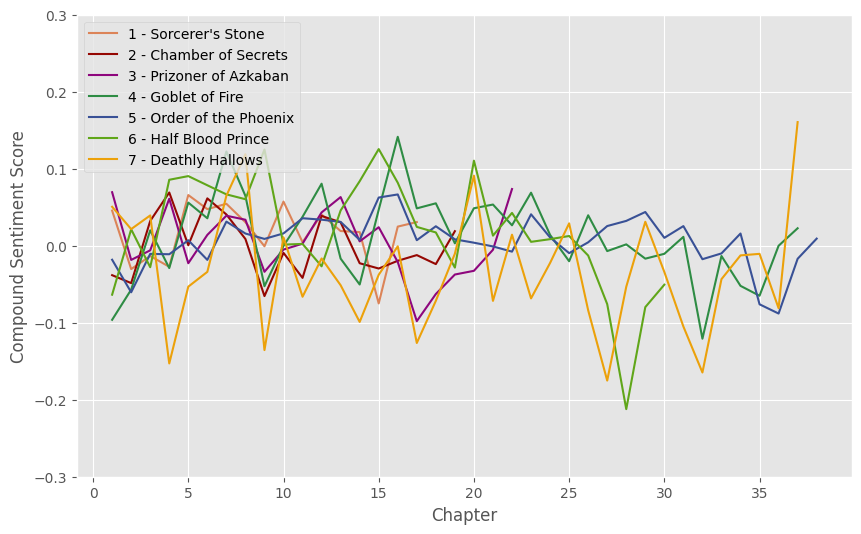

In [ ]:
#@markdown ##🐹 🐾 **[11] <font color = 'red'>7권을 통합하여 감정변화 흐름 확인**
#Time series of sentiments in 7 books of Harry Potter

dfsentiment2.groupby('Book').mean()['CompScore']

def Titles(x):
    if x == 1:
        return "1 - Sorcerer's Stone"
    if x == 2:
        return "2 - Chamber of Secrets"
    if x == 3:
        return "3 - Prizoner of Azkaban"
    if x == 4:
        return "4 - Goblet of Fire"
    if x == 5:
        return "5 - Order of the Phoenix"
    if x == 6:
        return "6 - Half Blood Prince"
    if x == 7:
        return "7 - Deathly Hallows"

dfsentiment2['BookTitle']=dfsentiment2.Book.apply(lambda x: Titles(x))

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

colorsList = ['#DC8458', '#950702', '#8E067D', '#2E8C44', '#395196', '#60A619','#ECA10A'] #Mauraders Map Colors
ColorMap = matplotlib.colors.ListedColormap(colorsList)

# plot data
fig, ax = plt.subplots(figsize=(10,6))
# use unstack()
dfsentiment2.groupby(['Chapter','BookTitle']).mean()['CompScore'].unstack().plot(ax=ax, subplots=False, ylim=(-0.3, 0.3), colormap=ColorMap)
plt.style.use('ggplot')
ax.set_ylabel('Compound Sentiment Score')

[ax.legend(loc=2) for ax in plt.gcf().axes]